# Starbucks Capstone Notebook
Starbucks has always been my go-to coffee shop in Indonesia. The place is nice and cozy, the service is great, and the coffee is, of course, great. Therefore, when I was given a chance to explore Starbucks' data and create something out of it, I was really excited. The data itself is described below.

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Problem Statement
The problem here is in how to create a great recommender system for Starbucks users. It has to consider whether a user likes being given offers or not, and which offer to give to a certain user should he/she likes to recieve and view offers. My strategy in solving the problems will be outlined in the Objectives section below.

## Objectives
My primary objective in this notebook is to create a recommendation engine on promotion. However, I also have several objectives to be completed. They will be described below.  

#### Create an exploratory data analysis to describe Starbucks' user demographics
I want to understand Starbucks' user demographics prior to creating the recommendation engine. This will be in the form of data visualization on demographics attribute such as age, income, gender, or purchase behavior attribute such as amount of transaction, number of transaction done by gender, and number of promotion which is completed by users.

#### Engineer feature which is going to be used for the recommendation engine
This will be predecated by data cleaning. Then, I will create ratios as features because based on my experience in this industry, ratio data is always preferable.

#### Divide the user in this data into clusters
I will use KMeans clustering to cluster the user data. It will be interesting to look at the characteristics of each cluster. I will describe some if the result is too many.

#### Create recommendation engine based on clusters
My idea is to create cluster-promotion matrix where the index will be the clusters, and the columns will be the number of transactions on each promo (the count, not the amount). Then, I will map the user id to the cluster and create recommendations based on that.

## Measuring the Effectiveness of the Recommendation Engine

### Online Testing
Although it's not possible to directly measure the effectiveness of the engine, Starbucks can always do an A/B testing for a certain period of time. Starbucks has to assign cookies in the app to divide users into 2 groups, control and experiment group. The control group will not be given this recommendation engine, and the experiment group will. The metrics to watch are:

**Invariant Metrics**
1. The amount of user in control and experiment group. This should be at least similar, close to 50:50.
2. The number of cookies assigned to each group.

**Evaluation Metrics**
1. The average transaction amount. If the experiment group has higher average transaction amount, the recommendation engine can be considered useful.
2. Percentage of offer completed. If the experiment group has higher percentage of offer completed, the recommendation engine can be considered useful.
3. Ratio of transaction from offer and offer received. The higher it is for the experiment group, the better.
4. Ratio of transaction not from offer and offer received. The lower it is for the experiment group, the better.

### Offline Testing
Another methods that should be considered in evaluating the effectiveness of the recommendation engine are the offline methods. These methods should be computed **after** the first few months of deploying the engine to the experiment group:
1. Precision. This is the metric representing out of the promotion that has been offered, how many does a user like.
2. Recall. This is the proportion of promotion offers that a user likes are recommended to the user.  
These two metrics should be maximized since it will tell us about whether the recommendation engine actually recommends items that a user like, and out of the recommendations, what is the proportion of the promotion offers that a user likes.


## Initial look at the data
Before starting to do anything, I will look at each data set and see what kind of data cleaning should I do to create the exploratory data analysis, clustering, and recommendation engine.

In [1]:
import pandas as pd
import numpy as np
import math
import json

#import machine learning libraries
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

#import clustering libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import time
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

d:\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


The portfolio dataset is quite simple. It contains the channel of promotion, difficulty, duration of promotion (in days), offer id, offer type, and reward for completing a promotion. There are not many things to be cleaned here except:
1. Divide channels column into 4 dummy columns: web, email, mobile, and social.
2. Create a dictionary with offer id as keys and aliases for the purpose of simplifying the merging of 3 data sets later.

Next, I will take a look at profile dataset. 

In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [6]:
profile.duplicated().value_counts()

False    17000
dtype: int64

There are a couple of things that has to be done to clean this data set. What I detected are:
1. There are a couple of people with the age of 118
2. There are a couple of people with missing data on gender and income columns. This is a problem since without the complete data, I will not be able to build good user clusters. I will impute the missing values using machine learning.

I will take a look at the users with the age 118. 

In [7]:
profile[profile['age'] == 118].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [8]:
profile[profile['age'] == 118].isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

Judging from the number of null values and the first few lines of the sliced dataframe, the people with age 118 has no gender and income recorded. This might be because of sign up issues or the users deliberately didn't fill the columns. This makes creating the machine learning prediction for the null values a bit trickier than I thought.

In [9]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [11]:
transcript.sample(25)

,event,person,time,value
172792,transaction,ee63c39ac43f44a28eca41ceab867c1d,420,{'amount': 4.0}
55713,offer received,3f9fa22178894f38beed3d7b0efbe405,168,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
105288,transaction,a32052af10d14dceb5c818f6d712da3c,300,{'amount': 0.4}
243621,transaction,2e5aa7325eaa42089d72d655aa7ae282,570,{'amount': 0.55}
83264,transaction,f59d49c6652547c18b1c18f0271bc604,204,{'amount': 28.84}
72353,offer viewed,4b026d0cd4584db1ac8dca47598aa196,180,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
104954,transaction,b784cc0181ee49f59ffca05ab571872a,300,{'amount': 5.5600000000000005}
32681,transaction,bbdadc0af7ad49e5ae5627940eb3b4e2,60,{'amount': 13.05}
249691,offer received,e31ba2c5c35e4598889fd816c811f326,576,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
133990,offer viewed,d5e5cd91cee74eab965c44d3e0fe1ebd,354,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}


There are no missing values in the dataframe which is great. However, there are a lot of cleaning to do:
1. Create dummy variables for event with 1 or 0 as the value.
2. The problematic one is the column value. Some has only offer id (which correspond to the event offer received and offer viewed), some has reward and offer id (which correspond to offer completed) and some has amount (which correspond to transaction). 
3. The transactions happened are not really clear. They don't show the transactions happened because of certain offer, or even not because of any offer.
4. The column time is in hours. It will be better if I create duration in hour in the **portfolio dataframe**.

# Data Preprocessing
## Cleaning Portfolio
First, I will create dummy variables for channels using pd.get_dummies and stack.

In [12]:
#create dummy variables
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)], axis = 1)
portfolio.drop('channels', axis = 1, inplace = True)

In [13]:
portfolio

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


Then, I will create a dictionary with id as keys and aliases as values.

In [14]:
portfolio_offer_id = portfolio.id.tolist()
portfolio_offer_name = ['bogo1', 'bogo2', 'informational1', 'bogo3', 'discount1', 'discount2', 'discount3', 'informational2', 'bogo4', 'discount4']
offer_name_dict = dict(zip(portfolio_offer_id, portfolio_offer_name))

In [15]:
offer_name_dict

{'0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount1',
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount2',
 '2906b810c7d4411798c6938adc9daaa5': 'discount4',
 '3f207df678b143eea3cee63160fa8bed': 'informational1',
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo2',
 '5a8bc65990b245e5a138643cd4eb9837': 'informational2',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo3',
 'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo1',
 'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo4',
 'fafdcd668e3743c1bb461111dcafc2a4': 'discount3'}

## Cleaning Transcript and Profile
I decided to clean both transcript and profile at the same time by joining the two dataframes.

In [16]:
#merging two dataframes
df = pd.merge(profile,transcript, left_on = 'id', right_on = 'person') 
df.drop(['person'], axis = 1, inplace = True)

In [17]:
#creating dummies for event column, dropping the event column
value_dummies = pd.get_dummies(df['event'])
value_dummies.columns = ['offer_completed', 'offer_received', 'offer_viewed', 'transaction']
df = pd.concat([df, value_dummies], axis = 1)
df.drop('event', axis = 1, inplace = True)

In [18]:
df.head()

,age,became_member_on,gender,id,income,time,value,offer_completed,offer_received,offer_viewed,transaction
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,168,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
1,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,216,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0
2,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
3,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,348,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0
4,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,360,{'amount': 0.35000000000000003},0,0,0,1


**Cleaning value**  
To clean the value column, I will create functions to map the series, and create 4 new columns out of the value column:
1. Offer id column. It will contain the offer id.
2. Transaction amount. It will contain the amount of transaction.
3. Transaction. It will contain 1 if there is a transaction in the row, and 0 if there isn't one.
4. Reward achieved. It will contain the amount of reward achieved when offer was completed

In [19]:
def offer_new(val):
    '''
    INPUT: val - values in Series
    OUTPUT: Series with the value of np.nan if 'amount' in val or val if everything else in val
    '''
    if 'amount' in val:
        return np.nan
    else:
        return val

def transaction_new(val):
    '''
    INPUT: val - values in Series
    OUTPUT: Series with the value of val if 'amount' in val or np.nan if everything else in val
    '''
    if 'amount' in val:
        return val
    else:
        return np.nan

def map_transaction(val):
    '''
    INPUT: val - values in Series
    OUTPUT: Series with value of 1 if val is not np.nan and 0 if it is.
    '''
    if val is not np.nan:
        return 1
    else:
        return 0

def reward_new(val):
    '''
    INPUT: val - values in Series
    OUTPUT: Series with the value of val if 'reward' in val or np.nan if everything else in val
    '''
    if 'reward' in val:
        return val
    else:
        return np.nan


In [20]:
df['offer_id'] = df['value'].apply(offer_new)
df['transaction_amount'] = df['value'].apply(transaction_new)
df.drop('transaction', axis = 1, inplace = True)
df['transaction'] = df['transaction_amount'].apply(map_transaction)

In [21]:
df.head()

,age,became_member_on,gender,id,income,time,value,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,transaction
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,168,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,0
1,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,216,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,0
2,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0
3,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,348,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0
4,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,360,{'amount': 0.35000000000000003},0,0,0,NaN,{'amount': 0.35000000000000003},1


In [22]:
#converting value and offer_id to string for string slicing
df['value'] = df['value'].astype('str')
df['offer_id'] = df['offer_id'].astype('str')

In [23]:
def strip_reward(val):
    '''
    This function strips reward from the offer_id
    '''
    if 'reward' in val:
        val = val[14:]
        return val
    else:
        return val

def strip_offer(val):
    '''
    This function strips only offer from offer_id
    '''
    val = val[:32]
    return val

def get_reward(val):
    '''
    This function gets the reward amount of the reward_achieved column to be created
    '''
    if val != 'nan':
        val = val[:12]
        return val
    else:
        return val

In [24]:
def id_mapper(df):
    '''
    This function creates a unique user_id for each person
    '''
    coded_dict = dict()
    cter = 1
    id_encoded = []
    
    for val in df['id']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        id_encoded.append(coded_dict[val])
    return id_encoded


In [25]:
df['offer_id'] = df['offer_id'].apply(strip_reward)

In [26]:
df.head(25)

,age,became_member_on,gender,id,income,time,value,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,transaction
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,168,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,0
1,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,216,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,0
2,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0
3,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,348,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0
4,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,360,{'amount': 0.35000000000000003},0,0,0,nan,{'amount': 0.35000000000000003},1
5,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,0
6,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,0
7,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,414,{'amount': 0.74},0,0,0,nan,{'amount': 0.74},1
8,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,444,{'amount': 1.8900000000000001},0,0,0,nan,{'amount': 1.8900000000000001},1
9,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,504,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,1,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},NaN,0


In [27]:
#cleaning offer_id
df['offer_id'] = df['offer_id'].str.replace("{'offer id': '", '')
df['offer_id'] = df['offer_id'].str.replace("'offer_id': '", '')
df['offer_id'] = df['offer_id'].str.replace("'}", '')

In [28]:
#cleaning transaction_amount
df['transaction_amount'] = df['transaction_amount'].astype('str')
df['transaction_amount'] = df['transaction_amount'].str.replace("{'amount': ", '')
df['transaction_amount'] = df['transaction_amount'].str.replace("}", '')

In [29]:
#creating reward_achieved column
df['reward_achieved'] = df['value'].apply(reward_new)
df['reward_achieved'] = df['reward_achieved'].astype('str')

In [30]:
#cleaning reward_achieved column
df['reward_achieved'] = df['reward_achieved'].str.replace("{'offer id': '", '')
df['reward_achieved'] = df['reward_achieved'].str.replace("'offer_id': '", '')
df['reward_achieved'] = df.reward_achieved.apply(get_reward)
df['reward_achieved'] = df['reward_achieved'].str.replace("{'reward': ", '')
df['reward_achieved'] = df['reward_achieved'].str.replace('nan', '0')

In [31]:
#cleaning offer_id
df['offer_id'] = df['offer_id'].apply(strip_offer)

In [32]:
#create user_id column
user_id_encoded = id_mapper(df)
del df['id']
df['user_id'] = user_id_encoded

In [33]:
df.head(100)

,age,became_member_on,gender,income,time,value,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,transaction,reward_achieved,user_id
0,118,20170212,None,NaN,168,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,2906b810c7d4411798c6938adc9daaa5,nan,0,0,1
1,118,20170212,None,NaN,216,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,2906b810c7d4411798c6938adc9daaa5,nan,0,0,1
2,118,20170212,None,NaN,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,nan,0,0,1
3,118,20170212,None,NaN,348,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,nan,0,0,1
4,118,20170212,None,NaN,360,{'amount': 0.35000000000000003},0,0,0,nan,0.35000000000000003,1,0,1
5,118,20170212,None,NaN,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,fafdcd668e3743c1bb461111dcafc2a4,nan,0,0,1
6,118,20170212,None,NaN,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,fafdcd668e3743c1bb461111dcafc2a4,nan,0,0,1
7,118,20170212,None,NaN,414,{'amount': 0.74},0,0,0,nan,0.74,1,0,1
8,118,20170212,None,NaN,444,{'amount': 1.8900000000000001},0,0,0,nan,1.8900000000000001,1,0,1
9,118,20170212,None,NaN,504,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,1,0,2298d6c36e964ae4a3e7e9706d1fb8c2,nan,0,0,1


For **portfolio** dataframe, I will also create duration_hours column which convert duration days to hours

In [34]:
portfolio['duration_hours'] = portfolio['duration'] * 24
portfolio

,difficulty,duration,id,offer_type,reward,email,mobile,social,web,duration_hours
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,168
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,120
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,96
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,168
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,240
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,168
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,240
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,72
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,120
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,168


**Creating transaction_from_offer and transaction_offer_viewed columns**  
One of the main problem of this data is that it doesn't tell us if a transaction happens because of an offer or not. And if it is, which offer causes the transaction? To answer the problem, I will create these two columns based on these mechanism:
1. If a transaction occured, I have to check whether it is caused by an offer or not.
2. I assume that if a user had viewed an offer and then did a transaction or even several transactions (to achieve the promo goal), then these transactions are caused by the offer.
3. To check whether a transaction is caused by offer viewed, I need to check if the offer is viewed within the time of transaction and the maximum duration hours of an offer. Then, I will get the first occurence of offer viewed and assign it as offer causing the transaction. The logic is, if a user views a transaction first, they will try to complete the offer if the offer is still within the timeframe. Although this user might receive another offer, the user will try to complete the first offer viewed.

In [35]:
#creating list of unique users and empty list
un_user_list = df.user_id.unique().tolist()

test_list = []
trans_list = []
offer_list = []

In [36]:
#for each user
for user in un_user_list:
    start = time.clock()
    df_id = df[df['user_id'] == user]
    list_transaction = df_id['transaction'].tolist()
    
    #for each transaction
    for i in list_transaction:
        if i == 0:
            test_list.append(i)
            trans_list.append(i)
            offer_list.append(str(i))
        if i == 1:
            idx = len(test_list)
            #get time of purchase, check which offer is viewed
            #the offer viewed is the one causing transaction
            test_time = df_id.loc[idx].time
            delta_time = test_time - portfolio.duration_hours.max()
            slice_df = df_id[(df_id['time'] >= delta_time) & (df_id['time'] < test_time)]
            slice_df.reset_index(inplace = True)
            list_offer_viewed = slice_df['offer_viewed'].tolist()
            try:
                offer_id_purchased = slice_df.loc[list_offer_viewed.index(1)].offer_id
                trans_list.append(1)
                offer_list.append(offer_id_purchased)
                test_list.append(i)
            except:
                trans_list.append(0)
                offer_list.append(str(0))
                test_list.append(i)
    print("Calculating user {}... Time elapsed: {}".format(user, time.clock()-start))

Calculating user 1... Time elapsed: 0.12663000248039205
Calculating user 2... Time elapsed: 0.006851441620978976
Calculating user 3... Time elapsed: 0.013188843367517133
Calculating user 4... Time elapsed: 0.016105869976136916
Calculating user 5... Time elapsed: 0.006631627564853693
Calculating user 6... Time elapsed: 0.006694920328095988
Calculating user 7... Time elapsed: 0.0009921568292036165
Calculating user 8... Time elapsed: 0.006071401079398214
Calculating user 9... Time elapsed: 0.007320150192016539
Calculating user 10... Time elapsed: 0.012832607747376323
Calculating user 11... Time elapsed: 0.019189253915170595
Calculating user 12... Time elapsed: 0.017541076148036655
Calculating user 13... Time elapsed: 0.009746657885508492
Calculating user 14... Time elapsed: 0.014383708100618398
Calculating user 15... Time elapsed: 0.022240136164971724
Calculating user 16... Time elapsed: 0.018191965240298646
Calculating user 17... Time elapsed: 0.019487328617737387
Calculating user 18... 

Calculating user 143... Time elapsed: 0.008660417219052974
Calculating user 144... Time elapsed: 0.015282208746375758
Calculating user 145... Time elapsed: 0.013159762908729888
Calculating user 146... Time elapsed: 0.017278069057536705
Calculating user 147... Time elapsed: 0.01165655978172575
Calculating user 148... Time elapsed: 0.002753235201039761
Calculating user 149... Time elapsed: 0.009749651462148456
Calculating user 150... Time elapsed: 0.01378499277265055
Calculating user 151... Time elapsed: 0.0163145650333143
Calculating user 152... Time elapsed: 0.02437027977111983
Calculating user 153... Time elapsed: 0.013228187517640766
Calculating user 154... Time elapsed: 0.005329849380329765
Calculating user 155... Time elapsed: 0.007637469315839862
Calculating user 156... Time elapsed: 0.011180581095991293
Calculating user 157... Time elapsed: 0.02202973049257162
Calculating user 158... Time elapsed: 0.014059118862098874
Calculating user 159... Time elapsed: 0.00912313863681069
Calc

Calculating user 286... Time elapsed: 0.016773009913015002
Calculating user 287... Time elapsed: 0.008856710315865435
Calculating user 288... Time elapsed: 0.007400549107487109
Calculating user 289... Time elapsed: 0.00965471231728543
Calculating user 290... Time elapsed: 0.023343055329849705
Calculating user 291... Time elapsed: 0.048402713035743616
Calculating user 292... Time elapsed: 0.01968105579171553
Calculating user 293... Time elapsed: 0.00942591753123967
Calculating user 294... Time elapsed: 0.025429578247817552
Calculating user 295... Time elapsed: 0.0010785428979529499
Calculating user 296... Time elapsed: 0.022428303839475916
Calculating user 297... Time elapsed: 0.03452791296389801
Calculating user 298... Time elapsed: 0.031314522267932965
Calculating user 299... Time elapsed: 0.0011059127415178338
Calculating user 300... Time elapsed: 0.01756588006876658
Calculating user 301... Time elapsed: 0.01597372495017879
Calculating user 302... Time elapsed: 0.015510148224809228
C

Calculating user 435... Time elapsed: 0.016343645492101544
Calculating user 436... Time elapsed: 0.04509138961827652
Calculating user 437... Time elapsed: 0.01680679456366363
Calculating user 438... Time elapsed: 0.01362590555693366
Calculating user 439... Time elapsed: 0.02362359622638266
Calculating user 440... Time elapsed: 0.024854811532968313
Calculating user 441... Time elapsed: 0.006171472069929962
Calculating user 442... Time elapsed: 0.007206394279702266
Calculating user 443... Time elapsed: 0.006814663393688747
Calculating user 444... Time elapsed: 0.009231335049650014
Calculating user 445... Time elapsed: 0.015697032937895372
Calculating user 446... Time elapsed: 0.015274083324067433
Calculating user 447... Time elapsed: 0.03165365173584611
Calculating user 448... Time elapsed: 0.006543958534686922
Calculating user 449... Time elapsed: 0.005532984938032115
Calculating user 450... Time elapsed: 0.01627479322938541
Calculating user 451... Time elapsed: 0.00939726472625857
Calc

Calculating user 577... Time elapsed: 0.008958064267813981
Calculating user 578... Time elapsed: 0.01298014831033889
Calculating user 579... Time elapsed: 0.010956062848002546
Calculating user 580... Time elapsed: 0.015434881155007574
Calculating user 581... Time elapsed: 0.007886363830751364
Calculating user 582... Time elapsed: 0.023110839313357445
Calculating user 583... Time elapsed: 0.009229196780623283
Calculating user 584... Time elapsed: 0.0055945670860513275
Calculating user 585... Time elapsed: 0.023103141544856598
Calculating user 586... Time elapsed: 0.013563895755108746
Calculating user 587... Time elapsed: 0.009645731587365702
Calculating user 588... Time elapsed: 0.04652531282875927
Calculating user 589... Time elapsed: 0.04519017764738997
Calculating user 590... Time elapsed: 0.030615735949435674
Calculating user 591... Time elapsed: 0.03806247166793497
Calculating user 592... Time elapsed: 0.0071225741337865855
Calculating user 593... Time elapsed: 0.03966446282405478


Calculating user 721... Time elapsed: 0.03382100122309062
Calculating user 722... Time elapsed: 0.001708049299930181
Calculating user 723... Time elapsed: 0.0062634176381539675
Calculating user 724... Time elapsed: 0.01245456178314619
Calculating user 725... Time elapsed: 0.019628454373615156
Calculating user 726... Time elapsed: 0.013891478570267068
Calculating user 727... Time elapsed: 0.018354046032655447
Calculating user 728... Time elapsed: 0.005217376429431653
Calculating user 729... Time elapsed: 0.00524389096538691
Calculating user 730... Time elapsed: 0.012065824473770803
Calculating user 731... Time elapsed: 0.03651522019894493
Calculating user 732... Time elapsed: 0.015604659715865665
Calculating user 733... Time elapsed: 0.024882609030338898
Calculating user 734... Time elapsed: 0.005885799327728591
Calculating user 735... Time elapsed: 0.01827792365524239
Calculating user 736... Time elapsed: 0.010350077405339775
Calculating user 737... Time elapsed: 0.04657919720827586
Ca

Calculating user 861... Time elapsed: 0.00923219035725964
Calculating user 862... Time elapsed: 0.00811002677112782
Calculating user 863... Time elapsed: 0.027044399018105736
Calculating user 864... Time elapsed: 0.010046015549491472
Calculating user 865... Time elapsed: 0.022360306884369407
Calculating user 866... Time elapsed: 0.023556026925085405
Calculating user 867... Time elapsed: 0.0094477278753331
Calculating user 868... Time elapsed: 0.017611639025975734
Calculating user 869... Time elapsed: 0.022128518521686402
Calculating user 870... Time elapsed: 0.011296475277333684
Calculating user 871... Time elapsed: 0.006924142767946506
Calculating user 872... Time elapsed: 0.03265136806452418
Calculating user 873... Time elapsed: 0.009248013548070588
Calculating user 874... Time elapsed: 0.04494727028576051
Calculating user 875... Time elapsed: 0.029837833676882752
Calculating user 876... Time elapsed: 0.026732211739950884
Calculating user 877... Time elapsed: 0.008592420263948242
Cal

Calculating user 1007... Time elapsed: 0.021271927948887992
Calculating user 1008... Time elapsed: 0.006528562997679899
Calculating user 1009... Time elapsed: 0.047813833745305345
Calculating user 1010... Time elapsed: 0.026851099497932296
Calculating user 1011... Time elapsed: 0.008751507479665577
Calculating user 1012... Time elapsed: 0.03838064609936964
Calculating user 1013... Time elapsed: 0.007380449378619147
Calculating user 1014... Time elapsed: 0.009464406373751899
Calculating user 1015... Time elapsed: 0.01679011606524128
Calculating user 1016... Time elapsed: 0.005408537680576586
Calculating user 1017... Time elapsed: 0.009368611921278358
Calculating user 1018... Time elapsed: 0.014898175628864863
Calculating user 1019... Time elapsed: 0.02220720682193189
Calculating user 1020... Time elapsed: 0.022388104381739993
Calculating user 1021... Time elapsed: 0.011566752482529807
Calculating user 1022... Time elapsed: 0.022830726070630192
Calculating user 1023... Time elapsed: 0.03

Calculating user 1146... Time elapsed: 0.016506153938262713
Calculating user 1147... Time elapsed: 0.020549193017266987
Calculating user 1148... Time elapsed: 0.0151731570259237
Calculating user 1149... Time elapsed: 0.01825739627256695
Calculating user 1150... Time elapsed: 0.016812781716943448
Calculating user 1151... Time elapsed: 0.044952402131428926
Calculating user 1152... Time elapsed: 0.015597389601168743
Calculating user 1153... Time elapsed: 0.021804784590777615
Calculating user 1154... Time elapsed: 0.011754492503225578
Calculating user 1155... Time elapsed: 0.01007167477783355
Calculating user 1156... Time elapsed: 0.004298348401004404
Calculating user 1157... Time elapsed: 0.008052293507358144
Calculating user 1158... Time elapsed: 0.010320996946553862
Calculating user 1159... Time elapsed: 0.0057408246875994
Calculating user 1160... Time elapsed: 0.017669799943551112
Calculating user 1161... Time elapsed: 0.034490707082802885
Calculating user 1162... Time elapsed: 0.01398

Calculating user 1286... Time elapsed: 0.008550510190989513
Calculating user 1287... Time elapsed: 0.03651650316036026
Calculating user 1288... Time elapsed: 0.02287947860448014
Calculating user 1289... Time elapsed: 0.03878093006149541
Calculating user 1290... Time elapsed: 0.007851723872491334
Calculating user 1291... Time elapsed: 0.008636040952126223
Calculating user 1292... Time elapsed: 0.014593686119212634
Calculating user 1293... Time elapsed: 0.028453518307859582
Calculating user 1294... Time elapsed: 0.013483924493446153
Calculating user 1295... Time elapsed: 0.009978446248190664
Calculating user 1296... Time elapsed: 0.019823036855207476
Calculating user 1297... Time elapsed: 0.014704448454885721
Calculating user 1298... Time elapsed: 0.04493358536397807
Calculating user 1299... Time elapsed: 0.013084068185122533
Calculating user 1300... Time elapsed: 0.01150174910406676
Calculating user 1301... Time elapsed: 0.026824584961978815
Calculating user 1302... Time elapsed: 0.0231

Calculating user 1429... Time elapsed: 0.004387728046392425
Calculating user 1430... Time elapsed: 0.02967019338505139
Calculating user 1431... Time elapsed: 0.008529127500708
Calculating user 1432... Time elapsed: 0.03504024222311486
Calculating user 1433... Time elapsed: 0.01437857625495198
Calculating user 1434... Time elapsed: 0.007151654592572498
Calculating user 1435... Time elapsed: 0.003284381227707911
Calculating user 1436... Time elapsed: 0.013270525244404752
Calculating user 1437... Time elapsed: 0.0068424608910611084
Calculating user 1438... Time elapsed: 0.014847284825986407
Calculating user 1439... Time elapsed: 0.02823028302128705
Calculating user 1440... Time elapsed: 0.011480366413778142
Calculating user 1441... Time elapsed: 0.015088053918592692
Calculating user 1442... Time elapsed: 0.012526835276307935
Calculating user 1443... Time elapsed: 0.001438627402343684
Calculating user 1444... Time elapsed: 0.03224595225672644
Calculating user 1445... Time elapsed: 0.037469

Calculating user 1568... Time elapsed: 0.01704542538724141
Calculating user 1569... Time elapsed: 0.021857386008878876
Calculating user 1570... Time elapsed: 0.0122202074976272
Calculating user 1571... Time elapsed: 0.020137790056192983
Calculating user 1572... Time elapsed: 0.013469384264052309
Calculating user 1573... Time elapsed: 0.051005841750985326
Calculating user 1574... Time elapsed: 0.01791527322801656
Calculating user 1575... Time elapsed: 0.02058554359075515
Calculating user 1576... Time elapsed: 0.04789380500696794
Calculating user 1577... Time elapsed: 0.012951067851552978
Calculating user 1578... Time elapsed: 0.013834172960304869
Calculating user 1579... Time elapsed: 0.014729680029425651
Calculating user 1580... Time elapsed: 0.013657979592363034
Calculating user 1581... Time elapsed: 0.00825756733409122
Calculating user 1582... Time elapsed: 0.01440851202134752
Calculating user 1583... Time elapsed: 0.04024008484651276
Calculating user 1584... Time elapsed: 0.01804741

Calculating user 1707... Time elapsed: 0.035621851398857984
Calculating user 1708... Time elapsed: 0.010112729543180876
Calculating user 1709... Time elapsed: 0.03114645432229679
Calculating user 1710... Time elapsed: 0.029012461831896985
Calculating user 1711... Time elapsed: 0.021345484403468618
Calculating user 1712... Time elapsed: 0.012967318696169627
Calculating user 1713... Time elapsed: 0.017715558900761152
Calculating user 1714... Time elapsed: 0.0076242120478582365
Calculating user 1715... Time elapsed: 0.005017234448366992
Calculating user 1716... Time elapsed: 0.013708015087622982
Calculating user 1717... Time elapsed: 0.025422735786925443
Calculating user 1718... Time elapsed: 0.006654720870358233
Calculating user 1719... Time elapsed: 0.010084932045806738
Calculating user 1720... Time elapsed: 0.03366918412206843
Calculating user 1721... Time elapsed: 0.03218650837773396
Calculating user 1722... Time elapsed: 0.013834172960308422
Calculating user 1723... Time elapsed: 0.0

Calculating user 1852... Time elapsed: 0.01588092407434516
Calculating user 1853... Time elapsed: 0.02435231831127993
Calculating user 1854... Time elapsed: 0.02596542846634975
Calculating user 1855... Time elapsed: 0.041212997254461925
Calculating user 1856... Time elapsed: 0.006331842247064401
Calculating user 1857... Time elapsed: 0.02105510746940098
Calculating user 1858... Time elapsed: 0.025610048153815512
Calculating user 1859... Time elapsed: 0.00788721913836099
Calculating user 1860... Time elapsed: 0.013638307517297221
Calculating user 1861... Time elapsed: 0.011189134172106208
Calculating user 1862... Time elapsed: 0.013444152689515931
Calculating user 1863... Time elapsed: 0.03618079492289894
Calculating user 1864... Time elapsed: 0.018681628847815546
Calculating user 1865... Time elapsed: 0.028175543334157283
Calculating user 1866... Time elapsed: 0.010955635194200397
Calculating user 1867... Time elapsed: 0.008588999033499078
Calculating user 1868... Time elapsed: 0.01869

Calculating user 1997... Time elapsed: 0.030791501663578913
Calculating user 1998... Time elapsed: 0.015449849038205343
Calculating user 1999... Time elapsed: 0.007843598450179456
Calculating user 2000... Time elapsed: 0.02033365549920063
Calculating user 2001... Time elapsed: 0.022086180794921972
Calculating user 2002... Time elapsed: 0.015117134377376829
Calculating user 2003... Time elapsed: 0.017243856753083264
Calculating user 2004... Time elapsed: 0.005196849046754437
Calculating user 2005... Time elapsed: 0.01563587844368186
Calculating user 2006... Time elapsed: 0.02201561791698481
Calculating user 2007... Time elapsed: 0.01358827202203372
Calculating user 2008... Time elapsed: 0.028062642729459242
Calculating user 2009... Time elapsed: 0.015663675941056
Calculating user 2010... Time elapsed: 0.026372127235561038
Calculating user 2011... Time elapsed: 0.013948784180229268
Calculating user 2012... Time elapsed: 0.025826013325698227
Calculating user 2013... Time elapsed: 0.034787

Calculating user 2136... Time elapsed: 0.025750746255894796
Calculating user 2137... Time elapsed: 0.021861662546932337
Calculating user 2138... Time elapsed: 0.016934235397755515
Calculating user 2139... Time elapsed: 0.007575031860206138
Calculating user 2140... Time elapsed: 0.006815091047492672
Calculating user 2141... Time elapsed: 0.01554436052926178
Calculating user 2142... Time elapsed: 0.01360837175089813
Calculating user 2143... Time elapsed: 0.024716679353730342
Calculating user 2144... Time elapsed: 0.011777158154927747
Calculating user 2145... Time elapsed: 0.00306884370963445
Calculating user 2146... Time elapsed: 0.017623613332531818
Calculating user 2147... Time elapsed: 0.0009472531796035355
Calculating user 2148... Time elapsed: 0.012005952940974396
Calculating user 2149... Time elapsed: 0.007329986229549945
Calculating user 2150... Time elapsed: 0.017607790141724422
Calculating user 2151... Time elapsed: 0.011304600699638456
Calculating user 2152... Time elapsed: 0.0

Calculating user 2278... Time elapsed: 0.013583995483976707
Calculating user 2279... Time elapsed: 0.05026215178288851
Calculating user 2280... Time elapsed: 0.035760411231898104
Calculating user 2281... Time elapsed: 0.0011858840031848672
Calculating user 2282... Time elapsed: 0.012896755818232464
Calculating user 2283... Time elapsed: 0.021562304882948524
Calculating user 2284... Time elapsed: 0.0129429424292411
Calculating user 2285... Time elapsed: 0.006880094425959271
Calculating user 2286... Time elapsed: 0.027697426379397427
Calculating user 2287... Time elapsed: 0.01878426576118386
Calculating user 2288... Time elapsed: 0.004531419725104513
Calculating user 2289... Time elapsed: 0.026882318225752044
Calculating user 2290... Time elapsed: 0.021119255540256177
Calculating user 2291... Time elapsed: 0.015112002531708413
Calculating user 2292... Time elapsed: 0.029105690361532766
Calculating user 2293... Time elapsed: 0.028256797557247637
Calculating user 2294... Time elapsed: 0.01

Calculating user 2416... Time elapsed: 0.028100276264360957
Calculating user 2417... Time elapsed: 0.018534088284852146
Calculating user 2418... Time elapsed: 0.005291788191627234
Calculating user 2419... Time elapsed: 0.033214160472816445
Calculating user 2420... Time elapsed: 0.01649204136267457
Calculating user 2421... Time elapsed: 0.02353207831196613
Calculating user 2422... Time elapsed: 0.004772616471512947
Calculating user 2423... Time elapsed: 0.04710521138927959
Calculating user 2424... Time elapsed: 0.03466561748933117
Calculating user 2425... Time elapsed: 0.006180025146043988
Calculating user 2426... Time elapsed: 0.021221464799815237
Calculating user 2427... Time elapsed: 0.013929967412785516
Calculating user 2428... Time elapsed: 0.005645030235129411
Calculating user 2429... Time elapsed: 0.019124250536705745
Calculating user 2430... Time elapsed: 0.02695801294935052
Calculating user 2431... Time elapsed: 0.0011054850877130207
Calculating user 2432... Time elapsed: 0.017

Calculating user 2560... Time elapsed: 0.02154562638452262
Calculating user 2561... Time elapsed: 0.026750600853603146
Calculating user 2562... Time elapsed: 0.04364463679362274
Calculating user 2563... Time elapsed: 0.014786985639389627
Calculating user 2564... Time elapsed: 0.017569728953013453
Calculating user 2565... Time elapsed: 0.009475097718897985
Calculating user 2566... Time elapsed: 0.026038984920930375
Calculating user 2567... Time elapsed: 0.024691875432999666
Calculating user 2568... Time elapsed: 0.015042294961382652
Calculating user 2569... Time elapsed: 0.010912869813630266
Calculating user 2570... Time elapsed: 0.014633457923146409
Calculating user 2571... Time elapsed: 0.02934731476175756
Calculating user 2572... Time elapsed: 0.003451593865733571
Calculating user 2573... Time elapsed: 0.005249450464859251
Calculating user 2574... Time elapsed: 0.019363309014089225
Calculating user 2575... Time elapsed: 0.009555068980560577
Calculating user 2576... Time elapsed: 0.00

Calculating user 2707... Time elapsed: 0.00909747940846728
Calculating user 2708... Time elapsed: 0.020264803236486273
Calculating user 2709... Time elapsed: 0.031069048983468406
Calculating user 2710... Time elapsed: 0.0012158197695768536
Calculating user 2711... Time elapsed: 0.02410983860345084
Calculating user 2712... Time elapsed: 0.026305840895673782
Calculating user 2713... Time elapsed: 0.008399976051386204
Calculating user 2714... Time elapsed: 0.046054893642498484
Calculating user 2715... Time elapsed: 0.033243240931604134
Calculating user 2716... Time elapsed: 0.03183968114132085
Calculating user 2717... Time elapsed: 0.018714985844653143
Calculating user 2718... Time elapsed: 0.018267659963910887
Calculating user 2719... Time elapsed: 0.009846728876041766
Calculating user 2720... Time elapsed: 0.03727644397307728
Calculating user 2721... Time elapsed: 0.0012209516152523747
Calculating user 2722... Time elapsed: 0.01889160686640423
Calculating user 2723... Time elapsed: 0.04

Calculating user 2845... Time elapsed: 0.02176458513304169
Calculating user 2846... Time elapsed: 0.023032151013111957
Calculating user 2847... Time elapsed: 0.025075480896703084
Calculating user 2848... Time elapsed: 0.013674658090785385
Calculating user 2849... Time elapsed: 0.022638281858071707
Calculating user 2850... Time elapsed: 0.0010935107811462785
Calculating user 2851... Time elapsed: 0.009963050711192523
Calculating user 2852... Time elapsed: 0.01146539853058215
Calculating user 2853... Time elapsed: 0.03418835584217561
Calculating user 2854... Time elapsed: 0.014962751353522208
Calculating user 2855... Time elapsed: 0.021964727114109905
Calculating user 2856... Time elapsed: 0.015197960946650824
Calculating user 2857... Time elapsed: 0.010015652129290231
Calculating user 2858... Time elapsed: 0.023346476560298868
Calculating user 2859... Time elapsed: 0.011978583097409512
Calculating user 2860... Time elapsed: 0.018038437524054984
Calculating user 2861... Time elapsed: 0.0

Calculating user 2989... Time elapsed: 0.023916111429471698
Calculating user 2990... Time elapsed: 0.013335528622867798
Calculating user 2991... Time elapsed: 0.041436232541030904
Calculating user 2992... Time elapsed: 0.009540956404968881
Calculating user 2993... Time elapsed: 0.007234619430875
Calculating user 2994... Time elapsed: 0.015187269601511844
Calculating user 2995... Time elapsed: 0.01551741833950615
Calculating user 2996... Time elapsed: 0.0240627966848308
Calculating user 2997... Time elapsed: 0.022765295038361444
Calculating user 2998... Time elapsed: 0.02426978112678313
Calculating user 2999... Time elapsed: 0.016574578547178476
Calculating user 3000... Time elapsed: 0.033111095905638877
Calculating user 3001... Time elapsed: 0.007899621098729881
Calculating user 3002... Time elapsed: 0.03096555676248869
Calculating user 3003... Time elapsed: 0.04088712505452463
Calculating user 3004... Time elapsed: 0.011693338009017396
Calculating user 3005... Time elapsed: 0.01635519

Calculating user 3137... Time elapsed: 0.011417073650534348
Calculating user 3138... Time elapsed: 0.019672502715600615
Calculating user 3139... Time elapsed: 0.01997955814808705
Calculating user 3140... Time elapsed: 0.03034075455236973
Calculating user 3141... Time elapsed: 0.005265273655673752
Calculating user 3142... Time elapsed: 0.012764183138465057
Calculating user 3143... Time elapsed: 0.02810155922577451
Calculating user 3144... Time elapsed: 0.015694467015059388
Calculating user 3145... Time elapsed: 0.011319996236643703
Calculating user 3146... Time elapsed: 0.025863646860592837
Calculating user 3147... Time elapsed: 0.027296714763465957
Calculating user 3148... Time elapsed: 0.04106075249963226
Calculating user 3149... Time elapsed: 0.022425737916641708
Calculating user 3150... Time elapsed: 0.0066735376378090905
Calculating user 3151... Time elapsed: 0.019286758982865138
Calculating user 3152... Time elapsed: 0.030571259953639185
Calculating user 3153... Time elapsed: 0.02

Calculating user 3281... Time elapsed: 0.028256369903438383
Calculating user 3282... Time elapsed: 0.015818058964903514
Calculating user 3283... Time elapsed: 0.036804741825392284
Calculating user 3284... Time elapsed: 0.005769905146387089
Calculating user 3285... Time elapsed: 0.016707578880740925
Calculating user 3286... Time elapsed: 0.021527237270881017
Calculating user 3287... Time elapsed: 0.021289034101116044
Calculating user 3288... Time elapsed: 0.011555633483581573
Calculating user 3289... Time elapsed: 0.019830306969900846
Calculating user 3290... Time elapsed: 0.04666045143135733
Calculating user 3291... Time elapsed: 0.013215785557271431
Calculating user 3292... Time elapsed: 0.008461558199400088
Calculating user 3293... Time elapsed: 0.009029482453364324
Calculating user 3294... Time elapsed: 0.016366311143798384
Calculating user 3295... Time elapsed: 0.01950144119332009
Calculating user 3296... Time elapsed: 0.006148378764422091
Calculating user 3297... Time elapsed: 0.0

Calculating user 3420... Time elapsed: 0.030230847524308047
Calculating user 3421... Time elapsed: 0.02830555009109048
Calculating user 3422... Time elapsed: 0.025138773659946878
Calculating user 3423... Time elapsed: 0.00784958560346638
Calculating user 3424... Time elapsed: 0.009637606165057377
Calculating user 3425... Time elapsed: 0.0073569284193126805
Calculating user 3426... Time elapsed: 0.04305148096513278
Calculating user 3427... Time elapsed: 0.0188488414858341
Calculating user 3428... Time elapsed: 0.008393988898106386
Calculating user 3429... Time elapsed: 0.005957217513284263
Calculating user 3430... Time elapsed: 0.012727832564976893
Calculating user 3431... Time elapsed: 0.021158599690366486
Calculating user 3432... Time elapsed: 0.008832761702748826
Calculating user 3433... Time elapsed: 0.010310733255209925
Calculating user 3434... Time elapsed: 0.011483787644223753
Calculating user 3435... Time elapsed: 0.006441749275126085
Calculating user 3436... Time elapsed: 0.004

Calculating user 3559... Time elapsed: 0.020685186927480004
Calculating user 3560... Time elapsed: 0.019436865468662745
Calculating user 3561... Time elapsed: 0.017085197191164525
Calculating user 3562... Time elapsed: 0.037987204598138646
Calculating user 3563... Time elapsed: 0.010833326205769822
Calculating user 3564... Time elapsed: 0.00759085505102064
Calculating user 3565... Time elapsed: 0.0308047589315521
Calculating user 3566... Time elapsed: 0.010689634527054181
Calculating user 3567... Time elapsed: 0.020861380295414733
Calculating user 3568... Time elapsed: 0.008139107229922615
Calculating user 3569... Time elapsed: 0.0112691054337688
Calculating user 3570... Time elapsed: 0.012904453586742193
Calculating user 3571... Time elapsed: 0.023258807530126546
Calculating user 3572... Time elapsed: 0.0013565178716561377
Calculating user 3573... Time elapsed: 0.016305156649593755
Calculating user 3574... Time elapsed: 0.025865785129624896
Calculating user 3575... Time elapsed: 0.006

Calculating user 3706... Time elapsed: 0.022807205111320172
Calculating user 3707... Time elapsed: 0.025905984587353714
Calculating user 3708... Time elapsed: 0.011803672690888334
Calculating user 3709... Time elapsed: 0.0164364463679334
Calculating user 3710... Time elapsed: 0.016120837859347148
Calculating user 3711... Time elapsed: 0.006901904770046485
Calculating user 3712... Time elapsed: 0.021658099335425618
Calculating user 3713... Time elapsed: 0.026096718184703604
Calculating user 3714... Time elapsed: 0.005306328421013973
Calculating user 3715... Time elapsed: 0.003165921123525095
Calculating user 3716... Time elapsed: 0.008810951358654506
Calculating user 3717... Time elapsed: 0.009402396571928762
Calculating user 3718... Time elapsed: 0.007440320911413778
Calculating user 3719... Time elapsed: 0.027523798934282695
Calculating user 3720... Time elapsed: 0.007843170796363097
Calculating user 3721... Time elapsed: 0.033766689189775434
Calculating user 3722... Time elapsed: 0.0

Calculating user 3849... Time elapsed: 0.022989813286343974
Calculating user 3850... Time elapsed: 0.022548046905072283
Calculating user 3851... Time elapsed: 0.008707031483879746
Calculating user 3852... Time elapsed: 0.03336469461243041
Calculating user 3853... Time elapsed: 0.012866392398024118
Calculating user 3854... Time elapsed: 0.019214057835910126
Calculating user 3855... Time elapsed: 0.023486747008561792
Calculating user 3856... Time elapsed: 0.026467494034235983
Calculating user 3857... Time elapsed: 0.012763327830853655
Calculating user 3858... Time elapsed: 0.008859276238709413
Calculating user 3859... Time elapsed: 0.03342670441423934
Calculating user 3860... Time elapsed: 0.020599228512537593
Calculating user 3861... Time elapsed: 0.0538505948664465
Calculating user 3862... Time elapsed: 0.03490724188955596
Calculating user 3863... Time elapsed: 0.008073676197653867
Calculating user 3864... Time elapsed: 0.056469546772490276
Calculating user 3865... Time elapsed: 0.0153

Calculating user 3993... Time elapsed: 0.03572662658125125
Calculating user 3994... Time elapsed: 0.019289324905699345
Calculating user 3995... Time elapsed: 0.01047110343235147
Calculating user 3996... Time elapsed: 0.00936348007560639
Calculating user 3997... Time elapsed: 0.030389079432424637
Calculating user 3998... Time elapsed: 0.028011751926570128
Calculating user 3999... Time elapsed: 0.012727832564976893
Calculating user 4000... Time elapsed: 0.02075788807444212
Calculating user 4001... Time elapsed: 0.017531667764316694
Calculating user 4002... Time elapsed: 0.00892470727096395
Calculating user 4003... Time elapsed: 0.012230898842759075
Calculating user 4004... Time elapsed: 0.013359477235979966
Calculating user 4005... Time elapsed: 0.010852570627022828
Calculating user 4006... Time elapsed: 0.002078825149467889
Calculating user 4007... Time elapsed: 0.0036949288811740644
Calculating user 4008... Time elapsed: 0.01974092732451993
Calculating user 4009... Time elapsed: 0.0398

Calculating user 4138... Time elapsed: 0.029337051070413622
Calculating user 4139... Time elapsed: 0.04263751208121391
Calculating user 4140... Time elapsed: 0.02856128706689276
Calculating user 4141... Time elapsed: 0.021904000273693214
Calculating user 4142... Time elapsed: 0.007921859096626349
Calculating user 4143... Time elapsed: 0.014731390644641351
Calculating user 4144... Time elapsed: 0.01052498781186273
Calculating user 4145... Time elapsed: 0.013312862971176287
Calculating user 4146... Time elapsed: 0.013156341678282502
Calculating user 4147... Time elapsed: 0.008098480118377438
Calculating user 4148... Time elapsed: 0.019462524697004824
Calculating user 4149... Time elapsed: 0.015571730372826664
Calculating user 4150... Time elapsed: 0.011483359990421604
Calculating user 4151... Time elapsed: 0.011293481700704433
Calculating user 4152... Time elapsed: 0.019214913143514423
Calculating user 4153... Time elapsed: 0.014051421093597583
Calculating user 4154... Time elapsed: 0.00

Calculating user 4278... Time elapsed: 0.025585244233084836
Calculating user 4279... Time elapsed: 0.008435043663453712
Calculating user 4280... Time elapsed: 0.028081031843100845
Calculating user 4281... Time elapsed: 0.013524979258789926
Calculating user 4282... Time elapsed: 0.01760522421888311
Calculating user 4283... Time elapsed: 0.030325359015364484
Calculating user 4284... Time elapsed: 0.010376591941295032
Calculating user 4285... Time elapsed: 0.02042816699025707
Calculating user 4286... Time elapsed: 0.003339548568646933
Calculating user 4287... Time elapsed: 0.010552357655441824
Calculating user 4288... Time elapsed: 0.014318704722143138
Calculating user 4289... Time elapsed: 0.01803245037078227
Calculating user 4290... Time elapsed: 0.022417184840534787
Calculating user 4291... Time elapsed: 0.030929633842816884
Calculating user 4292... Time elapsed: 0.03258893060889534
Calculating user 4293... Time elapsed: 0.017034306388296727
Calculating user 4294... Time elapsed: 0.014

Calculating user 4426... Time elapsed: 0.019688325906400905
Calculating user 4427... Time elapsed: 0.006061992695663321
Calculating user 4428... Time elapsed: 0.019458248158954916
Calculating user 4429... Time elapsed: 0.018975854666138048
Calculating user 4430... Time elapsed: 0.017246850329712515
Calculating user 4431... Time elapsed: 0.0010823917822051499
Calculating user 4432... Time elapsed: 0.020148481401335516
Calculating user 4433... Time elapsed: 0.018318550766778685
Calculating user 4434... Time elapsed: 0.017266094750979732
Calculating user 4435... Time elapsed: 0.007487790483850176
Calculating user 4436... Time elapsed: 0.030747025667793082
Calculating user 4437... Time elapsed: 0.0135814295611425
Calculating user 4438... Time elapsed: 0.009250151817099095
Calculating user 4439... Time elapsed: 0.02459821924954042
Calculating user 4440... Time elapsed: 0.012717996527456421
Calculating user 4441... Time elapsed: 0.011452141262608961
Calculating user 4442... Time elapsed: 0.0

Calculating user 4564... Time elapsed: 0.007006679952453965
Calculating user 4565... Time elapsed: 0.037919635296830734
Calculating user 4566... Time elapsed: 0.020569720399933544
Calculating user 4567... Time elapsed: 0.005447881830690449
Calculating user 4568... Time elapsed: 0.02632166408649539
Calculating user 4569... Time elapsed: 0.012644867726677944
Calculating user 4570... Time elapsed: 0.0051545113199864545
Calculating user 4571... Time elapsed: 0.02000992156828829
Calculating user 4572... Time elapsed: 0.01103945534012496
Calculating user 4573... Time elapsed: 0.015275366285479208
Calculating user 4574... Time elapsed: 0.009418647416538306
Calculating user 4575... Time elapsed: 0.003081245670003341
Calculating user 4576... Time elapsed: 0.019610065259982434
Calculating user 4577... Time elapsed: 0.013485635108665406
Calculating user 4578... Time elapsed: 0.03882027421161638
Calculating user 4579... Time elapsed: 0.008107033194491464
Calculating user 4580... Time elapsed: 0.00

Calculating user 4703... Time elapsed: 0.028635271175275534
Calculating user 4704... Time elapsed: 0.04431519796095529
Calculating user 4705... Time elapsed: 0.0319175141339656
Calculating user 4706... Time elapsed: 0.01775960724275194
Calculating user 4707... Time elapsed: 0.027517384127193623
Calculating user 4708... Time elapsed: 0.02816955618088457
Calculating user 4709... Time elapsed: 0.020690746426950568
Calculating user 4710... Time elapsed: 0.016019911561187428
Calculating user 4711... Time elapsed: 0.023953744964373413
Calculating user 4712... Time elapsed: 0.016376147181333067
Calculating user 4713... Time elapsed: 0.013471094879278667
Calculating user 4714... Time elapsed: 0.001141835661186974
Calculating user 4715... Time elapsed: 0.013722555317031038
Calculating user 4716... Time elapsed: 0.021500295081125387
Calculating user 4717... Time elapsed: 0.01689360828622455
Calculating user 4718... Time elapsed: 0.015111574877906264
Calculating user 4719... Time elapsed: 0.00093

Calculating user 4845... Time elapsed: 0.011522704140531914
Calculating user 4846... Time elapsed: 0.022342345424533505
Calculating user 4847... Time elapsed: 0.031881591214286686
Calculating user 4848... Time elapsed: 0.006478955156225652
Calculating user 4849... Time elapsed: 0.003139406587578719
Calculating user 4850... Time elapsed: 0.03208558207960266
Calculating user 4851... Time elapsed: 0.023680901836343082
Calculating user 4852... Time elapsed: 0.011645868436588103
Calculating user 4853... Time elapsed: 0.018635869890601953
Calculating user 4854... Time elapsed: 0.015685913938952467
Calculating user 4855... Time elapsed: 0.01293781058357979
Calculating user 4856... Time elapsed: 0.010679370835731561
Calculating user 4857... Time elapsed: 0.03066534379090058
Calculating user 4858... Time elapsed: 0.017733520360593502
Calculating user 4859... Time elapsed: 0.014113003241618571
Calculating user 4860... Time elapsed: 0.013658834899970884
Calculating user 4861... Time elapsed: 0.05

Calculating user 4988... Time elapsed: 0.0321142348845882
Calculating user 4989... Time elapsed: 0.02211355063847975
Calculating user 4990... Time elapsed: 0.026218171865522777
Calculating user 4991... Time elapsed: 0.01811969174714534
Calculating user 4992... Time elapsed: 0.009522567291327277
Calculating user 4993... Time elapsed: 0.03616753765491865
Calculating user 4994... Time elapsed: 0.029317378995358467
Calculating user 4995... Time elapsed: 0.01224714968738283
Calculating user 4996... Time elapsed: 0.012649571918544211
Calculating user 4997... Time elapsed: 0.017639436523353424
Calculating user 4998... Time elapsed: 0.05911201963786539
Calculating user 4999... Time elapsed: 0.01701506196704372
Calculating user 5000... Time elapsed: 0.006940393612552498
Calculating user 5001... Time elapsed: 0.013647715901029756
Calculating user 5002... Time elapsed: 0.008373461515432723
Calculating user 5003... Time elapsed: 0.0217504725574571
Calculating user 5004... Time elapsed: 0.010421495

Calculating user 5131... Time elapsed: 0.009072675487743709
Calculating user 5132... Time elapsed: 0.0383019577991206
Calculating user 5133... Time elapsed: 0.03276854520727568
Calculating user 5134... Time elapsed: 0.009399830649087448
Calculating user 5135... Time elapsed: 0.029430707253865762
Calculating user 5136... Time elapsed: 0.020167725822602733
Calculating user 5137... Time elapsed: 0.012667533378376561
Calculating user 5138... Time elapsed: 0.005070691174083208
Calculating user 5139... Time elapsed: 0.011331542889394086
Calculating user 5140... Time elapsed: 0.015734238818993163
Calculating user 5141... Time elapsed: 0.016866666096461813
Calculating user 5142... Time elapsed: 0.022285039814562424
Calculating user 5143... Time elapsed: 0.021812910013082387
Calculating user 5144... Time elapsed: 0.016220481196072
Calculating user 5145... Time elapsed: 0.009351078115244604
Calculating user 5146... Time elapsed: 0.013641728747742832
Calculating user 5147... Time elapsed: 0.03735

Calculating user 5271... Time elapsed: 0.02143486404885664
Calculating user 5272... Time elapsed: 0.02452722871780111
Calculating user 5273... Time elapsed: 0.03333176526938075
Calculating user 5274... Time elapsed: 0.013359049582192029
Calculating user 5275... Time elapsed: 0.007263272235860541
Calculating user 5276... Time elapsed: 0.017571011914427004
Calculating user 5277... Time elapsed: 0.005254154656725518
Calculating user 5278... Time elapsed: 0.026319098163654076
Calculating user 5279... Time elapsed: 0.001013111865674432
Calculating user 5280... Time elapsed: 0.034014300743265835
Calculating user 5281... Time elapsed: 0.010684075027583617
Calculating user 5282... Time elapsed: 0.02620961878939454
Calculating user 5283... Time elapsed: 0.013796111771597452
Calculating user 5284... Time elapsed: 0.005550946397875123
Calculating user 5285... Time elapsed: 0.01611656132128303
Calculating user 5286... Time elapsed: 0.007347092381763787
Calculating user 5287... Time elapsed: 0.0074

Calculating user 5412... Time elapsed: 0.021846267009919984
Calculating user 5413... Time elapsed: 0.010141810001968565
Calculating user 5414... Time elapsed: 0.014762609372468205
Calculating user 5415... Time elapsed: 0.012737240948709427
Calculating user 5416... Time elapsed: 0.030496420537645008
Calculating user 5417... Time elapsed: 0.016488620132236065
Calculating user 5418... Time elapsed: 0.021612768032028384
Calculating user 5419... Time elapsed: 0.027028575827301893
Calculating user 5420... Time elapsed: 0.01815818058965135
Calculating user 5421... Time elapsed: 0.04344363950494312
Calculating user 5422... Time elapsed: 0.009605959783442586
Calculating user 5423... Time elapsed: 0.01107537825980387
Calculating user 5424... Time elapsed: 0.02657611810087701
Calculating user 5425... Time elapsed: 0.02494718475499269
Calculating user 5426... Time elapsed: 0.003114175013038789
Calculating user 5427... Time elapsed: 0.03234474028585055
Calculating user 5428... Time elapsed: 0.03016

Calculating user 5556... Time elapsed: 0.027256515305722928
Calculating user 5557... Time elapsed: 0.0195356534977833
Calculating user 5558... Time elapsed: 0.033770110420206834
Calculating user 5559... Time elapsed: 0.02362445153399051
Calculating user 5560... Time elapsed: 0.009831333339036519
Calculating user 5561... Time elapsed: 0.009732545309915963
Calculating user 5562... Time elapsed: 0.007435616719561722
Calculating user 5563... Time elapsed: 0.03927016601519995
Calculating user 5564... Time elapsed: 0.025955164775012918
Calculating user 5565... Time elapsed: 0.021299297792452876
Calculating user 5566... Time elapsed: 0.004085804459563747
Calculating user 5567... Time elapsed: 0.03979746315762611
Calculating user 5568... Time elapsed: 0.012723556026926985
Calculating user 5569... Time elapsed: 0.006577315531529848
Calculating user 5570... Time elapsed: 0.020683903966059347
Calculating user 5571... Time elapsed: 0.02807589999743243
Calculating user 5572... Time elapsed: 0.02904

Calculating user 5699... Time elapsed: 0.035100113755916595
Calculating user 5700... Time elapsed: 0.020491032099698714
Calculating user 5701... Time elapsed: 0.013003241615848538
Calculating user 5702... Time elapsed: 0.026694150551250573
Calculating user 5703... Time elapsed: 0.004429210465545452
Calculating user 5704... Time elapsed: 0.01083803039763609
Calculating user 5705... Time elapsed: 0.0009985716363019037
Calculating user 5706... Time elapsed: 0.014394827099565077
Calculating user 5707... Time elapsed: 0.02867632594062286
Calculating user 5708... Time elapsed: 0.017548773916530536
Calculating user 5709... Time elapsed: 0.004779458932404168
Calculating user 5710... Time elapsed: 0.010721708562485333
Calculating user 5711... Time elapsed: 0.042500235209601556
Calculating user 5712... Time elapsed: 0.009074813756768663
Calculating user 5713... Time elapsed: 0.02277897996015099
Calculating user 5714... Time elapsed: 0.022839279146751323
Calculating user 5715... Time elapsed: 0.0

Calculating user 5845... Time elapsed: 0.025355594139426785
Calculating user 5846... Time elapsed: 0.0014262254419747933
Calculating user 5847... Time elapsed: 0.006299340557831101
Calculating user 5848... Time elapsed: 0.008541101807267637
Calculating user 5849... Time elapsed: 0.03341943429954597
Calculating user 5850... Time elapsed: 0.009756493923035237
Calculating user 5851... Time elapsed: 0.015038018423325639
Calculating user 5852... Time elapsed: 0.024503707758483984
Calculating user 5853... Time elapsed: 0.02185139885560261
Calculating user 5854... Time elapsed: 0.009235183933895996
Calculating user 5855... Time elapsed: 0.0152710897474293
Calculating user 5856... Time elapsed: 0.021928804194430995
Calculating user 5857... Time elapsed: 0.03199834070323959
Calculating user 5858... Time elapsed: 0.00110762335674508
Calculating user 5859... Time elapsed: 0.012386137174246414
Calculating user 5860... Time elapsed: 0.026393509925838998
Calculating user 5861... Time elapsed: 0.0114

Calculating user 5985... Time elapsed: 0.02652907618224276
Calculating user 5986... Time elapsed: 0.042033237253775724
Calculating user 5987... Time elapsed: 0.007364626187808199
Calculating user 5988... Time elapsed: 0.02163971022177691
Calculating user 5989... Time elapsed: 0.023981114807938297
Calculating user 5990... Time elapsed: 0.011525697717175376
Calculating user 5991... Time elapsed: 0.02239836807306972
Calculating user 5992... Time elapsed: 0.011616360323984054
Calculating user 5993... Time elapsed: 0.01101764499603064
Calculating user 5994... Time elapsed: 0.012992977924511706
Calculating user 5995... Time elapsed: 0.026774977120524568
Calculating user 5996... Time elapsed: 0.011541948561799131
Calculating user 5997... Time elapsed: 0.03786232968687386
Calculating user 5998... Time elapsed: 0.010073385393056355
Calculating user 5999... Time elapsed: 0.03008544523038381
Calculating user 6000... Time elapsed: 0.04161071529375704
Calculating user 6001... Time elapsed: 0.027385

Calculating user 6123... Time elapsed: 0.017456400694513263
Calculating user 6124... Time elapsed: 0.0068646988889469185
Calculating user 6125... Time elapsed: 0.0010913725121213247
Calculating user 6126... Time elapsed: 0.025965856120151898
Calculating user 6127... Time elapsed: 0.02140193470582119
Calculating user 6128... Time elapsed: 0.005896490672881782
Calculating user 6129... Time elapsed: 0.0153360931258959
Calculating user 6130... Time elapsed: 0.005117733092717458
Calculating user 6131... Time elapsed: 0.021746196019407193
Calculating user 6132... Time elapsed: 0.023801927863345895
Calculating user 6133... Time elapsed: 0.018973288743296735
Calculating user 6134... Time elapsed: 0.015496890956839593
Calculating user 6135... Time elapsed: 0.019436010161044237
Calculating user 6136... Time elapsed: 0.02815202237485437
Calculating user 6137... Time elapsed: 0.02078055372615495
Calculating user 6138... Time elapsed: 0.0070045416834148
Calculating user 6139... Time elapsed: 0.0141

Calculating user 6266... Time elapsed: 0.04440158402969985
Calculating user 6267... Time elapsed: 0.015029893001013761
Calculating user 6268... Time elapsed: 0.020540212287343707
Calculating user 6269... Time elapsed: 0.04215725685743621
Calculating user 6270... Time elapsed: 0.009821069647699687
Calculating user 6271... Time elapsed: 0.030245387753708997
Calculating user 6272... Time elapsed: 0.022098582755290863
Calculating user 6273... Time elapsed: 0.008006106896345955
Calculating user 6274... Time elapsed: 0.01225057091782844
Calculating user 6275... Time elapsed: 0.023831435975949944
Calculating user 6276... Time elapsed: 0.04316438156982372
Calculating user 6277... Time elapsed: 0.02879093716055081
Calculating user 6278... Time elapsed: 0.0011674948895432635
Calculating user 6279... Time elapsed: 0.024700428509120798
Calculating user 6280... Time elapsed: 0.012490057049021175
Calculating user 6281... Time elapsed: 0.00800396862730679
Calculating user 6282... Time elapsed: 0.0033

Calculating user 6413... Time elapsed: 0.009389139303948468
Calculating user 6414... Time elapsed: 0.02417099309765547
Calculating user 6415... Time elapsed: 0.013465535379793891
Calculating user 6416... Time elapsed: 0.05261339240658458
Calculating user 6417... Time elapsed: 0.031486011444016526
Calculating user 6418... Time elapsed: 0.013052421803507741
Calculating user 6419... Time elapsed: 0.015424617463665413
Calculating user 6420... Time elapsed: 0.009539245789753181
Calculating user 6421... Time elapsed: 0.026496146839207313
Calculating user 6422... Time elapsed: 0.0011922988102668342
Calculating user 6423... Time elapsed: 0.010915435736464474
Calculating user 6424... Time elapsed: 0.016362462259550625
Calculating user 6425... Time elapsed: 0.017023615043143536
Calculating user 6426... Time elapsed: 0.005315736804732296
Calculating user 6427... Time elapsed: 0.005389720913129281
Calculating user 6428... Time elapsed: 0.028505692072144484
Calculating user 6429... Time elapsed: 0.

Calculating user 6554... Time elapsed: 0.013018209499037425
Calculating user 6555... Time elapsed: 0.021428449241767566
Calculating user 6556... Time elapsed: 0.03240418416484658
Calculating user 6557... Time elapsed: 0.009807384725917245
Calculating user 6558... Time elapsed: 0.012759051292789536
Calculating user 6559... Time elapsed: 0.05645757246593064
Calculating user 6560... Time elapsed: 0.010551502347823316
Calculating user 6561... Time elapsed: 0.02550099643336523
Calculating user 6562... Time elapsed: 0.011402961074949758
Calculating user 6563... Time elapsed: 0.02558738250210979
Calculating user 6564... Time elapsed: 0.0012534533044856744
Calculating user 6565... Time elapsed: 0.020806212954497028
Calculating user 6566... Time elapsed: 0.009326274194521034
Calculating user 6567... Time elapsed: 0.019569010494620898
Calculating user 6568... Time elapsed: 0.006884370964016284
Calculating user 6569... Time elapsed: 0.021429304549371864
Calculating user 6570... Time elapsed: 0.02

Calculating user 6700... Time elapsed: 0.04761454707184498
Calculating user 6701... Time elapsed: 0.010041311357639415
Calculating user 6702... Time elapsed: 0.010525843119495448
Calculating user 6703... Time elapsed: 0.015841152270411385
Calculating user 6704... Time elapsed: 0.012166750771910984
Calculating user 6705... Time elapsed: 0.03537851638341749
Calculating user 6706... Time elapsed: 0.015875792228655428
Calculating user 6707... Time elapsed: 0.009547798865867207
Calculating user 6708... Time elapsed: 0.016125114397397056
Calculating user 6709... Time elapsed: 0.011479938759975994
Calculating user 6710... Time elapsed: 0.01142733734187118
Calculating user 6711... Time elapsed: 0.013471094879264456
Calculating user 6712... Time elapsed: 0.018741928034415878
Calculating user 6713... Time elapsed: 0.006719296595008473
Calculating user 6714... Time elapsed: 0.02690669449265215
Calculating user 6715... Time elapsed: 0.01688591051771482
Calculating user 6716... Time elapsed: 0.0469

Calculating user 6838... Time elapsed: 0.043524466074217116
Calculating user 6839... Time elapsed: 0.013335100969072755
Calculating user 6840... Time elapsed: 0.013734529623576464
Calculating user 6841... Time elapsed: 0.0058541529461138
Calculating user 6842... Time elapsed: 0.02603299776762924
Calculating user 6843... Time elapsed: 0.014848995441212764
Calculating user 6844... Time elapsed: 0.012638452919588872
Calculating user 6845... Time elapsed: 0.03154117878494844
Calculating user 6846... Time elapsed: 0.02261005670689542
Calculating user 6847... Time elapsed: 0.044485404175617305
Calculating user 6848... Time elapsed: 0.014262682073592714
Calculating user 6849... Time elapsed: 0.03598279121086989
Calculating user 6850... Time elapsed: 0.024004635767255422
Calculating user 6851... Time elapsed: 0.015622621175708673
Calculating user 6852... Time elapsed: 0.005425216178991832
Calculating user 6853... Time elapsed: 0.011340523619338683
Calculating user 6854... Time elapsed: 0.01665

Calculating user 6980... Time elapsed: 0.05250177476330009
Calculating user 6981... Time elapsed: 0.019933799190880563
Calculating user 6982... Time elapsed: 0.015024333501543197
Calculating user 6983... Time elapsed: 0.013986417715130983
Calculating user 6984... Time elapsed: 0.015931814877234274
Calculating user 6985... Time elapsed: 0.03160318858678579
Calculating user 6986... Time elapsed: 0.016760607952647888
Calculating user 6987... Time elapsed: 0.02571952752805373
Calculating user 6988... Time elapsed: 0.01130160712301631
Calculating user 6989... Time elapsed: 0.007296629232712348
Calculating user 6990... Time elapsed: 0.00431887578369583
Calculating user 6991... Time elapsed: 0.0155986725625894
Calculating user 6992... Time elapsed: 0.014701454878235154
Calculating user 6993... Time elapsed: 0.02436087138738685
Calculating user 6994... Time elapsed: 0.017041576502975886
Calculating user 6995... Time elapsed: 0.028447103500752746
Calculating user 6996... Time elapsed: 0.0091158

Calculating user 7119... Time elapsed: 0.019195241068445057
Calculating user 7120... Time elapsed: 0.012511012085496986
Calculating user 7121... Time elapsed: 0.0012042731168264709
Calculating user 7122... Time elapsed: 0.008022785394757648
Calculating user 7123... Time elapsed: 0.028520232301531223
Calculating user 7124... Time elapsed: 0.022924382254075226
Calculating user 7125... Time elapsed: 0.013474516109710066
Calculating user 7126... Time elapsed: 0.025034426131355758
Calculating user 7127... Time elapsed: 0.007291925040846081
Calculating user 7128... Time elapsed: 0.01568463097754602
Calculating user 7129... Time elapsed: 0.019595525030581484
Calculating user 7130... Time elapsed: 0.0314975580967598
Calculating user 7131... Time elapsed: 0.026981106254851284
Calculating user 7132... Time elapsed: 0.015316421050812323
Calculating user 7133... Time elapsed: 0.01768733374959197
Calculating user 7134... Time elapsed: 0.032054363351790016
Calculating user 7135... Time elapsed: 0.01

Calculating user 7259... Time elapsed: 0.007341105228505285
Calculating user 7260... Time elapsed: 0.02453706475532158
Calculating user 7261... Time elapsed: 0.020358031766136264
Calculating user 7262... Time elapsed: 0.011378157154211976
Calculating user 7263... Time elapsed: 0.02799977762001049
Calculating user 7264... Time elapsed: 0.039865032458919814
Calculating user 7265... Time elapsed: 0.00949305917873744
Calculating user 7266... Time elapsed: 0.024929223295174552
Calculating user 7267... Time elapsed: 0.03151723017182917
Calculating user 7268... Time elapsed: 0.014058263554488803
Calculating user 7269... Time elapsed: 0.022411197687262074
Calculating user 7270... Time elapsed: 0.010335537175933496
Calculating user 7271... Time elapsed: 0.014269096880695997
Calculating user 7272... Time elapsed: 0.02633877023870923
Calculating user 7273... Time elapsed: 0.035592343286253936
Calculating user 7274... Time elapsed: 0.04598946261023684
Calculating user 7275... Time elapsed: 0.00551

Calculating user 7396... Time elapsed: 0.037016858113020135
Calculating user 7397... Time elapsed: 0.0057532266479540795
Calculating user 7398... Time elapsed: 0.024871062377599173
Calculating user 7399... Time elapsed: 0.007821788106070926
Calculating user 7400... Time elapsed: 0.0076947749257954
Calculating user 7401... Time elapsed: 0.03753517452551591
Calculating user 7402... Time elapsed: 0.009571747478986481
Calculating user 7403... Time elapsed: 0.007209815510151429
Calculating user 7404... Time elapsed: 0.02595388181359226
Calculating user 7405... Time elapsed: 0.0029615026044211845
Calculating user 7406... Time elapsed: 0.017185268181691526
Calculating user 7407... Time elapsed: 0.024018320689037864
Calculating user 7408... Time elapsed: 0.008965334382509127
Calculating user 7409... Time elapsed: 0.027308261416237656
Calculating user 7410... Time elapsed: 0.02495146129305681
Calculating user 7411... Time elapsed: 0.012680362992540495
Calculating user 7412... Time elapsed: 0.04

Calculating user 7537... Time elapsed: 0.03229000059869236
Calculating user 7538... Time elapsed: 0.026045827381835807
Calculating user 7539... Time elapsed: 0.04182368688898919
Calculating user 7540... Time elapsed: 0.008250724873192894
Calculating user 7541... Time elapsed: 0.017811781007026184
Calculating user 7542... Time elapsed: 0.03245892385197635
Calculating user 7543... Time elapsed: 0.008509883079426572
Calculating user 7544... Time elapsed: 0.009482795487400608
Calculating user 7545... Time elapsed: 0.006947236073443719
Calculating user 7546... Time elapsed: 0.007476671484909048
Calculating user 7547... Time elapsed: 0.02087420990960709
Calculating user 7548... Time elapsed: 0.015502022802479587
Calculating user 7549... Time elapsed: 0.015045288538033219
Calculating user 7550... Time elapsed: 0.012987418425041142
Calculating user 7551... Time elapsed: 0.019483052079692698
Calculating user 7552... Time elapsed: 0.006991284415420296
Calculating user 7553... Time elapsed: 0.023

Calculating user 7677... Time elapsed: 0.031968404936833394
Calculating user 7678... Time elapsed: 0.0013518136798040814
Calculating user 7679... Time elapsed: 0.033996766937235634
Calculating user 7680... Time elapsed: 0.00935963119135863
Calculating user 7681... Time elapsed: 0.015969020758291208
Calculating user 7682... Time elapsed: 0.021386539168815943
Calculating user 7683... Time elapsed: 0.00483248800429692
Calculating user 7684... Time elapsed: 0.026013325692588296
Calculating user 7685... Time elapsed: 0.012468674358729004
Calculating user 7686... Time elapsed: 0.0009887355987814317
Calculating user 7687... Time elapsed: 0.009251007124731814
Calculating user 7688... Time elapsed: 0.03580659784290674
Calculating user 7689... Time elapsed: 0.02658680944600178
Calculating user 7690... Time elapsed: 0.013011794691948353
Calculating user 7691... Time elapsed: 0.01258542384769612
Calculating user 7692... Time elapsed: 0.01830657646021905
Calculating user 7693... Time elapsed: 0.012

Calculating user 7817... Time elapsed: 0.024220173285328883
Calculating user 7818... Time elapsed: 0.013213647288239372
Calculating user 7819... Time elapsed: 0.01566709717150161
Calculating user 7820... Time elapsed: 0.005644602581327263
Calculating user 7821... Time elapsed: 0.006880949733584885
Calculating user 7822... Time elapsed: 0.06272612194976546
Calculating user 7823... Time elapsed: 0.02623912690199859
Calculating user 7824... Time elapsed: 0.0053465278787427906
Calculating user 7825... Time elapsed: 0.006200124874908397
Calculating user 7826... Time elapsed: 0.015100883532767284
Calculating user 7827... Time elapsed: 0.015557190143425714
Calculating user 7828... Time elapsed: 0.00940710076380924
Calculating user 7829... Time elapsed: 0.011029191648788128
Calculating user 7830... Time elapsed: 0.028152877682458666
Calculating user 7831... Time elapsed: 0.02244113345363985
Calculating user 7832... Time elapsed: 0.027707690070741364
Calculating user 7833... Time elapsed: 0.006

Calculating user 7960... Time elapsed: 0.020587254205992167
Calculating user 7961... Time elapsed: 0.041781776816037564
Calculating user 7962... Time elapsed: 0.02144127885594571
Calculating user 7963... Time elapsed: 0.006321578555713359
Calculating user 7964... Time elapsed: 0.02525979968694969
Calculating user 7965... Time elapsed: 0.021551613537809544
Calculating user 7966... Time elapsed: 0.015726113396681285
Calculating user 7967... Time elapsed: 0.018129100130863662
Calculating user 7968... Time elapsed: 0.019451405698049484
Calculating user 7969... Time elapsed: 0.025158445735002033
Calculating user 7970... Time elapsed: 0.023211765611506507
Calculating user 7971... Time elapsed: 0.02164612502886598
Calculating user 7972... Time elapsed: 0.00821608491492043
Calculating user 7973... Time elapsed: 0.03437181932480371
Calculating user 7974... Time elapsed: 0.023304994141142288
Calculating user 7975... Time elapsed: 0.007847447334427216
Calculating user 7976... Time elapsed: 0.0278

Calculating user 8105... Time elapsed: 0.007347520035580146
Calculating user 8106... Time elapsed: 0.014639445076426227
Calculating user 8107... Time elapsed: 0.005919156324580399
Calculating user 8108... Time elapsed: 0.010611373880607289
Calculating user 8109... Time elapsed: 0.03132521361305862
Calculating user 8110... Time elapsed: 0.01999666430032221
Calculating user 8111... Time elapsed: 0.011581292711923652
Calculating user 8112... Time elapsed: 0.012569600656888724
Calculating user 8113... Time elapsed: 0.0009724847541576764
Calculating user 8114... Time elapsed: 0.0060855136549946565
Calculating user 8115... Time elapsed: 0.007315446000148995
Calculating user 8116... Time elapsed: 0.011397401575493404
Calculating user 8117... Time elapsed: 0.00509164621055902
Calculating user 8118... Time elapsed: 0.002937553991301911
Calculating user 8119... Time elapsed: 0.020558601401006626
Calculating user 8120... Time elapsed: 0.0032416158471448853
Calculating user 8121... Time elapsed: 0

Calculating user 8248... Time elapsed: 0.013130254796124063
Calculating user 8249... Time elapsed: 0.006326282747579626
Calculating user 8250... Time elapsed: 0.03442527605054124
Calculating user 8251... Time elapsed: 0.0060153784308454306
Calculating user 8252... Time elapsed: 0.016704157650309526
Calculating user 8253... Time elapsed: 0.01995347126594993
Calculating user 8254... Time elapsed: 0.030333056783860002
Calculating user 8255... Time elapsed: 0.013265393398739889
Calculating user 8256... Time elapsed: 0.01747478980814776
Calculating user 8257... Time elapsed: 0.026360152929015612
Calculating user 8258... Time elapsed: 0.06246568078211112
Calculating user 8259... Time elapsed: 0.023681329490159442
Calculating user 8260... Time elapsed: 0.011621492169638259
Calculating user 8261... Time elapsed: 0.0011529546601423135
Calculating user 8262... Time elapsed: 0.0471052113892938
Calculating user 8263... Time elapsed: 0.020989676437125127
Calculating user 8264... Time elapsed: 0.013

Calculating user 8389... Time elapsed: 0.01122249116895091
Calculating user 8390... Time elapsed: 0.020782264341391965
Calculating user 8391... Time elapsed: 0.021969003652145602
Calculating user 8392... Time elapsed: 0.03859019646415618
Calculating user 8393... Time elapsed: 0.01751071272781246
Calculating user 8394... Time elapsed: 0.021669218334352536
Calculating user 8395... Time elapsed: 0.015532813876518503
Calculating user 8396... Time elapsed: 0.010969320115975734
Calculating user 8397... Time elapsed: 0.006843743852471107
Calculating user 8398... Time elapsed: 0.027431425712251212
Calculating user 8399... Time elapsed: 0.007279095426667936
Calculating user 8400... Time elapsed: 0.02014249424803438
Calculating user 8401... Time elapsed: 0.017932807034043208
Calculating user 8402... Time elapsed: 0.02153878392365982
Calculating user 8403... Time elapsed: 0.027531069048990275
Calculating user 8404... Time elapsed: 0.029206616659678275
Calculating user 8405... Time elapsed: 0.0349

Calculating user 8534... Time elapsed: 0.024596080980529678
Calculating user 8535... Time elapsed: 0.02656200552530663
Calculating user 8536... Time elapsed: 0.010756348520743586
Calculating user 8537... Time elapsed: 0.014837876442243214
Calculating user 8538... Time elapsed: 0.021329233558844862
Calculating user 8539... Time elapsed: 0.011580865058107292
Calculating user 8540... Time elapsed: 0.007469829024017827
Calculating user 8541... Time elapsed: 0.029950734281584346
Calculating user 8542... Time elapsed: 0.011298613546358638
Calculating user 8543... Time elapsed: 0.023139492118332328
Calculating user 8544... Time elapsed: 0.022149473558187083
Calculating user 8545... Time elapsed: 0.023905847738149077
Calculating user 8546... Time elapsed: 0.037768673503450145
Calculating user 8547... Time elapsed: 0.036872738780516556
Calculating user 8548... Time elapsed: 0.04457606678241177
Calculating user 8549... Time elapsed: 0.015603804408243604
Calculating user 8550... Time elapsed: 0.0

Calculating user 8674... Time elapsed: 0.01039113217066756
Calculating user 8675... Time elapsed: 0.025229863920571916
Calculating user 8676... Time elapsed: 0.029666344500810737
Calculating user 8677... Time elapsed: 0.034412874090151035
Calculating user 8678... Time elapsed: 0.027819307713997432
Calculating user 8679... Time elapsed: 0.01300238630824424
Calculating user 8680... Time elapsed: 0.013195685828407022
Calculating user 8681... Time elapsed: 0.005473541059046738
Calculating user 8682... Time elapsed: 0.02440107084512988
Calculating user 8683... Time elapsed: 0.055757075532198996
Calculating user 8684... Time elapsed: 0.012404098634078764
Calculating user 8685... Time elapsed: 0.02542872294020526
Calculating user 8686... Time elapsed: 0.013744365661096936
Calculating user 8687... Time elapsed: 0.0052481675034243835
Calculating user 8688... Time elapsed: 0.01542205154083831
Calculating user 8689... Time elapsed: 0.004370194240379988
Calculating user 8690... Time elapsed: 0.010

Calculating user 8812... Time elapsed: 0.03713061402532958
Calculating user 8813... Time elapsed: 0.0174033716226063
Calculating user 8814... Time elapsed: 0.02381133624709264
Calculating user 8815... Time elapsed: 0.05310305601409482
Calculating user 8816... Time elapsed: 0.024611476517549136
Calculating user 8817... Time elapsed: 0.012612793691261004
Calculating user 8818... Time elapsed: 0.02456614521412348
Calculating user 8819... Time elapsed: 0.02098069570720895
Calculating user 8820... Time elapsed: 0.01975846113055013
Calculating user 8821... Time elapsed: 0.016780280027717254
Calculating user 8822... Time elapsed: 0.014502168204785448
Calculating user 8823... Time elapsed: 0.008028344894256634
Calculating user 8824... Time elapsed: 0.0398774344192816
Calculating user 8825... Time elapsed: 0.0016721263802708108
Calculating user 8826... Time elapsed: 0.027398068715399404
Calculating user 8827... Time elapsed: 0.058033904393710145
Calculating user 8828... Time elapsed: 0.02226921

Calculating user 8954... Time elapsed: 0.017488902383746563
Calculating user 8955... Time elapsed: 0.02029131777243265
Calculating user 8956... Time elapsed: 0.041338727473345216
Calculating user 8957... Time elapsed: 0.01357031056218716
Calculating user 8958... Time elapsed: 0.025877331782368174
Calculating user 8959... Time elapsed: 0.04312717568873836
Calculating user 8960... Time elapsed: 0.008871678199056987
Calculating user 8961... Time elapsed: 0.04652830640540628
Calculating user 8962... Time elapsed: 0.018239434812727495
Calculating user 8963... Time elapsed: 0.009369894882695462
Calculating user 8964... Time elapsed: 0.024841126611164555
Calculating user 8965... Time elapsed: 0.007274391234830091
Calculating user 8966... Time elapsed: 0.021592240649368932
Calculating user 8967... Time elapsed: 0.011400822805939015
Calculating user 8968... Time elapsed: 0.03293832376814976
Calculating user 8969... Time elapsed: 0.01149961083504536
Calculating user 8970... Time elapsed: 0.01083

Calculating user 9092... Time elapsed: 0.02504896636077092
Calculating user 9093... Time elapsed: 0.017760462550342027
Calculating user 9094... Time elapsed: 0.015096179340901017
Calculating user 9095... Time elapsed: 0.006257002831063119
Calculating user 9096... Time elapsed: 0.02065396819966736
Calculating user 9097... Time elapsed: 0.009997263015634417
Calculating user 9098... Time elapsed: 0.03505563776010945
Calculating user 9099... Time elapsed: 0.0010725557446846778
Calculating user 9100... Time elapsed: 0.009450721451969457
Calculating user 9101... Time elapsed: 0.011438028686995949
Calculating user 9102... Time elapsed: 0.03104253444752203
Calculating user 9103... Time elapsed: 0.02333706817657344
Calculating user 9104... Time elapsed: 0.020087754560933035
Calculating user 9105... Time elapsed: 0.010617361033894213
Calculating user 9106... Time elapsed: 0.009940385059479695
Calculating user 9107... Time elapsed: 0.007149088669734738
Calculating user 9108... Time elapsed: 0.007

Calculating user 9237... Time elapsed: 0.038398179905414054
Calculating user 9238... Time elapsed: 0.024179546173769495
Calculating user 9239... Time elapsed: 0.020765158189163913
Calculating user 9240... Time elapsed: 0.02923698007987241
Calculating user 9241... Time elapsed: 0.0112481503973072
Calculating user 9242... Time elapsed: 0.02367790825968541
Calculating user 9243... Time elapsed: 0.007350513612209397
Calculating user 9244... Time elapsed: 0.030016165313867305
Calculating user 9245... Time elapsed: 0.013542085411017979
Calculating user 9246... Time elapsed: 0.015260826056078258
Calculating user 9247... Time elapsed: 0.013432178382970505
Calculating user 9248... Time elapsed: 0.02153835626981504
Calculating user 9249... Time elapsed: 0.033068330525054535
Calculating user 9250... Time elapsed: 0.0010520283619825932
Calculating user 9251... Time elapsed: 0.025535636391623484
Calculating user 9252... Time elapsed: 0.03454929565418752
Calculating user 9253... Time elapsed: 0.0348

Calculating user 9383... Time elapsed: 0.030414738660766716
Calculating user 9384... Time elapsed: 0.008987572380419806
Calculating user 9385... Time elapsed: 0.0186978796924393
Calculating user 9386... Time elapsed: 0.024141484985079842
Calculating user 9387... Time elapsed: 0.011875946184034092
Calculating user 9388... Time elapsed: 0.01058229342183381
Calculating user 9389... Time elapsed: 0.03821599938416398
Calculating user 9390... Time elapsed: 0.013643867016781996
Calculating user 9391... Time elapsed: 0.037938024410493654
Calculating user 9392... Time elapsed: 0.024094015412657654
Calculating user 9393... Time elapsed: 0.013806375462934284
Calculating user 9394... Time elapsed: 0.013028045536572108
Calculating user 9395... Time elapsed: 0.02346921320253159
Calculating user 9396... Time elapsed: 0.008782726207471114
Calculating user 9397... Time elapsed: 0.015049565076083127
Calculating user 9398... Time elapsed: 0.005081382519222188
Calculating user 9399... Time elapsed: 0.0072

Calculating user 9523... Time elapsed: 0.015970731373556646
Calculating user 9524... Time elapsed: 0.01229419160603129
Calculating user 9525... Time elapsed: 0.010842306935700208
Calculating user 9526... Time elapsed: 0.0228183241102613
Calculating user 9527... Time elapsed: 0.013359477235979966
Calculating user 9528... Time elapsed: 0.020117690327339233
Calculating user 9529... Time elapsed: 0.013544651333859292
Calculating user 9530... Time elapsed: 0.005331987649384473
Calculating user 9531... Time elapsed: 0.015537945722172708
Calculating user 9532... Time elapsed: 0.011345655464964466
Calculating user 9533... Time elapsed: 0.008832761702734615
Calculating user 9534... Time elapsed: 0.012548217966582342
Calculating user 9535... Time elapsed: 0.0071435291702641734
Calculating user 9536... Time elapsed: 0.0284924348041784
Calculating user 9537... Time elapsed: 0.034593343996164094
Calculating user 9538... Time elapsed: 0.026810900040203478
Calculating user 9539... Time elapsed: 0.013

Calculating user 9668... Time elapsed: 0.015852698923168873
Calculating user 9669... Time elapsed: 0.022762729115527236
Calculating user 9670... Time elapsed: 0.009369894882695462
Calculating user 9671... Time elapsed: 0.01829203623083231
Calculating user 9672... Time elapsed: 0.005338402456430913
Calculating user 9673... Time elapsed: 0.015818486618712768
Calculating user 9674... Time elapsed: 0.010511302890080287
Calculating user 9675... Time elapsed: 0.021571713266666848
Calculating user 9676... Time elapsed: 0.005314881497127999
Calculating user 9677... Time elapsed: 0.026068065379718064
Calculating user 9678... Time elapsed: 0.013354345390325761
Calculating user 9679... Time elapsed: 0.033783795342003486
Calculating user 9680... Time elapsed: 0.025635707382150486
Calculating user 9681... Time elapsed: 0.03515870232729412
Calculating user 9682... Time elapsed: 0.014140373085183455
Calculating user 9683... Time elapsed: 0.009527271483193545
Calculating user 9684... Time elapsed: 0.0

Calculating user 9810... Time elapsed: 0.012631182804909713
Calculating user 9811... Time elapsed: 0.033603753089778365
Calculating user 9812... Time elapsed: 0.006543103227073743
Calculating user 9813... Time elapsed: 0.017841289119644443
Calculating user 9814... Time elapsed: 0.015476791227968079
Calculating user 9815... Time elapsed: 0.022870070220761818
Calculating user 9816... Time elapsed: 0.025962434889720498
Calculating user 9817... Time elapsed: 0.023995655037339247
Calculating user 9818... Time elapsed: 0.010328694715042275
Calculating user 9819... Time elapsed: 0.00521780408325867
Calculating user 9820... Time elapsed: 0.0009203109898692219
Calculating user 9821... Time elapsed: 0.011133966831152975
Calculating user 9822... Time elapsed: 0.0014783992062916695
Calculating user 9823... Time elapsed: 0.009247585894286203
Calculating user 9824... Time elapsed: 0.05095922748617454
Calculating user 9825... Time elapsed: 0.010203392149975343
Calculating user 9826... Time elapsed: 0

Calculating user 9958... Time elapsed: 0.016384700257447093
Calculating user 9959... Time elapsed: 0.05146257601546722
Calculating user 9960... Time elapsed: 0.01607721717115851
Calculating user 9961... Time elapsed: 0.011415363035325754
Calculating user 9962... Time elapsed: 0.02150542692677959
Calculating user 9963... Time elapsed: 0.010557917154898178
Calculating user 9964... Time elapsed: 0.02340934166974762
Calculating user 9965... Time elapsed: 0.010065687624575048
Calculating user 9966... Time elapsed: 0.023956738541016875
Calculating user 9967... Time elapsed: 0.012966891042367479
Calculating user 9968... Time elapsed: 0.008768613631900735
Calculating user 9969... Time elapsed: 0.010640454339409189
Calculating user 9970... Time elapsed: 0.028815741081274382
Calculating user 9971... Time elapsed: 0.011141664599676915
Calculating user 9972... Time elapsed: 0.006836473737791948
Calculating user 9973... Time elapsed: 0.013582284868761008
Calculating user 9974... Time elapsed: 0.009

Calculating user 10098... Time elapsed: 0.011246439782070183
Calculating user 10099... Time elapsed: 0.006111172883322524
Calculating user 10100... Time elapsed: 0.017085197191164525
Calculating user 10101... Time elapsed: 0.02996057031913324
Calculating user 10102... Time elapsed: 0.007350941266025757
Calculating user 10103... Time elapsed: 0.003500346399562204
Calculating user 10104... Time elapsed: 0.021111985425562807
Calculating user 10105... Time elapsed: 0.009049154528412373
Calculating user 10106... Time elapsed: 0.024660229051363558
Calculating user 10107... Time elapsed: 0.005317019766152953
Calculating user 10108... Time elapsed: 0.013601529289985592
Calculating user 10109... Time elapsed: 0.0182295987751786
Calculating user 10110... Time elapsed: 0.014688625264085431
Calculating user 10111... Time elapsed: 0.015038446077141998
Calculating user 10112... Time elapsed: 0.03852134420142761
Calculating user 10113... Time elapsed: 0.028231993636495645
Calculating user 10114... Ti

Calculating user 10240... Time elapsed: 0.015919840570660426
Calculating user 10241... Time elapsed: 0.0014912288204698143
Calculating user 10242... Time elapsed: 0.048264580856510975
Calculating user 10243... Time elapsed: 0.009780014882352361
Calculating user 10244... Time elapsed: 0.021799225091314156
Calculating user 10245... Time elapsed: 0.014979002198145963
Calculating user 10246... Time elapsed: 0.053862996826808285
Calculating user 10247... Time elapsed: 0.00823062514433559
Calculating user 10248... Time elapsed: 0.0009314299887819288
Calculating user 10249... Time elapsed: 0.0009331406040189449
Calculating user 10250... Time elapsed: 0.028637837098102636
Calculating user 10251... Time elapsed: 0.08226476902419222
Calculating user 10252... Time elapsed: 0.025435993054912842
Calculating user 10253... Time elapsed: 0.007456999409839682
Calculating user 10254... Time elapsed: 0.03033433974528066
Calculating user 10255... Time elapsed: 0.019820470932359058
Calculating user 10256..

Calculating user 10382... Time elapsed: 0.009412660263279804
Calculating user 10383... Time elapsed: 0.017789115355327567
Calculating user 10384... Time elapsed: 0.053809540101099174
Calculating user 10385... Time elapsed: 0.010605386727348787
Calculating user 10386... Time elapsed: 0.009484933756425562
Calculating user 10387... Time elapsed: 0.013309441740716466
Calculating user 10388... Time elapsed: 0.01871626880605959
Calculating user 10389... Time elapsed: 0.011538099677551372
Calculating user 10390... Time elapsed: 0.008976025727633896
Calculating user 10391... Time elapsed: 0.019181128492846256
Calculating user 10392... Time elapsed: 0.01253496069861626
Calculating user 10393... Time elapsed: 0.01313495898799033
Calculating user 10394... Time elapsed: 0.03423582541461201
Calculating user 10395... Time elapsed: 0.02187705808393048
Calculating user 10396... Time elapsed: 0.0074398932576116295
Calculating user 10397... Time elapsed: 0.02583884293986216
Calculating user 10398... Tim

Calculating user 10522... Time elapsed: 0.0180226143332618
Calculating user 10523... Time elapsed: 0.02685665899738865
Calculating user 10524... Time elapsed: 0.01892752978608314
Calculating user 10525... Time elapsed: 0.04791818127390002
Calculating user 10526... Time elapsed: 0.025531787507361514
Calculating user 10527... Time elapsed: 0.009487072025450516
Calculating user 10528... Time elapsed: 0.017999093373930464
Calculating user 10529... Time elapsed: 0.02189074300571292
Calculating user 10530... Time elapsed: 0.021212911723694106
Calculating user 10531... Time elapsed: 0.04688924621740398
Calculating user 10532... Time elapsed: 0.0077529358433707785
Calculating user 10533... Time elapsed: 0.020903290368380567
Calculating user 10534... Time elapsed: 0.020650974623009688
Calculating user 10535... Time elapsed: 0.01135164261825139
Calculating user 10536... Time elapsed: 0.0066354764491052265
Calculating user 10537... Time elapsed: 0.017452551810265504
Calculating user 10538... Time

Calculating user 10663... Time elapsed: 0.03596739567385043
Calculating user 10664... Time elapsed: 0.010992841075278648
Calculating user 10665... Time elapsed: 0.0224022169573459
Calculating user 10666... Time elapsed: 0.022997083401037344
Calculating user 10667... Time elapsed: 0.020313555770343328
Calculating user 10668... Time elapsed: 0.015557190143425714
Calculating user 10669... Time elapsed: 0.03776311400395116
Calculating user 10670... Time elapsed: 0.01726010759770702
Calculating user 10671... Time elapsed: 0.008021502433336991
Calculating user 10672... Time elapsed: 0.00742535302822489
Calculating user 10673... Time elapsed: 0.029401626795078073
Calculating user 10674... Time elapsed: 0.012059409666704823
Calculating user 10675... Time elapsed: 0.014470094169354297
Calculating user 10676... Time elapsed: 0.005403405834897512
Calculating user 10677... Time elapsed: 0.015524260800390266
Calculating user 10678... Time elapsed: 0.01185541880138885
Calculating user 10679... Time 

Calculating user 10803... Time elapsed: 0.024130365986138713
Calculating user 10804... Time elapsed: 0.006274536637079109
Calculating user 10805... Time elapsed: 0.008865263391982126
Calculating user 10806... Time elapsed: 0.009825773839565954
Calculating user 10807... Time elapsed: 0.004512175303858612
Calculating user 10808... Time elapsed: 0.026247252324282044
Calculating user 10809... Time elapsed: 0.026304985588069485
Calculating user 10810... Time elapsed: 0.011107024641432872
Calculating user 10811... Time elapsed: 0.007448446333711445
Calculating user 10812... Time elapsed: 0.0300178759290759
Calculating user 10813... Time elapsed: 0.020343063882933166
Calculating user 10814... Time elapsed: 0.01301264999955265
Calculating user 10815... Time elapsed: 0.01532882301120253
Calculating user 10816... Time elapsed: 0.02637127192795674
Calculating user 10817... Time elapsed: 0.020457675102846906
Calculating user 10818... Time elapsed: 0.04537107520721406
Calculating user 10819... Time

Calculating user 10937... Time elapsed: 0.019903435770658007
Calculating user 10938... Time elapsed: 0.01449447043628993
Calculating user 10939... Time elapsed: 0.013133248372781736
Calculating user 10940... Time elapsed: 0.024362582002623867
Calculating user 10941... Time elapsed: 0.029434128484325583
Calculating user 10942... Time elapsed: 0.042535730475464106
Calculating user 10943... Time elapsed: 0.023783966403527756
Calculating user 10944... Time elapsed: 0.017232737754142136
Calculating user 10945... Time elapsed: 0.02292994175354579
Calculating user 10946... Time elapsed: 0.013059264264398962
Calculating user 10947... Time elapsed: 0.02280806041892447
Calculating user 10948... Time elapsed: 0.024327942044351403
Calculating user 10949... Time elapsed: 0.013826902845607947
Calculating user 10950... Time elapsed: 0.017168162029463474
Calculating user 10951... Time elapsed: 0.005204119161447807
Calculating user 10952... Time elapsed: 0.011221208207530253
Calculating user 10953... T

Calculating user 11075... Time elapsed: 0.04080715379285493
Calculating user 11076... Time elapsed: 0.0013158907601109604
Calculating user 11077... Time elapsed: 0.040705799840907275
Calculating user 11078... Time elapsed: 0.023828014745504333
Calculating user 11079... Time elapsed: 0.015365601238499949
Calculating user 11080... Time elapsed: 0.013131110103756782
Calculating user 11081... Time elapsed: 0.0063613503596684495
Calculating user 11082... Time elapsed: 0.004744391320315344
Calculating user 11083... Time elapsed: 0.01285484574526663
Calculating user 11084... Time elapsed: 0.022907703755663533
Calculating user 11085... Time elapsed: 0.016244002155389126
Calculating user 11086... Time elapsed: 0.012528973545329336
Calculating user 11087... Time elapsed: 0.019116125114408078
Calculating user 11088... Time elapsed: 0.0067077499422509845
Calculating user 11089... Time elapsed: 0.008693346562097304
Calculating user 11090... Time elapsed: 0.0199072846549484
Calculating user 11091...

Calculating user 11216... Time elapsed: 0.01093852904196524
Calculating user 11217... Time elapsed: 0.01822788815999843
Calculating user 11218... Time elapsed: 0.026899424378001413
Calculating user 11219... Time elapsed: 0.031666481350015374
Calculating user 11220... Time elapsed: 0.024139346716026466
Calculating user 11221... Time elapsed: 0.017496172498454143
Calculating user 11222... Time elapsed: 0.005220370006071562
Calculating user 11223... Time elapsed: 0.028178536910814955
Calculating user 11224... Time elapsed: 0.017778424010202798
Calculating user 11225... Time elapsed: 0.015071803073993806
Calculating user 11226... Time elapsed: 0.026987948715742505
Calculating user 11227... Time elapsed: 0.026994363522845788
Calculating user 11228... Time elapsed: 0.019220472642984987
Calculating user 11229... Time elapsed: 0.03025522379124368
Calculating user 11230... Time elapsed: 0.012670954608836382
Calculating user 11231... Time elapsed: 0.009811233610179215
Calculating user 11232... T

Calculating user 11352... Time elapsed: 0.006880949733556463
Calculating user 11353... Time elapsed: 0.028178536910814955
Calculating user 11354... Time elapsed: 0.03632748017824383
Calculating user 11355... Time elapsed: 0.018142785052646104
Calculating user 11356... Time elapsed: 0.040382493563811295
Calculating user 11357... Time elapsed: 0.005928992362100871
Calculating user 11358... Time elapsed: 0.011621919823454618
Calculating user 11359... Time elapsed: 0.040435950289520406
Calculating user 11360... Time elapsed: 0.025734495411285252
Calculating user 11361... Time elapsed: 0.014228897422952969
Calculating user 11362... Time elapsed: 0.038911364472227206
Calculating user 11363... Time elapsed: 0.01006440466312597
Calculating user 11364... Time elapsed: 0.01530401909047896
Calculating user 11365... Time elapsed: 0.022062659835597742
Calculating user 11366... Time elapsed: 0.011230616591234366
Calculating user 11367... Time elapsed: 0.03453689369382573
Calculating user 11368... Ti

Calculating user 11495... Time elapsed: 0.020656106468663893
Calculating user 11496... Time elapsed: 0.024428013034906826
Calculating user 11497... Time elapsed: 0.011095050334859025
Calculating user 11498... Time elapsed: 0.025322664796391336
Calculating user 11499... Time elapsed: 0.027606336118765284
Calculating user 11500... Time elapsed: 0.01673024453242533
Calculating user 11501... Time elapsed: 0.006721434864061848
Calculating user 11502... Time elapsed: 0.017958466262399497
Calculating user 11503... Time elapsed: 0.008883652505602413
Calculating user 11504... Time elapsed: 0.019642566949215734
Calculating user 11505... Time elapsed: 0.04241555975605138
Calculating user 11506... Time elapsed: 0.010130263349196866
Calculating user 11507... Time elapsed: 0.008150226228877955
Calculating user 11508... Time elapsed: 0.019206360067386186
Calculating user 11509... Time elapsed: 0.02232994346417172
Calculating user 11510... Time elapsed: 0.0035807453150482615
Calculating user 11511... 

Calculating user 11632... Time elapsed: 0.009781297843773018
Calculating user 11633... Time elapsed: 0.030091004729854376
Calculating user 11634... Time elapsed: 0.014630892000326412
Calculating user 11635... Time elapsed: 0.051691798455323124
Calculating user 11636... Time elapsed: 0.02298425378688762
Calculating user 11637... Time elapsed: 0.029257935116362432
Calculating user 11638... Time elapsed: 0.015067526535915476
Calculating user 11639... Time elapsed: 0.021584115227028633
Calculating user 11640... Time elapsed: 0.014088626974682938
Calculating user 11641... Time elapsed: 0.041602162217657224
Calculating user 11642... Time elapsed: 0.008493632234831239
Calculating user 11643... Time elapsed: 0.00562364754483724
Calculating user 11644... Time elapsed: 0.007440320911427989
Calculating user 11645... Time elapsed: 0.03613460831186899
Calculating user 11646... Time elapsed: 0.024219317977696164
Calculating user 11647... Time elapsed: 0.02368475072057663
Calculating user 11648... Ti

Calculating user 11776... Time elapsed: 0.02415645286828294
Calculating user 11777... Time elapsed: 0.010828194360101406
Calculating user 11778... Time elapsed: 0.017146779339213936
Calculating user 11779... Time elapsed: 0.017279779672776385
Calculating user 11780... Time elapsed: 0.014353344680415603
Calculating user 11781... Time elapsed: 0.012826620594097449
Calculating user 11782... Time elapsed: 0.012413079363994939
Calculating user 11783... Time elapsed: 0.011583858634736544
Calculating user 11784... Time elapsed: 0.01572055389721072
Calculating user 11785... Time elapsed: 0.01515605087368499
Calculating user 11786... Time elapsed: 0.0031077602059497167
Calculating user 11787... Time elapsed: 0.013572021177424176
Calculating user 11788... Time elapsed: 0.01258499619387976
Calculating user 11789... Time elapsed: 0.007198696511210301
Calculating user 11790... Time elapsed: 0.018879632559844595
Calculating user 11791... Time elapsed: 0.03208045023393424
Calculating user 11792... Ti

Calculating user 11911... Time elapsed: 0.024989950135562822
Calculating user 11912... Time elapsed: 0.006023503853157308
Calculating user 11913... Time elapsed: 0.003369911988841068
Calculating user 11914... Time elapsed: 0.03333689711504917
Calculating user 11915... Time elapsed: 0.017343927743610266
Calculating user 11916... Time elapsed: 0.040105801551533204
Calculating user 11917... Time elapsed: 0.023258807530112335
Calculating user 11918... Time elapsed: 0.010919284620712233
Calculating user 11919... Time elapsed: 0.047340848636224564
Calculating user 11920... Time elapsed: 0.038862184284568
Calculating user 11921... Time elapsed: 0.02427491297243023
Calculating user 11922... Time elapsed: 0.01085171531940432
Calculating user 11923... Time elapsed: 0.020581267052705243
Calculating user 11924... Time elapsed: 0.0032813876510715545
Calculating user 11925... Time elapsed: 0.010841023974279551
Calculating user 11926... Time elapsed: 0.010820496591605888
Calculating user 11927... Tim

Calculating user 12046... Time elapsed: 0.029609894198443953
Calculating user 12047... Time elapsed: 0.007900048752560451
Calculating user 12048... Time elapsed: 0.020195950973771915
Calculating user 12049... Time elapsed: 0.007792707647325869
Calculating user 12050... Time elapsed: 0.006321150901925421
Calculating user 12051... Time elapsed: 0.020710418502005723
Calculating user 12052... Time elapsed: 0.005051446752844413
Calculating user 12053... Time elapsed: 0.0042953548243644946
Calculating user 12054... Time elapsed: 0.04784804604975079
Calculating user 12055... Time elapsed: 0.03587929898989728
Calculating user 12056... Time elapsed: 0.013693902512045497
Calculating user 12057... Time elapsed: 0.012311297758230921
Calculating user 12058... Time elapsed: 0.00310647724452906
Calculating user 12059... Time elapsed: 0.04176552597141381
Calculating user 12060... Time elapsed: 0.012317284911517845
Calculating user 12061... Time elapsed: 0.009777021305694689
Calculating user 12062... T

Calculating user 12188... Time elapsed: 0.021701292369783687
Calculating user 12189... Time elapsed: 0.013393261886648133
Calculating user 12190... Time elapsed: 0.023208772034848835
Calculating user 12191... Time elapsed: 0.022609201399291123
Calculating user 12192... Time elapsed: 0.030619584833686986
Calculating user 12193... Time elapsed: 0.0072671211201225105
Calculating user 12194... Time elapsed: 0.01961861833609646
Calculating user 12195... Time elapsed: 0.012655131418028986
Calculating user 12196... Time elapsed: 0.011710016507436194
Calculating user 12197... Time elapsed: 0.015515280070474091
Calculating user 12198... Time elapsed: 0.026783957850454954
Calculating user 12199... Time elapsed: 0.011682219010083372
Calculating user 12200... Time elapsed: 0.013438165536229008
Calculating user 12201... Time elapsed: 0.005309321997657435
Calculating user 12202... Time elapsed: 0.00954694355826291
Calculating user 12203... Time elapsed: 0.012969029311392433
Calculating user 12204...

Calculating user 12325... Time elapsed: 0.014582139466455146
Calculating user 12326... Time elapsed: 0.032317370442285664
Calculating user 12327... Time elapsed: 0.010358630481448472
Calculating user 12328... Time elapsed: 0.033460061411062725
Calculating user 12329... Time elapsed: 0.020440141296830916
Calculating user 12330... Time elapsed: 0.015383562698303876
Calculating user 12331... Time elapsed: 0.019765303591441352
Calculating user 12332... Time elapsed: 0.017626179255387342
Calculating user 12333... Time elapsed: 0.021821035435408476
Calculating user 12334... Time elapsed: 0.025577546464575107
Calculating user 12335... Time elapsed: 0.00866597671853242
Calculating user 12336... Time elapsed: 0.031381663915425406
Calculating user 12337... Time elapsed: 0.02191212569599088
Calculating user 12338... Time elapsed: 0.03234645090105914
Calculating user 12339... Time elapsed: 0.023441415705150348
Calculating user 12340... Time elapsed: 0.022835002608701416
Calculating user 12341... T

Calculating user 12470... Time elapsed: 0.006784299973475072
Calculating user 12471... Time elapsed: 0.02051027652095172
Calculating user 12472... Time elapsed: 0.028690010862419513
Calculating user 12473... Time elapsed: 0.0052614247714473095
Calculating user 12474... Time elapsed: 0.005295209422087055
Calculating user 12475... Time elapsed: 0.034737463328696094
Calculating user 12476... Time elapsed: 0.005279813885067597
Calculating user 12477... Time elapsed: 0.017616770871654808
Calculating user 12478... Time elapsed: 0.023062942087136662
Calculating user 12479... Time elapsed: 0.009301897927599612
Calculating user 12480... Time elapsed: 0.023177553307050403
Calculating user 12481... Time elapsed: 0.017801089661901415
Calculating user 12482... Time elapsed: 0.028872619037429104
Calculating user 12483... Time elapsed: 0.029098420246839396
Calculating user 12484... Time elapsed: 0.009328840117348136
Calculating user 12485... Time elapsed: 0.037940162679490186
Calculating user 12486..

Calculating user 12610... Time elapsed: 0.030446812696197867
Calculating user 12611... Time elapsed: 0.04475354311179558
Calculating user 12612... Time elapsed: 0.01644328882883883
Calculating user 12613... Time elapsed: 0.0123335357561416
Calculating user 12614... Time elapsed: 0.023201501920169676
Calculating user 12615... Time elapsed: 0.012914717278079024
Calculating user 12616... Time elapsed: 0.009750506769762524
Calculating user 12617... Time elapsed: 0.0222080621295504
Calculating user 12618... Time elapsed: 0.014719416338067504
Calculating user 12619... Time elapsed: 0.04709366473650789
Calculating user 12620... Time elapsed: 0.022417184840520576
Calculating user 12621... Time elapsed: 0.004028071195790517
Calculating user 12622... Time elapsed: 0.020554324862928297
Calculating user 12623... Time elapsed: 0.01895661024485662
Calculating user 12624... Time elapsed: 0.013914571875773163
Calculating user 12625... Time elapsed: 0.012550356235607296
Calculating user 12626... Time e

Calculating user 12745... Time elapsed: 0.029109966899596884
Calculating user 12746... Time elapsed: 0.016780707681533613
Calculating user 12747... Time elapsed: 0.024377977539614903
Calculating user 12748... Time elapsed: 0.011905026642835992
Calculating user 12749... Time elapsed: 0.024697434932477336
Calculating user 12750... Time elapsed: 0.02323571422462578
Calculating user 12751... Time elapsed: 0.010170462806939895
Calculating user 12752... Time elapsed: 0.008595413840595256
Calculating user 12753... Time elapsed: 0.014237022845264846
Calculating user 12754... Time elapsed: 0.018119691747131128
Calculating user 12755... Time elapsed: 0.02990668593960777
Calculating user 12756... Time elapsed: 0.04465646569789783
Calculating user 12757... Time elapsed: 0.02040635664616275
Calculating user 12758... Time elapsed: 0.04081827279179606
Calculating user 12759... Time elapsed: 0.003778321373289373
Calculating user 12760... Time elapsed: 0.018636297544418312
Calculating user 12761... Tim

Calculating user 12887... Time elapsed: 0.026502561646310596
Calculating user 12888... Time elapsed: 0.028713959475538786
Calculating user 12889... Time elapsed: 0.007410812798838151
Calculating user 12890... Time elapsed: 0.00766954335125547
Calculating user 12891... Time elapsed: 0.02474319388969093
Calculating user 12892... Time elapsed: 0.010185858343959353
Calculating user 12893... Time elapsed: 0.025852527861644603
Calculating user 12894... Time elapsed: 0.012469102012545363
Calculating user 12895... Time elapsed: 0.010609235611582335
Calculating user 12896... Time elapsed: 0.00717004370622476
Calculating user 12897... Time elapsed: 0.008440175509122128
Calculating user 12898... Time elapsed: 0.008778877323237566
Calculating user 12899... Time elapsed: 0.026139911219075884
Calculating user 12900... Time elapsed: 0.03314359759488639
Calculating user 12901... Time elapsed: 0.0011640736590834422
Calculating user 12902... Time elapsed: 0.024590521481059113
Calculating user 12903... T

Calculating user 13023... Time elapsed: 0.022014334955542836
Calculating user 13024... Time elapsed: 0.00666284629267011
Calculating user 13025... Time elapsed: 0.01119725959441098
Calculating user 13026... Time elapsed: 0.011346510772597185
Calculating user 13027... Time elapsed: 0.044790321339064576
Calculating user 13028... Time elapsed: 0.009457136259044319
Calculating user 13029... Time elapsed: 0.0014381997485486409
Calculating user 13030... Time elapsed: 0.016743074146631898
Calculating user 13031... Time elapsed: 0.024474199645879935
Calculating user 13032... Time elapsed: 0.021403217667227636
Calculating user 13033... Time elapsed: 0.018129527784680022
Calculating user 13034... Time elapsed: 0.010439457050722467
Calculating user 13035... Time elapsed: 0.016532240820424704
Calculating user 13036... Time elapsed: 0.010315437447076192
Calculating user 13037... Time elapsed: 0.018444708639464125
Calculating user 13038... Time elapsed: 0.01493367089474873
Calculating user 13039... 

Calculating user 13170... Time elapsed: 0.03689711504742377
Calculating user 13171... Time elapsed: 0.011281507394130585
Calculating user 13172... Time elapsed: 0.010101610544239747
Calculating user 13173... Time elapsed: 0.024344620542763096
Calculating user 13174... Time elapsed: 0.015247568788112176
Calculating user 13175... Time elapsed: 0.02989214571022103
Calculating user 13176... Time elapsed: 0.007499337136607664
Calculating user 13177... Time elapsed: 0.013722982970818975
Calculating user 13178... Time elapsed: 0.0009344235654396016
Calculating user 13179... Time elapsed: 0.023759162482775764
Calculating user 13180... Time elapsed: 0.0073872918395068154
Calculating user 13181... Time elapsed: 0.041310502322176035
Calculating user 13182... Time elapsed: 0.00951486952283176
Calculating user 13183... Time elapsed: 0.009248013548074141
Calculating user 13184... Time elapsed: 0.0144192033664865
Calculating user 13185... Time elapsed: 0.012512295046889221
Calculating user 13186... T

Calculating user 13313... Time elapsed: 0.012567462387835349
Calculating user 13314... Time elapsed: 0.008861842161536515
Calculating user 13315... Time elapsed: 0.02045681979524261
Calculating user 13316... Time elapsed: 0.007123857095194808
Calculating user 13317... Time elapsed: 0.011766039155986618
Calculating user 13318... Time elapsed: 0.002817383271917606
Calculating user 13319... Time elapsed: 0.03038052635628219
Calculating user 13320... Time elapsed: 0.018030739755545255
Calculating user 13321... Time elapsed: 0.023863082357564736
Calculating user 13322... Time elapsed: 0.02834532189501715
Calculating user 13323... Time elapsed: 0.006184301684101001
Calculating user 13324... Time elapsed: 0.021803929283180423
Calculating user 13325... Time elapsed: 0.05187141305370346
Calculating user 13326... Time elapsed: 0.010267540220837645
Calculating user 13327... Time elapsed: 0.01581720365729211
Calculating user 13328... Time elapsed: 0.005510746940132094
Calculating user 13329... Tim

Calculating user 13452... Time elapsed: 0.030253940829823023
Calculating user 13453... Time elapsed: 0.015089336880009796
Calculating user 13454... Time elapsed: 0.009734255925195612
Calculating user 13455... Time elapsed: 0.04735667182706038
Calculating user 13456... Time elapsed: 0.007864553486626846
Calculating user 13457... Time elapsed: 0.014283637110111158
Calculating user 13458... Time elapsed: 0.019572431725066508
Calculating user 13459... Time elapsed: 0.012859549937104475
Calculating user 13460... Time elapsed: 0.026825867923435
Calculating user 13461... Time elapsed: 0.0010994979344332023
Calculating user 13462... Time elapsed: 0.013050711188270725
Calculating user 13463... Time elapsed: 0.012987418425041142
Calculating user 13464... Time elapsed: 0.027900561937087787
Calculating user 13465... Time elapsed: 0.02862629044534515
Calculating user 13466... Time elapsed: 0.022594233516088025
Calculating user 13467... Time elapsed: 0.007496343559978413
Calculating user 13468... Ti

Calculating user 13598... Time elapsed: 0.010987281575808083
Calculating user 13599... Time elapsed: 0.01451285954993864
Calculating user 13600... Time elapsed: 0.028932918224029436
Calculating user 13601... Time elapsed: 0.013064396110053167
Calculating user 13602... Time elapsed: 0.007049017679207736
Calculating user 13603... Time elapsed: 0.03823738207449878
Calculating user 13604... Time elapsed: 0.012386564828034352
Calculating user 13605... Time elapsed: 0.016257687077143146
Calculating user 13606... Time elapsed: 0.0011084786643777989
Calculating user 13607... Time elapsed: 0.019400087241365327
Calculating user 13608... Time elapsed: 0.011756630772254084
Calculating user 13609... Time elapsed: 0.00880581951298609
Calculating user 13610... Time elapsed: 0.014547927162027463
Calculating user 13611... Time elapsed: 0.011389703806969464
Calculating user 13612... Time elapsed: 0.014594541426845353
Calculating user 13613... Time elapsed: 0.019235440526188086
Calculating user 13614... 

Calculating user 13737... Time elapsed: 0.010603248458323833
Calculating user 13738... Time elapsed: 0.01990985057778971
Calculating user 13739... Time elapsed: 0.059235611587723724
Calculating user 13740... Time elapsed: 0.016356902760094272
Calculating user 13741... Time elapsed: 0.012810369749445272
Calculating user 13742... Time elapsed: 0.03005636477155349
Calculating user 13743... Time elapsed: 0.013768741928004147
Calculating user 13744... Time elapsed: 0.03202485523917176
Calculating user 13745... Time elapsed: 0.0032557284227436867
Calculating user 13746... Time elapsed: 0.024409623921258117
Calculating user 13747... Time elapsed: 0.010210662264682924
Calculating user 13748... Time elapsed: 0.010804245747010555
Calculating user 13749... Time elapsed: 0.013891478570258187
Calculating user 13750... Time elapsed: 0.025786669175602128
Calculating user 13751... Time elapsed: 0.039149139988182924
Calculating user 13752... Time elapsed: 0.01790971372849981
Calculating user 13753... T

Calculating user 13881... Time elapsed: 0.004906899766524475
Calculating user 13882... Time elapsed: 0.011411941804908565
Calculating user 13883... Time elapsed: 0.039558832334023464
Calculating user 13884... Time elapsed: 0.007597697511869228
Calculating user 13885... Time elapsed: 0.007412095760230386
Calculating user 13886... Time elapsed: 0.05929334485148274
Calculating user 13887... Time elapsed: 0.012571738925885256
Calculating user 13888... Time elapsed: 0.011715576006906758
Calculating user 13889... Time elapsed: 0.013251708476957447
Calculating user 13890... Time elapsed: 0.014640728037875306
Calculating user 13891... Time elapsed: 0.033276597928420415
Calculating user 13892... Time elapsed: 0.010460839741028849
Calculating user 13893... Time elapsed: 0.010323562869359648
Calculating user 13894... Time elapsed: 0.007374034571512311
Calculating user 13895... Time elapsed: 0.03047760377017994
Calculating user 13896... Time elapsed: 0.018523824593501104
Calculating user 13897... 

Calculating user 14023... Time elapsed: 0.022910697332292784
Calculating user 14024... Time elapsed: 0.02640291830954311
Calculating user 14025... Time elapsed: 0.03895241923754611
Calculating user 14026... Time elapsed: 0.013770880197057522
Calculating user 14027... Time elapsed: 0.015776576545761145
Calculating user 14028... Time elapsed: 0.00927837696832512
Calculating user 14029... Time elapsed: 0.04832915658113279
Calculating user 14030... Time elapsed: 0.019087472309422537
Calculating user 14031... Time elapsed: 0.03559106032480486
Calculating user 14032... Time elapsed: 0.043467160464217613
Calculating user 14033... Time elapsed: 0.024638846361085598
Calculating user 14034... Time elapsed: 0.0015806084658720465
Calculating user 14035... Time elapsed: 0.015212073522263836
Calculating user 14036... Time elapsed: 0.01168649554813328
Calculating user 14037... Time elapsed: 0.018824892872714827
Calculating user 14038... Time elapsed: 0.003576468776998354
Calculating user 14039... Tim

Calculating user 14165... Time elapsed: 0.009361769460383584
Calculating user 14166... Time elapsed: 0.012967746349943354
Calculating user 14167... Time elapsed: 0.006046597158672284
Calculating user 14168... Time elapsed: 0.0036034109667753
Calculating user 14169... Time elapsed: 0.012739806871593373
Calculating user 14170... Time elapsed: 0.021288606447285474
Calculating user 14171... Time elapsed: 0.035384075882859634
Calculating user 14172... Time elapsed: 0.034011734820467154
Calculating user 14173... Time elapsed: 0.027490869591247247
Calculating user 14174... Time elapsed: 0.0212950212544456
Calculating user 14175... Time elapsed: 0.017127962571692024
Calculating user 14176... Time elapsed: 0.01827407477099996
Calculating user 14177... Time elapsed: 0.017085197191192947
Calculating user 14178... Time elapsed: 0.01037359836465157
Calculating user 14179... Time elapsed: 0.024582396058747236
Calculating user 14180... Time elapsed: 0.01194864733099621
Calculating user 14181... Time 

Calculating user 14307... Time elapsed: 0.028954728568123755
Calculating user 14308... Time elapsed: 0.020376420879813395
Calculating user 14309... Time elapsed: 0.013285920781413552
Calculating user 14310... Time elapsed: 0.016198243198175533
Calculating user 14311... Time elapsed: 0.007545096093849679
Calculating user 14312... Time elapsed: 0.0027245823960697635
Calculating user 14313... Time elapsed: 0.021328378251268987
Calculating user 14314... Time elapsed: 0.030465201809818154
Calculating user 14315... Time elapsed: 0.009998973630899854
Calculating user 14316... Time elapsed: 0.015053413960288253
Calculating user 14317... Time elapsed: 0.0057096059597370186
Calculating user 14318... Time elapsed: 0.02711581720365075
Calculating user 14319... Time elapsed: 0.024324093160146276
Calculating user 14320... Time elapsed: 0.025002779749684123
Calculating user 14321... Time elapsed: 0.012662401532736567
Calculating user 14322... Time elapsed: 0.014239588768134581
Calculating user 14323.

Calculating user 14452... Time elapsed: 0.023281473181839374
Calculating user 14453... Time elapsed: 0.02683484865332275
Calculating user 14454... Time elapsed: 0.015886911227596556
Calculating user 14455... Time elapsed: 0.010345800867298749
Calculating user 14456... Time elapsed: 0.011953779176678836
Calculating user 14457... Time elapsed: 0.021545198730734683
Calculating user 14458... Time elapsed: 0.025925229008635142
Calculating user 14459... Time elapsed: 0.022153750096265412
Calculating user 14460... Time elapsed: 0.017631738754857906
Calculating user 14461... Time elapsed: 0.02800020527382685
Calculating user 14462... Time elapsed: 0.03724864647568893
Calculating user 14463... Time elapsed: 0.005963632320344914
Calculating user 14464... Time elapsed: 0.028062215075635777
Calculating user 14465... Time elapsed: 0.016241436232576234
Calculating user 14466... Time elapsed: 0.017380705970936106
Calculating user 14467... Time elapsed: 0.009499046331995942
Calculating user 14468... T

Calculating user 14587... Time elapsed: 0.007281233695721312
Calculating user 14588... Time elapsed: 0.02218197524740617
Calculating user 14589... Time elapsed: 0.0213506162490944
Calculating user 14590... Time elapsed: 0.01624998930867605
Calculating user 14591... Time elapsed: 0.027601204273082658
Calculating user 14592... Time elapsed: 0.007134548440319577
Calculating user 14593... Time elapsed: 0.020357604112291483
Calculating user 14594... Time elapsed: 0.038278864493634046
Calculating user 14595... Time elapsed: 0.006904898346647315
Calculating user 14596... Time elapsed: 0.019246559525129214
Calculating user 14597... Time elapsed: 0.056880522079779894
Calculating user 14598... Time elapsed: 0.02943883267619185
Calculating user 14599... Time elapsed: 0.017758324281317073
Calculating user 14600... Time elapsed: 0.009986571670481226
Calculating user 14601... Time elapsed: 0.01993465449845644
Calculating user 14602... Time elapsed: 0.019209781297831796
Calculating user 14603... Time

Calculating user 14731... Time elapsed: 0.02553392577641489
Calculating user 14732... Time elapsed: 0.019045134582654555
Calculating user 14733... Time elapsed: 0.01338727473336121
Calculating user 14734... Time elapsed: 0.010037034819561086
Calculating user 14735... Time elapsed: 0.018469512560159274
Calculating user 14736... Time elapsed: 0.003209541811713734
Calculating user 14737... Time elapsed: 0.00715635878447074
Calculating user 14738... Time elapsed: 0.014941796317032185
Calculating user 14739... Time elapsed: 0.02331183660203351
Calculating user 14740... Time elapsed: 0.009528554444614201
Calculating user 14741... Time elapsed: 0.01676702275972275
Calculating user 14742... Time elapsed: 0.022371853537151765
Calculating user 14743... Time elapsed: 0.015434881155044877
Calculating user 14744... Time elapsed: 0.021760736248836565
Calculating user 14745... Time elapsed: 0.044632089430933775
Calculating user 14746... Time elapsed: 0.012280934338036786
Calculating user 14747... Tim

Calculating user 14866... Time elapsed: 0.009601255591576319
Calculating user 14867... Time elapsed: 0.030147882685980676
Calculating user 14868... Time elapsed: 0.020971714977292777
Calculating user 14869... Time elapsed: 0.011878084453087467
Calculating user 14870... Time elapsed: 0.011140381638256258
Calculating user 14871... Time elapsed: 0.014914426473467302
Calculating user 14872... Time elapsed: 0.01851954805550804
Calculating user 14873... Time elapsed: 0.0238408443597109
Calculating user 14874... Time elapsed: 0.00121881334621321
Calculating user 14875... Time elapsed: 0.01541777500273156
Calculating user 14876... Time elapsed: 0.012720134796495586
Calculating user 14877... Time elapsed: 0.0037500962221201917
Calculating user 14878... Time elapsed: 0.030112387420103914
Calculating user 14879... Time elapsed: 0.021598227802599013
Calculating user 14880... Time elapsed: 0.02532950725731098
Calculating user 14881... Time elapsed: 0.022285895122195143
Calculating user 14882... Tim

Calculating user 15003... Time elapsed: 0.026260937246092908
Calculating user 15004... Time elapsed: 0.02647519180271729
Calculating user 15005... Time elapsed: 0.01556232198907992
Calculating user 15006... Time elapsed: 0.013576297715474084
Calculating user 15007... Time elapsed: 0.0010011375591716387
Calculating user 15008... Time elapsed: 0.0070511559482042685
Calculating user 15009... Time elapsed: 0.005293498806850039
Calculating user 15010... Time elapsed: 0.011659981012144272
Calculating user 15011... Time elapsed: 0.028525364147185428
Calculating user 15012... Time elapsed: 0.01566025471061039
Calculating user 15013... Time elapsed: 0.014273373418745905
Calculating user 15014... Time elapsed: 0.012183856924139036
Calculating user 15015... Time elapsed: 0.0051827364711698465
Calculating user 15016... Time elapsed: 0.014633885576927241
Calculating user 15017... Time elapsed: 0.00828835840809461
Calculating user 15018... Time elapsed: 0.04927897568359185
Calculating user 15019... 

Calculating user 15143... Time elapsed: 0.029192076430263114
Calculating user 15144... Time elapsed: 0.01340138730893159
Calculating user 15145... Time elapsed: 0.014607371040995076
Calculating user 15146... Time elapsed: 0.03737480434836016
Calculating user 15147... Time elapsed: 0.024740627966821194
Calculating user 15148... Time elapsed: 0.004914169881203634
Calculating user 15149... Time elapsed: 0.011412369458696503
Calculating user 15150... Time elapsed: 0.031360281225147446
Calculating user 15151... Time elapsed: 0.011518855256326788
Calculating user 15152... Time elapsed: 0.0167490612998904
Calculating user 15153... Time elapsed: 0.0347545694808673
Calculating user 15154... Time elapsed: 0.0125704559644646
Calculating user 15155... Time elapsed: 0.035740311503047906
Calculating user 15156... Time elapsed: 0.01658783581518719
Calculating user 15157... Time elapsed: 0.03320346912767036
Calculating user 15158... Time elapsed: 0.027723085607760822
Calculating user 15159... Time ela

Calculating user 15280... Time elapsed: 0.011477372837191524
Calculating user 15281... Time elapsed: 0.04100986169675025
Calculating user 15282... Time elapsed: 0.005144247628663834
Calculating user 15283... Time elapsed: 0.023393518478940223
Calculating user 15284... Time elapsed: 0.0113841443074989
Calculating user 15285... Time elapsed: 0.023142485695018422
Calculating user 15286... Time elapsed: 0.009117579137353005
Calculating user 15287... Time elapsed: 0.03837508659989908
Calculating user 15288... Time elapsed: 0.025025873055255943
Calculating user 15289... Time elapsed: 0.01867222046405459
Calculating user 15290... Time elapsed: 0.011620636862062383
Calculating user 15291... Time elapsed: 0.01480366413778711
Calculating user 15292... Time elapsed: 0.022127235560276404
Calculating user 15293... Time elapsed: 0.031335477304423875
Calculating user 15294... Time elapsed: 0.012621774421177179
Calculating user 15295... Time elapsed: 0.005076678327384343
Calculating user 15296... Time

Calculating user 15424... Time elapsed: 0.03341259183866896
Calculating user 15425... Time elapsed: 0.042992892393726834
Calculating user 15426... Time elapsed: 0.030338188629514207
Calculating user 15427... Time elapsed: 0.007250442621739239
Calculating user 15428... Time elapsed: 0.03688171951046115
Calculating user 15429... Time elapsed: 0.021569147343882378
Calculating user 15430... Time elapsed: 0.015588408871224146
Calculating user 15431... Time elapsed: 0.058954643037395726
Calculating user 15432... Time elapsed: 0.03263212364328183
Calculating user 15433... Time elapsed: 0.014607371040995076
Calculating user 15434... Time elapsed: 0.02415901879106741
Calculating user 15435... Time elapsed: 0.05944601726014298
Calculating user 15436... Time elapsed: 0.012109872815756262
Calculating user 15437... Time elapsed: 0.007677668773567348
Calculating user 15438... Time elapsed: 0.0032356286938579615
Calculating user 15439... Time elapsed: 0.04139560542949994
Calculating user 15440... Tim

Calculating user 15560... Time elapsed: 0.03189057194418865
Calculating user 15561... Time elapsed: 0.02934517649271129
Calculating user 15562... Time elapsed: 0.009388283996372593
Calculating user 15563... Time elapsed: 0.012382288289984444
Calculating user 15564... Time elapsed: 0.018124395938968973
Calculating user 15565... Time elapsed: 0.010601110189270457
Calculating user 15566... Time elapsed: 0.02626991797598066
Calculating user 15567... Time elapsed: 0.01554093929883038
Calculating user 15568... Time elapsed: 0.025982106964761442
Calculating user 15569... Time elapsed: 0.021516545925749142
Calculating user 15570... Time elapsed: 0.0009930121368029177
Calculating user 15571... Time elapsed: 0.029825431716517414
Calculating user 15572... Time elapsed: 0.008667687333741014
Calculating user 15573... Time elapsed: 0.012263400531992374
Calculating user 15574... Time elapsed: 0.03544694099235812
Calculating user 15575... Time elapsed: 0.005371331799494783
Calculating user 15576... Ti

Calculating user 15698... Time elapsed: 0.014459830478017466
Calculating user 15699... Time elapsed: 0.022520677061550032
Calculating user 15700... Time elapsed: 0.02104569908567555
Calculating user 15701... Time elapsed: 0.05244489680711695
Calculating user 15702... Time elapsed: 0.03478536055490622
Calculating user 15703... Time elapsed: 0.009916008792572484
Calculating user 15704... Time elapsed: 0.009536252213081298
Calculating user 15705... Time elapsed: 0.0170013770452897
Calculating user 15706... Time elapsed: 0.018431451371498042
Calculating user 15707... Time elapsed: 0.05146300366925516
Calculating user 15708... Time elapsed: 0.018186405740834743
Calculating user 15709... Time elapsed: 0.017571867222045512
Calculating user 15710... Time elapsed: 0.05722692166233401
Calculating user 15711... Time elapsed: 0.0165980995064956
Calculating user 15712... Time elapsed: 0.0009352788730438988
Calculating user 15713... Time elapsed: 0.011509874526382191
Calculating user 15714... Time e

Calculating user 15843... Time elapsed: 0.014520984972250517
Calculating user 15844... Time elapsed: 0.00832342602012659
Calculating user 15845... Time elapsed: 0.0145483548158154
Calculating user 15846... Time elapsed: 0.01467494034233141
Calculating user 15847... Time elapsed: 0.008361487208901508
Calculating user 15848... Time elapsed: 0.008019791818128397
Calculating user 15849... Time elapsed: 0.014304592146515915
Calculating user 15850... Time elapsed: 0.02462772736214447
Calculating user 15851... Time elapsed: 0.008974315112425302
Calculating user 15852... Time elapsed: 0.024132504255135245
Calculating user 15853... Time elapsed: 0.019057964196804278
Calculating user 15854... Time elapsed: 0.007125567710431824
Calculating user 15855... Time elapsed: 0.011642019552311922
Calculating user 15856... Time elapsed: 0.007267548773882027
Calculating user 15857... Time elapsed: 0.02891196318751099
Calculating user 15858... Time elapsed: 0.007257712736418398
Calculating user 15859... Time

Calculating user 15983... Time elapsed: 0.029666344500810737
Calculating user 15984... Time elapsed: 0.017986263759723897
Calculating user 15985... Time elapsed: 0.008196412839879486
Calculating user 15986... Time elapsed: 0.013722127663186257
Calculating user 15987... Time elapsed: 0.029360999683547107
Calculating user 15988... Time elapsed: 0.03613717423473872
Calculating user 15989... Time elapsed: 0.01163603239905342
Calculating user 15990... Time elapsed: 0.016470231018558934
Calculating user 15991... Time elapsed: 0.036654635339630204
Calculating user 15992... Time elapsed: 0.011853280532307053
Calculating user 15993... Time elapsed: 0.013917565452402414
Calculating user 15994... Time elapsed: 0.022072068219358698
Calculating user 15995... Time elapsed: 0.027383528486041087
Calculating user 15996... Time elapsed: 0.017408931122076865
Calculating user 15997... Time elapsed: 0.00938571807353128
Calculating user 15998... Time elapsed: 0.0134907669543054
Calculating user 15999... Tim

Calculating user 16126... Time elapsed: 0.018323682612503944
Calculating user 16127... Time elapsed: 0.008671963871790922
Calculating user 16128... Time elapsed: 0.0223081331200774
Calculating user 16129... Time elapsed: 0.010915863390266622
Calculating user 16130... Time elapsed: 0.026560294910041193
Calculating user 16131... Time elapsed: 0.0065606370330897334
Calculating user 16132... Time elapsed: 0.013575442407898208
Calculating user 16133... Time elapsed: 0.048146120752335264
Calculating user 16134... Time elapsed: 0.02364968310854465
Calculating user 16135... Time elapsed: 0.01264957191853
Calculating user 16136... Time elapsed: 0.01010460412089742
Calculating user 16137... Time elapsed: 0.009502895216257912
Calculating user 16138... Time elapsed: 0.027980533198785906
Calculating user 16139... Time elapsed: 0.010462122702449506
Calculating user 16140... Time elapsed: 0.0017148917607983094
Calculating user 16141... Time elapsed: 0.005582165125701977
Calculating user 16142... Time

Calculating user 16265... Time elapsed: 0.01592112353205266
Calculating user 16266... Time elapsed: 0.03904864134381114
Calculating user 16267... Time elapsed: 0.009714583850097824
Calculating user 16268... Time elapsed: 0.007811524414762516
Calculating user 16269... Time elapsed: 0.02542615701736395
Calculating user 16270... Time elapsed: 0.033089713215360916
Calculating user 16271... Time elapsed: 0.008050155238322532
Calculating user 16272... Time elapsed: 0.012986563117408423
Calculating user 16273... Time elapsed: 0.020676206197549618
Calculating user 16274... Time elapsed: 0.013678506974997617
Calculating user 16275... Time elapsed: 0.010462978010025381
Calculating user 16276... Time elapsed: 0.011035178802103474
Calculating user 16277... Time elapsed: 0.035631687436364246
Calculating user 16278... Time elapsed: 0.034089995466899836
Calculating user 16279... Time elapsed: 0.02916171301006898
Calculating user 16280... Time elapsed: 0.017599664719398334
Calculating user 16281... Ti

Calculating user 16407... Time elapsed: 0.026966138371676607
Calculating user 16408... Time elapsed: 0.005786583644805887
Calculating user 16409... Time elapsed: 0.015053841614133034
Calculating user 16410... Time elapsed: 0.015363035315601792
Calculating user 16411... Time elapsed: 0.0010947937425953569
Calculating user 16412... Time elapsed: 0.013393689540464493
Calculating user 16413... Time elapsed: 0.02180093570649433
Calculating user 16414... Time elapsed: 0.011360623348195986
Calculating user 16415... Time elapsed: 0.028420161311032643
Calculating user 16416... Time elapsed: 0.020378986802597865
Calculating user 16417... Time elapsed: 0.005234482581670363
Calculating user 16418... Time elapsed: 0.00839612716714555
Calculating user 16419... Time elapsed: 0.013717423471348411
Calculating user 16420... Time elapsed: 0.030575964145498347
Calculating user 16421... Time elapsed: 0.014986699966641481
Calculating user 16422... Time elapsed: 0.012331825140904584
Calculating user 16423...

Calculating user 16547... Time elapsed: 0.02705423505562976
Calculating user 16548... Time elapsed: 0.040033528058359025
Calculating user 16549... Time elapsed: 0.02380663205519795
Calculating user 16550... Time elapsed: 0.007460420640256871
Calculating user 16551... Time elapsed: 0.011692055047603844
Calculating user 16552... Time elapsed: 0.04399659587568294
Calculating user 16553... Time elapsed: 0.0010118289042679862
Calculating user 16554... Time elapsed: 0.01253153946817065
Calculating user 16555... Time elapsed: 0.016647707347942742
Calculating user 16556... Time elapsed: 0.01962888202740487
Calculating user 16557... Time elapsed: 0.043593318336945686
Calculating user 16558... Time elapsed: 0.026838269883796784
Calculating user 16559... Time elapsed: 0.027238981499692727
Calculating user 16560... Time elapsed: 0.01359554213672709
Calculating user 16561... Time elapsed: 0.013418065807400126
Calculating user 16562... Time elapsed: 0.014263965035070214
Calculating user 16563... Tim

Calculating user 16692... Time elapsed: 0.008842597740283509
Calculating user 16693... Time elapsed: 0.036797471710713126
Calculating user 16694... Time elapsed: 0.007617797240811797
Calculating user 16695... Time elapsed: 0.015480640112173205
Calculating user 16696... Time elapsed: 0.007858138679580406
Calculating user 16697... Time elapsed: 0.017833163697332566
Calculating user 16698... Time elapsed: 0.010887210585281082
Calculating user 16699... Time elapsed: 0.007963769169577972
Calculating user 16700... Time elapsed: 0.019660100755231724
Calculating user 16701... Time elapsed: 0.01524970705713713
Calculating user 16702... Time elapsed: 0.010189707228221323
Calculating user 16703... Time elapsed: 0.011272526664185989
Calculating user 16704... Time elapsed: 0.011464970876772895
Calculating user 16705... Time elapsed: 0.025988521771864725
Calculating user 16706... Time elapsed: 0.006487935886184459
Calculating user 16707... Time elapsed: 0.017675787096834483
Calculating user 16708...

Calculating user 16837... Time elapsed: 0.0219270935792224
Calculating user 16838... Time elapsed: 0.04280472471924668
Calculating user 16839... Time elapsed: 0.010318431023677022
Calculating user 16840... Time elapsed: 0.01133753004268101
Calculating user 16841... Time elapsed: 0.02508446162664768
Calculating user 16842... Time elapsed: 0.005792143144333295
Calculating user 16843... Time elapsed: 0.018116270516657096
Calculating user 16844... Time elapsed: 0.02389430108542001
Calculating user 16845... Time elapsed: 0.013134958988018752
Calculating user 16846... Time elapsed: 0.025790945713652036
Calculating user 16847... Time elapsed: 0.013674230437004553
Calculating user 16848... Time elapsed: 0.03446804143106874
Calculating user 16849... Time elapsed: 0.04996279411886917
Calculating user 16850... Time elapsed: 0.025394510635749157
Calculating user 16851... Time elapsed: 0.010051147395131466
Calculating user 16852... Time elapsed: 0.007054149524890363
Calculating user 16853... Time e

Calculating user 16974... Time elapsed: 0.04963991549561797
Calculating user 16975... Time elapsed: 0.018750053456699334
Calculating user 16976... Time elapsed: 0.003694501227357705
Calculating user 16977... Time elapsed: 0.02211055706186471
Calculating user 16978... Time elapsed: 0.013785848080260621
Calculating user 16979... Time elapsed: 0.021393809283551946
Calculating user 16980... Time elapsed: 0.043974785531645466
Calculating user 16981... Time elapsed: 0.016441150559785456
Calculating user 16982... Time elapsed: 0.009628625435141203
Calculating user 16983... Time elapsed: 0.043862312580699836
Calculating user 16984... Time elapsed: 0.02106451585314062
Calculating user 16985... Time elapsed: 0.016826894292535144
Calculating user 16986... Time elapsed: 0.01007980020017385
Calculating user 16987... Time elapsed: 0.010190562535797199
Calculating user 16988... Time elapsed: 0.028565991258744816
Calculating user 16989... Time elapsed: 0.019424035854513022
Calculating user 16990... Ti

In [37]:
df['transaction_from_offer'] = trans_list
df['transaction_offer_viewed'] = offer_list

In [38]:
df.head()

,age,became_member_on,gender,income,time,value,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,transaction,reward_achieved,user_id,transaction_from_offer,transaction_offer_viewed
0,118,20170212,None,NaN,168,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,2906b810c7d4411798c6938adc9daaa5,nan,0,0,1,0,0
1,118,20170212,None,NaN,216,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,2906b810c7d4411798c6938adc9daaa5,nan,0,0,1,0,0
2,118,20170212,None,NaN,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,nan,0,0,1,0,0
3,118,20170212,None,NaN,348,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,nan,0,0,1,0,0
4,118,20170212,None,NaN,360,{'amount': 0.35000000000000003},0,0,0,nan,0.35000000000000003,1,0,1,1,2906b810c7d4411798c6938adc9daaa5


In [39]:
#assign 0 to no transaction
offer_name_dict['0'] = 'no transaction'
#merging df and portfolio
master_df = pd.merge(df,portfolio, left_on = 'offer_id', right_on = 'id', how = 'left').sort_values(['user_id', 'time'])
#converting offer ids in transaction_offer_viewed to the names
master_df['transaction_offer_viewed'] = master_df.transaction_offer_viewed.map(offer_name_dict)
#get rid of not needed columns
master_df.drop(['value','duration_hours', 'duration', 'id'], axis = 1, inplace = True)

In [40]:
master_df.transaction_offer_viewed.head(50)

0     no transaction
1     no transaction
2     no transaction
3     no transaction
4          discount4
5     no transaction
6     no transaction
7          discount4
8          discount4
9     no transaction
10    no transaction
11         discount1
12         discount1
13         discount1
14    no transaction
15    no transaction
16    no transaction
17    no transaction
18         discount3
19         discount3
20         discount2
21    no transaction
22    no transaction
23    no transaction
24    no transaction
25    no transaction
26    no transaction
27    no transaction
28    no transaction
29    no transaction
30             bogo3
31    no transaction
32    no transaction
33    no transaction
34    no transaction
35    no transaction
36    informational2
37    no transaction
38    no transaction
39             bogo3
40    no transaction
41             bogo3
42    no transaction
43    no transaction
44             bogo3
45             bogo3
46    informational2
47    no tran

In [41]:
#get dummies for offer_type
df_new = pd.concat([master_df, pd.get_dummies(master_df['offer_type'])], axis = 1).copy()

In [42]:
#cleaning transaction_amount
df_new['transaction_amount'] = df_new.transaction_amount.astype('float')
df_new['transaction_amount'].fillna(0, inplace = True)

In [43]:
#cleaning reward_achieved
df_new['reward_achieved'] = df_new.reward_achieved.astype('float')

In [60]:
df_new.to_csv('master_df.csv', index = False)

In [44]:
df_new = pd.read_csv('master_df.csv')

In [170]:
df_new[['age', 'income', 'transaction_amount']].describe()

,age,income,transaction_amount
count,306534.000000,272762.000000,306534.000000
mean,60.909367,64337.000755,5.792023
std,26.032030,21243.762941,21.337137
min,18.000000,30000.000000,0.000000
25%,43.000000,48000.000000,0.000000
50%,57.000000,62000.000000,0.000000
75%,72.000000,78000.000000,7.100000
max,118.000000,120000.000000,1062.280000


In [47]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 25 columns):
age                         306534 non-null int64
became_member_on            306534 non-null int64
gender                      272762 non-null object
income                      272762 non-null float64
time                        306534 non-null int64
offer_completed             306534 non-null int64
offer_received              306534 non-null int64
offer_viewed                306534 non-null int64
offer_id                    167581 non-null object
transaction_amount          306534 non-null float64
transaction                 306534 non-null int64
reward_achieved             306534 non-null float64
user_id                     306534 non-null int64
transaction_from_offer      306534 non-null int64
transaction_offer_viewed    306534 non-null object
difficulty                  160562 non-null float64
offer_type                  160562 non-null object
reward                     

### Data Description
1. The youngest user is 18 years old. The average age of the users is 60.9 years old with the median age of 57 years old. The oldest users are 118 years old. This is a bit problematic since these values are wrong as mentioned previously.
2. The income variable is assumed to be yearly income. The minimum yearly income is USD 30000 per year and the maximum is USD 120000. The income value in the third quantile is USD 78000 indicating that most users are in the lower-middle class of the people in the USA.
3. The minimum transaction amount of the users is USD 0, indicating that there are some users without transaction. These users are most likely inactive users. The maximum amount is USD 1062.28. I will look at this further.

In [46]:
df_new[df_new['transaction_amount'] > 1000]

,age,became_member_on,gender,income,time,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,...,difficulty,offer_type,reward,email,mobile,social,web,bogo,discount,informational
48251,58,20150806,F,110000.0,630,0,0,0,NaN,1062.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
56439,55,20180303,F,97000.0,102,0,0,0,NaN,1001.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
280619,53,20180329,F,89000.0,690,0,0,0,NaN,1015.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


### Data Description - contd
4. There are 3 users with more than USD 1000 in transaction amount. Their income levels indicate that they belong in the upper-middle class of the population in the USA. User 48251 with the maximum amount of transaction became a member on 2015, enabling her to accumulate the transaction in 3 years. However, the other 2 users joined on the year 2018. This can be a mistake. However, I do not have sufficient proof for that. These users are all Females.

The rest of the description will be made after I clean the data.

### Predicting income, age, and gender
The problem with the dataframe is that there are missing values in gender and income columns. The age is not all correct because there are users with age 118. To address this, I will use random forest regressor and random forest classifier to predict these values.

In [48]:
#splitting df_new to 2 dataframes: one contains null values for income and gender, the other one doesn't
df_ml_test = df_new[df_new['income'].isnull()].copy()
df_ml_train = df_new.dropna(axis = 0, subset = ['income']).copy()

In [49]:
df_ml_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33772 entries, 0 to 306459
Data columns (total 25 columns):
age                         33772 non-null int64
became_member_on            33772 non-null int64
gender                      0 non-null object
income                      0 non-null float64
time                        33772 non-null int64
offer_completed             33772 non-null int64
offer_received              33772 non-null int64
offer_viewed                33772 non-null int64
offer_id                    18776 non-null object
transaction_amount          33772 non-null float64
transaction                 33772 non-null int64
reward_achieved             33772 non-null float64
user_id                     33772 non-null int64
transaction_from_offer      33772 non-null int64
transaction_offer_viewed    33772 non-null object
difficulty                  18724 non-null float64
offer_type                  18724 non-null object
reward                      18724 non-null float64
em

### Predicting Age

In [50]:
def regress_result(actual,preds,model):
    '''
    This is a function for random forest model evaluation
    '''
    print("MSE for " + model + " is:", mean_squared_error(actual, preds))
    print("R2 score for " + model + " is:", r2_score(actual, preds))
    print("MAE for " + model + " is:", mean_absolute_error(actual, preds))
    print('\n')

In [51]:
def random_forest(X_train, X_test, y_train, y_test):
    '''
    INPUT: train and test dataframes obtained with train_test_split
    OUTPUT: random forest regressor model
    
    This function also prints the random forest regressor metrics
    '''
    #getting param grid for gridsearchcv
    param_grid = {
    'max_depth': [100,150,200],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1,3,5],
    'min_samples_split': [2,3,5],
    'n_estimators': [100,150,200]
    }
    # Create a based model
    rf = RandomForestRegressor()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, verbose = 2)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    #copy best parameters to a model
    rf_mod = grid_search.best_estimator_
    #fit, predict, and evaluate the model
    rf_mod.fit(X_train, y_train)
    rf_pred = rf_mod.predict(X_test)
    regress_result(y_test, rf_pred, 'Random Forest')
    return rf_mod

In [52]:
X = df_ml_train.drop(['gender', 'income', 'time', 'offer_type', 'offer_id','transaction_offer_viewed', 'age', 'reward_achieved'], axis = 1).copy()
y = df_ml_train['age'].copy()

In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 21 to 306533
Data columns (total 17 columns):
became_member_on          272762 non-null int64
offer_completed           272762 non-null int64
offer_received            272762 non-null int64
offer_viewed              272762 non-null int64
transaction_amount        272762 non-null float64
transaction               272762 non-null int64
user_id                   272762 non-null int64
transaction_from_offer    272762 non-null int64
difficulty                141838 non-null float64
reward                    141838 non-null float64
email                     141838 non-null float64
mobile                    141838 non-null float64
social                    141838 non-null float64
web                       141838 non-null float64
bogo                      272762 non-null int64
discount                  272762 non-null int64
informational             272762 non-null int64
dtypes: float64(7), int64(10)
memory usage: 37.5 MB


First, I will try to apply default random forest regressor to the training and testing dataframes.

In [54]:
X.fillna(0, inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [55]:
regress = RandomForestRegressor()
regress.fit(X_train, y_train)
y_pred = regress.predict(X_test)

In [56]:
regress_result(y_test, y_pred, 'Random Forest')

MSE for Random Forest is: 78.31622568877971
R2 score for Random Forest is: 0.7462549527180145
MAE for Random Forest is: 5.082198962476857




The model is pretty good, with the R2 score of 0.75. I will try to increase the R2 and decrease the MSE using the functions I created and grid search cv.

In [61]:
rf_age = random_forest(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=100 
[CV]  min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=100, total= 1.2min
[CV] min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=100, total= 1.1min
[CV] min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=100 
[CV]  min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=100, total= 1.1min
[CV] min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=150 
[CV]  min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=150, total= 1.7min
[CV] min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=150 
[CV]  min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=150, total= 1.7min
[CV] min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=150 
[CV]  min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=150, total= 1.7min
[CV] min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=200 
[CV]  min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=200, total= 2.3min
[CV] min_samples_leaf=1, min_samples_spli

[CV]  min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=150, total= 1.5min
[CV] min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=150 
[CV]  min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=150, total= 1.5min
[CV] min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=200 
[CV]  min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=200, total= 2.1min
[CV] min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=200 
[CV]  min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=200, total= 2.0min
[CV] min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=200 
[CV]  min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=200, total= 2.0min
[CV] min_samples_leaf=5, min_samples_split=2, max_depth=100, n_estimators=100 
[CV]  min_samples_leaf=5, min_samples_split=2, max_depth=100, n_estimators=100, total=  58.5s
[CV] min_samples_leaf=5, min_samples_spli

[CV] min_samples_leaf=1, min_samples_split=3, max_depth=150, n_estimators=200 
[CV]  min_samples_leaf=1, min_samples_split=3, max_depth=150, n_estimators=200, total= 2.2min
[CV] min_samples_leaf=1, min_samples_split=3, max_depth=150, n_estimators=200 
[CV]  min_samples_leaf=1, min_samples_split=3, max_depth=150, n_estimators=200, total= 2.2min
[CV] min_samples_leaf=1, min_samples_split=5, max_depth=150, n_estimators=100 
[CV]  min_samples_leaf=1, min_samples_split=5, max_depth=150, n_estimators=100, total= 1.1min
[CV] min_samples_leaf=1, min_samples_split=5, max_depth=150, n_estimators=100 
[CV]  min_samples_leaf=1, min_samples_split=5, max_depth=150, n_estimators=100, total= 1.1min
[CV] min_samples_leaf=1, min_samples_split=5, max_depth=150, n_estimators=100 
[CV]  min_samples_leaf=1, min_samples_split=5, max_depth=150, n_estimators=100, total= 1.1min
[CV] min_samples_leaf=1, min_samples_split=5, max_depth=150, n_estimators=150 
[CV]  min_samples_leaf=1, min_samples_split=5, max_depth

[CV]  min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=100, total=  58.7s
[CV] min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=100 
[CV]  min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=100, total=  57.6s
[CV] min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=100 
[CV]  min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=100, total=  57.0s
[CV] min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=150 
[CV]  min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=150, total= 1.5min
[CV] min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=150 
[CV]  min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=150, total= 1.4min
[CV] min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=150 
[CV]  min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=150, total= 1.4min
[CV] min_samples_leaf=5, min_samples_spli

[CV]  min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=150, total= 1.6min
[CV] min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=150 
[CV]  min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=150, total= 1.5min
[CV] min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=150 
[CV]  min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=150, total= 1.5min
[CV] min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=200 
[CV]  min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=200, total= 2.1min
[CV] min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=200 
[CV]  min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=200, total= 2.0min
[CV] min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=200 
[CV]  min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=200, total= 2.0min
[CV] min_samples_leaf=3, min_samples_spli

[CV]  min_samples_leaf=5, min_samples_split=5, max_depth=200, n_estimators=200, total= 2.0min
[CV] min_samples_leaf=5, min_samples_split=5, max_depth=200, n_estimators=200 
[CV]  min_samples_leaf=5, min_samples_split=5, max_depth=200, n_estimators=200, total= 1.9min
[CV] min_samples_leaf=5, min_samples_split=5, max_depth=200, n_estimators=200 
[CV]  min_samples_leaf=5, min_samples_split=5, max_depth=200, n_estimators=200, total= 1.9min


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed: 402.8min finished


{'min_samples_leaf': 1, 'min_samples_split': 2, 'max_depth': 100, 'n_estimators': 200}
MSE for Random Forest is: 66.66225211445752
R2 score for Random Forest is: 0.7840138979382647
MAE for Random Forest is: 4.710147746228438




In [62]:
#saving model
joblib.dump(rf_age, 'predict_age.sav')

['predict_age.sav']

In [57]:
#loading model
rf_age = joblib.load('predict_age.sav')

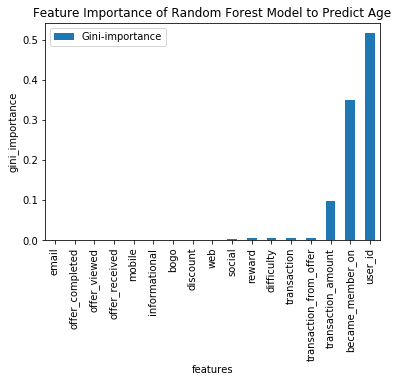

In [66]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, rf_age.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)
plt.title('Feature Importance of Random Forest Model to Predict Age')
plt.xlabel('features')
plt.ylabel('gini_importance')
plt.show();

There are 3 main features that this model considers important which are the user_id, became_member_on, and transaction_amount. The user_id plays an important role and it will be used in the testing dataset since the dataset contains multiple rows for each user id. The second most important feature is became_member_on, and the third one is transaction_amount.

In [67]:
#predict df_ml_test
X = df_ml_test.drop(['gender', 'income', 'time', 'offer_type', 'offer_id','transaction_offer_viewed', 'age', 'reward_achieved'], axis = 1).copy()
X.fillna(0, inplace = True)
pred_age = np.round(rf_age.predict(X)).tolist()

In [68]:
#replace age in df_ml_test to pred_age
df_ml_test['age'] = pred_age
df_ml_test['age'] = df_ml_test['age'].astype('int')

In [69]:
#notice the age difference although the user id is the same
df_ml_test.head()

,age,became_member_on,gender,income,time,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,...,difficulty,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,61,20170212,NaN,NaN,168,0,1,0,2906b810c7d4411798c6938adc9daaa5,0.00,...,10.0,discount,2.0,1.0,1.0,0.0,1.0,0,1,0
1,61,20170212,NaN,NaN,216,0,0,1,2906b810c7d4411798c6938adc9daaa5,0.00,...,10.0,discount,2.0,1.0,1.0,0.0,1.0,0,1,0
2,61,20170212,NaN,NaN,336,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,...,20.0,discount,5.0,1.0,0.0,0.0,1.0,0,1,0
3,61,20170212,NaN,NaN,348,0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,...,20.0,discount,5.0,1.0,0.0,0.0,1.0,0,1,0
4,44,20170212,NaN,NaN,360,0,0,0,NaN,0.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


# Predict Income

In [70]:
X = df_ml_train.drop(['gender', 'income', 'time', 'offer_type', 'offer_id','transaction_offer_viewed', 'reward_achieved'], axis = 1).copy()
y = df_ml_train['income'].copy()

In [71]:
X.fillna(0, inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [72]:
regress = RandomForestRegressor()
regress.fit(X_train, y_train)
y_pred = regress.predict(X_test)
regress_result(y_test, y_pred, 'Random Forest')

MSE for Random Forest is: 79799749.05138123
R2 score for Random Forest is: 0.8242396230757725
MAE for Random Forest is: 4659.287298590361




The model is good, with the R2 score of 0.82. Although it is possible to create better model, I will not do that for now because of the time concerns.

In [75]:
#saving model
joblib.dump(regress, 'predict_income.sav')

['predict_income.sav']

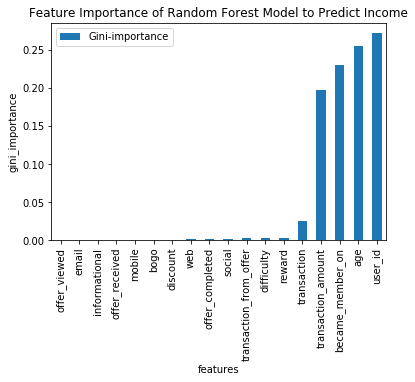

In [76]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, regress.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)
plt.title('Feature Importance of Random Forest Model to Predict Income')
plt.xlabel('features')
plt.ylabel('gini_importance')
plt.show();

There are 4 features that are considered important in predicting income. Again, the user_id is the most important, followed by age, became_member_on, and transaction_amount.

In [77]:
#loading model
regress = joblib.load('predict_income.sav')

In [78]:
#predict df_ml_test income
X = df_ml_test.drop(['gender', 'income', 'time', 'offer_type', 'offer_id','transaction_offer_viewed', 'reward_achieved'], axis = 1).copy()
X.fillna(0, inplace = True)
income_pred = regress.predict(X)

In [79]:
df_ml_test['income'] = income_pred

In [80]:
#notice the income difference although the user id is the same
df_ml_test.head()

,age,became_member_on,gender,income,time,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,...,difficulty,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,61,20170212,NaN,75100.0,168,0,1,0,2906b810c7d4411798c6938adc9daaa5,0.00,...,10.0,discount,2.0,1.0,1.0,0.0,1.0,0,1,0
1,61,20170212,NaN,75100.0,216,0,0,1,2906b810c7d4411798c6938adc9daaa5,0.00,...,10.0,discount,2.0,1.0,1.0,0.0,1.0,0,1,0
2,61,20170212,NaN,74700.0,336,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,...,20.0,discount,5.0,1.0,0.0,0.0,1.0,0,1,0
3,61,20170212,NaN,74700.0,348,0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,...,20.0,discount,5.0,1.0,0.0,0.0,1.0,0,1,0
4,44,20170212,NaN,57200.0,360,0,0,0,NaN,0.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


# Predict Gender

In [81]:
X = df_ml_train.drop(['gender', 'time', 'offer_type', 'offer_id','transaction_offer_viewed', 'reward_achieved'], axis = 1).copy()
y = df_ml_train['gender'].copy()

In [82]:
X.fillna(0, inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [83]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
(y_pred == y_test).mean()

0.8162887467233699

Again, the classifier is quite good with the f1 score on average micro is 0.83. I will also not try to create better classifier because of time concerns.

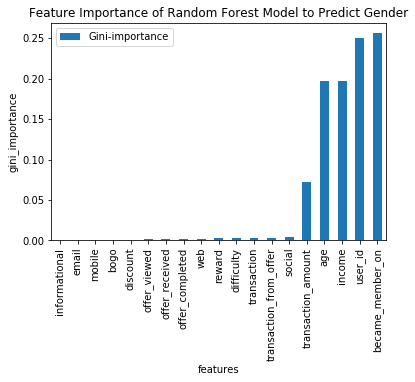

In [85]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)
plt.title('Feature Importance of Random Forest Model to Predict Gender')
plt.xlabel('features')
plt.ylabel('gini_importance')
plt.show();

There are 5 features that this model considers most important which are became_member_on, user_id, income, age, and transaction_amount.

In [86]:
#predict gender on df_ml_test
X = df_ml_test.drop(['gender', 'time', 'offer_type', 'offer_id','transaction_offer_viewed', 'reward_achieved'], axis = 1).copy()
X.fillna(0, inplace = True)
gender_pred = clf.predict(X)

In [87]:
df_ml_test['gender'] = gender_pred

In [88]:
df_ml_test.head()

,age,became_member_on,gender,income,time,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,...,difficulty,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,61,20170212,F,75100.0,168,0,1,0,2906b810c7d4411798c6938adc9daaa5,0.00,...,10.0,discount,2.0,1.0,1.0,0.0,1.0,0,1,0
1,61,20170212,F,75100.0,216,0,0,1,2906b810c7d4411798c6938adc9daaa5,0.00,...,10.0,discount,2.0,1.0,1.0,0.0,1.0,0,1,0
2,61,20170212,F,74700.0,336,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,...,20.0,discount,5.0,1.0,0.0,0.0,1.0,0,1,0
3,61,20170212,F,74700.0,348,0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,...,20.0,discount,5.0,1.0,0.0,0.0,1.0,0,1,0
4,44,20170212,F,57200.0,360,0,0,0,NaN,0.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


There are some prediction / classification errors. For example, the age of user 1 is predicted to be 61 and 44. The gender is predicted to be F and M. This is normal, since the column values for each user is different when they view, receive, and complete offer, and when they do a transaction. 

To address this, I will use:
1. Mean of age values to get the predicted age of each user
2. Mean of income values to get the predicted income of each user
3. Mode of gender values to get the predicted gender of each user

In [89]:
df_test_edited = pd.DataFrame(columns = df_ml_test.columns)
user_list = list(df_ml_test.user_id.unique())

In [90]:
df_test_edited

,age,became_member_on,gender,income,time,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,...,difficulty,offer_type,reward,email,mobile,social,web,bogo,discount,informational


In [91]:
#get mean of age and income, and mode of gender for each user
for user in user_list:
    start_time = time.clock()
    user_df = df_ml_test[df_ml_test['user_id'] == user]
    age = np.round(user_df.age.mean())
    income = user_df.income.mean()
    gender = user_df.gender.value_counts().idxmax()
    user_df['age'] = age
    user_df['income'] = income
    user_df['gender'] = gender
    df_test_edited = pd.concat([df_test_edited, user_df])
    print(time.clock() - start_time)

d:\anaconda\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\anaconda\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\anaconda\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.23296483830404213
0.16817015489618825
0.1697345125173797
0.1680311674092536
0.18812704739252695
0.18281815304862903
0.17561090346134733
0.17366251272278532
0.18400916889754626
0.1785997759093334
0.1742702087806265
0.1687958124139186
0.17899535567971725
0.16938340874298774
0.1816596388889593
0.16770144632528172
0.17117356757353264
0.17074634142181822
0.1745905214809227
0.1698204709325637
0.1783123925520158
0.19044493101932858
0.17301761078351774
0.16940137020264956
0.17918951050728538
0.17803185165530522
0.20345544275005523
0.2233866760179808
0.18096641207012
0.1732570969149947
0.18012222345760165
0.17372580548590122
0.2109017508148554
0.19458290924330868
0.18083084581371622
0.17316258542382457
0.1789457478382701
0.17102902058718428
0.1805421794947506
0.17195489107666617
0.1758657851296448
0.1774434000187739
0.16784086146572008
0.17552408973892852
0.17161234037826034
0.17537654917578038
0.16807136686702506
0.17742928744337405
0.1668119264093093
0.1733259491775243
0.18400959655150473
0

0.17828502270845092
0.1818388258336654
0.17882172823465226
0.18276384101545773
0.17899150679545528
0.17806264272940098
0.17895301795306295
0.1809155212672522
0.17918480631556122
0.18574159446461636
0.1782020578700667
0.19599758803246914
0.1788717637298305
0.17678139192753406
0.2152894788609956
0.2582588502955332
0.226720665087214
0.2648113619061405
0.25313042585753465
0.22148105065980417
0.19901896216970272
0.2147869856394209
0.27036145299666714
0.23094673999526094
0.20712727832574274
0.20030919370151423
0.17943199021533474
0.18365977573830605
0.1767672793521342
0.17538809582879367
0.17597440919644214
0.1780917231881176
0.17639094400283284
0.178387231968145
0.17598253461869717
0.17702686521192845
0.17886021707704458
0.18122728089156226
0.1770730518230721
0.1839621269791678
0.17564768168881528
0.1864489338590829
0.1791377643969554
0.18478578820872826
0.17770426884044355
0.18338479434123656
0.17967019338493628
0.17713078508700164
0.18186277444692678
0.17797625666071326
0.1790004875253998

0.1830456648733616
0.18645363805103443
0.18555599271280698
0.18351693936710944
0.1960792699094327
0.1870198516896835
0.18679447813406114
0.1913280361281977
0.18327574262070812
0.18421444272439658
0.18225878187081435
0.17974588810852765
0.20065773155306488
0.19125105844318568
0.19056766766175315
0.1954758503895846
0.19039959971610187
0.18890067312713654
0.18324794512341214
0.18312435317352538
0.18215700026530612
0.18518051267142255
0.18277795359108495
0.1841092398881301
0.18377951880393084
0.17783983509661994
0.21868633303984097
0.19657748659301433
0.1843033947159256
0.18196840493692434
0.18125037419713408
0.19564220771985674
0.17952949528307727
0.18435214724968318
0.18543111780149957
0.19024778261496067
0.18236655062992213
0.18395400155645802
0.187638239092621
0.17917796385472684
0.1989740585202071
0.19476466211085608
0.18639633244106335
0.2080458787002044
0.1905903333133665
0.18962597398171965
0.1867418767160416
0.1987238810436338
0.18946175492010298
0.18748642199170718
0.192913348785

0.19437549714757552
0.1840976932353442
0.19110651145683732
0.18441372939764733
0.1822895729449101
0.1842204298775414
0.18044510208096654
0.18970380697419387
0.18263853845019185
0.189729466202607
0.18277795359108495
0.18695912484918153
0.18462114149360787
0.1834339745289526
0.1934222568147561
0.20647510627213705
0.20663162756477504
0.19842837226406118
0.20192401447184238
0.18442955258865368
0.19014685631691464
0.21838312649128966
0.21829845103798107
0.20678814885786778
0.18241444785621752
0.186473310125848
0.18464637306806253
0.18736496831093064
0.18616924827028924
0.18886988205304078
0.18269755467554205
0.19102440192614267
0.21823002642918254
0.2007612237741796
0.20387069459525264
0.19171506282214068
0.18515271517412657
0.1856505042039771
0.1829866486480114
0.1868167161319434
0.20108538535873777
0.18546233652932642
0.19795196592440334
0.19790577931348707
0.21691370801499943
0.19408854144398902
0.18868342499376922
0.19382895558374003
0.1815454553229756
0.18703653018815203
0.183708528272

0.19092005439756576
0.19119503579440789
0.1922273920815769
0.19056296346980162
0.20261039882984733
0.1903602555657926
0.18782512380585104
0.19800798857318114
0.1914234029270574
0.19448198294503527
0.2060230761994717
0.20511645013107227
0.21628078038247622
0.20190648066568428
0.19004593001864123
0.19361042448917942
0.1914469238863603
0.197076986238244
0.21148164937517322
0.19407870540635486
0.1889797890812588
0.2008360631900814
0.1924018748341041
0.18873944764254702
0.20290590760941996
0.19792673434994867
0.19157778595081254
0.20938913930376657
0.19448754244467636
0.18941171942469737
0.20632371682495432
0.19238434102817337
0.1938366533527187
0.2043047632082562
0.19536722632301462
0.18964265247996082
0.1935060769606025
0.20172558310605382
0.22161661691598056
0.1996352113037574
0.19642224826156962
0.1918023041989727
0.18964735667168497
0.1981649375197776
0.19343038223723852
0.19244635083032335
0.19588126619737523
0.18961186140586506
0.19950520454676735
0.1941783487432076
0.189758974314827

0.2091445213272891
0.19574099574901993
0.2178583952718327
0.20203349384610192
0.1977971552469171
0.20303334844356868
0.19742210285903639
0.21170360170071945
0.20358972604481096
0.19435753568768632
0.21050018389132674
0.20150747966499694
0.1949310194413556
0.20726113396676737
0.2010007099052018
0.2051288520920025
0.23099506487506005
0.20326855803659782
0.19713643011709792
0.20022494590193674
0.20539570806613483
0.19945132016709977
0.2132196344418844
0.20183463482680963
0.2522383400187209
0.21605326855797102
0.20121581976991365
0.21298528015631746
0.20183848371061686
0.2009643593319197
0.20693055757465117
0.21093938434978554
0.19745802577881477
0.2310480939468107
0.23447017970011075
0.22036444657305765
0.2001787592907931
0.1998439063609112
0.20113627616183294
0.19798703353671954
0.20998742697793205
0.23367987546726
0.1969820470931154
0.20859797976345362
0.19976179683044393
0.1973023597934116
0.20469692174810916
0.20814338376794694
0.21371528520239735
0.20407981730613756
0.203751806837317

In [92]:
df_test_edited.head(100)

,age,became_member_on,gender,income,time,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,...,difficulty,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,54.0,20170212,F,67547.619048,168,0,1,0,2906b810c7d4411798c6938adc9daaa5,0.00,...,10.0,discount,2.0,1.0,1.0,0.0,1.0,0,1,0
1,54.0,20170212,F,67547.619048,216,0,0,1,2906b810c7d4411798c6938adc9daaa5,0.00,...,10.0,discount,2.0,1.0,1.0,0.0,1.0,0,1,0
2,54.0,20170212,F,67547.619048,336,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,...,20.0,discount,5.0,1.0,0.0,0.0,1.0,0,1,0
3,54.0,20170212,F,67547.619048,348,0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,...,20.0,discount,5.0,1.0,0.0,0.0,1.0,0,1,0
4,54.0,20170212,F,67547.619048,360,0,0,0,NaN,0.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
5,54.0,20170212,F,67547.619048,408,0,1,0,fafdcd668e3743c1bb461111dcafc2a4,0.00,...,10.0,discount,2.0,1.0,1.0,1.0,1.0,0,1,0
6,54.0,20170212,F,67547.619048,408,0,0,1,fafdcd668e3743c1bb461111dcafc2a4,0.00,...,10.0,discount,2.0,1.0,1.0,1.0,1.0,0,1,0
7,54.0,20170212,F,67547.619048,414,0,0,0,NaN,0.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
8,54.0,20170212,F,67547.619048,444,0,0,0,NaN,1.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
9,54.0,20170212,F,67547.619048,504,0,1,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.00,...,7.0,discount,3.0,1.0,1.0,1.0,1.0,0,1,0


In [93]:
#concating the cleaned dataframe to df_ml_train
df_use = pd.concat([df_ml_train, df_test_edited]).sort_values(['user_id', 'time'])

In [94]:
df_use.to_csv('df_use.csv', index = False)

In [95]:
df_use = pd.read_csv('df_use.csv')

# Feature Engineering
To engineer the features that are going to be used in the recommendation engine, I will do the following things:
1. Replace some of the 'no transaction' values in the transaction_offer_viewed column of df_use dataframe to transaction_not_from_offer. The values replaced are the ones with the value of 1 in transaction column of df_use dataframe.
2. Create dummy variables out of transaction_offer_viewed column
3. Create a new dataframe, user_demographic, which contains the demographic variables and the transaction behavior of the users.
4. Create 3 new columns which focus on ratio, percentage of offer completed, percentage of transaction after offer received, and percentage of transaction happens although user received offers.

In [96]:
#replacing no transaction with transaction_not_from_offer
index_list = df_use[(df_use['transaction'] == 1) & (df_use['transaction_offer_viewed'] == 'no transaction' )]['transaction_offer_viewed'].index.tolist()
df_use.loc[index_list, 'transaction_offer_viewed'] = 'transaction_not_from_offer'
df_use['transaction_offer_viewed'].value_counts()

no transaction                167581
transaction_not_from_offer     22423
discount3                      18139
discount2                      15500
bogo1                          15348
bogo2                          14010
bogo4                          13775
informational2                 11620
bogo3                           8173
discount4                       8105
informational1                  6705
discount1                       5155
Name: transaction_offer_viewed, dtype: int64

In [97]:
#get dummy variables of transaction_offer_viewed
df_use = pd.concat([df_use, pd.get_dummies(df_use['transaction_offer_viewed'])], axis = 1)
df_use = df_use.rename(columns = {'no transaction': 'no_transaction'})

In [98]:
#creating user_demographic dataframe
user_demographic = df_use.groupby('user_id', as_index = False).agg({
    'age':'mean',
    'gender': 'first',
    'income': 'mean',
    'transaction_from_offer': 'sum',
    'offer_completed': 'sum',
    'offer_received': 'sum',
    'reward_achieved': 'sum',
    'transaction_amount': 'sum',
    'transaction': 'sum',
    'bogo1': 'sum',
    'bogo2': 'sum',
    'bogo3': 'sum',
    'bogo4': 'sum',
    'discount1': 'sum',
    'discount2': 'sum',
    'discount3': 'sum',
    'discount4': 'sum',
    'informational1': 'sum',
    'informational2': 'sum',
    'transaction_not_from_offer': 'sum'
})

In [99]:
user_demographic.shape

(17000, 21)

In [100]:
user_demographic.head()

,user_id,reward_achieved,transaction_amount,transaction,discount1,gender,discount2,transaction_from_offer,informational2,discount3,...,discount4,income,bogo2,age,bogo1,informational1,transaction_not_from_offer,bogo3,bogo4,offer_received
0,1,5.0,20.40,9,3,F,1,9,0,2,...,3,67547.619048,0,54.0,0,0,0,0,0,5
1,2,5.0,77.01,3,0,F,0,0,0,0,...,0,112000.000000,0,55.0,0,0,3,0,0,2
2,3,0.0,14.30,6,0,F,0,2,1,0,...,0,51660.000000,0,57.0,0,0,4,1,0,2
3,4,11.0,159.27,7,0,F,0,7,1,0,...,0,100000.000000,0,75.0,2,0,0,4,0,4
4,5,0.0,4.65,3,1,F,0,1,0,0,...,0,61627.272727,0,47.0,0,0,2,0,0,5


In [101]:
#re-arranging columns
user_demographic = user_demographic[['user_id', 'age', 'gender', 'income', 'offer_received', 'offer_completed', 'reward_achieved','transaction', 'transaction_from_offer', 'transaction_amount', 'informational1', 'informational2', 'bogo1', 'bogo2', 'bogo3', 'bogo4', 'discount1', 'discount2', 'discount3', 'discount4', 'transaction_not_from_offer']]

In [102]:
#create ratio columns
user_demographic['perc_offer_completed'] = user_demographic['offer_completed'] / user_demographic['offer_received']
user_demographic['trans_from_offer_ratio'] = user_demographic['transaction_from_offer'] / user_demographic['offer_received']
user_demographic['trans_not_from_offer_ratio'] = user_demographic['transaction_not_from_offer'] / user_demographic['offer_received']

In [103]:
#replace inf values to 999
user_demographic = user_demographic.replace([np.inf, -np.inf], 999)
#dropping columns that are not needed
user_demographic.drop(['offer_completed', 'offer_received'], axis = 1, inplace = True)

In [104]:
user_demographic.isnull().sum()

user_id                       0
age                           0
gender                        0
income                        0
reward_achieved               0
transaction                   0
transaction_from_offer        0
transaction_amount            0
informational1                0
informational2                0
bogo1                         0
bogo2                         0
bogo3                         0
bogo4                         0
discount1                     0
discount2                     0
discount3                     0
discount4                     0
transaction_not_from_offer    0
perc_offer_completed          6
trans_from_offer_ratio        6
trans_not_from_offer_ratio    0
dtype: int64

The resulting dataframe still has nan values. I will fill this with 0, since the nan values of perc_offer_completed column are there because there is 0 value from offer_received and 0 value from offer_completed resulting in nan. This is also what happened with trans_from_offer_ratio.

In [105]:
#filling nan values with 0
user_demographic.fillna(0, inplace = True)

# Data Visualization
To do the EDA, I will create plots to describe the demographics profile of Starbucks' Customers.

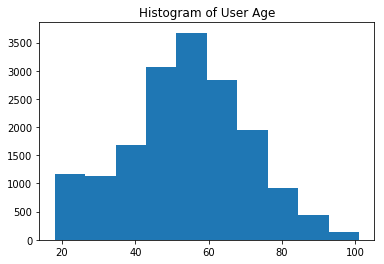

In [106]:
#plotting age
plt.hist(user_demographic.age)
plt.title('Histogram of User Age')
plt.show();

Most users are on the age range of 40 - 80. This result is somewhat consistent with the findings from [numerator](http://snapshot.numerator.com/brand/starbucks) website. However, the major difference is that Numerator found most users of Starbucks to be at the age of 25-34. The rest of the bucket is similar.

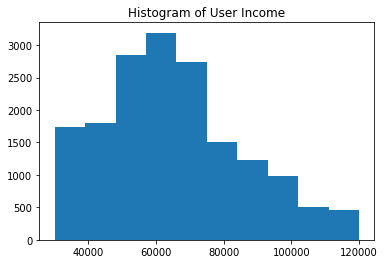

In [107]:
plt.hist(user_demographic.income)
plt.title('Histogram of User Income')
plt.show();

The income of most users is between 50000 - 78000. This makes sense, since a lot of people from the USA is from the lower-middle class with the income between 35000 to 75000 according to [wikipedia](https://en.wikipedia.org/wiki/Household_income_in_the_United_States).

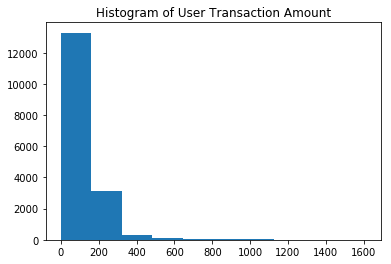

In [108]:
plt.hist(user_demographic.transaction_amount)
plt.title('Histogram of User Transaction Amount')
plt.show();

The amount of transaction for most users is between USD 0 - 200. It would be interesting to see whether users who joined earlier spend more or not.

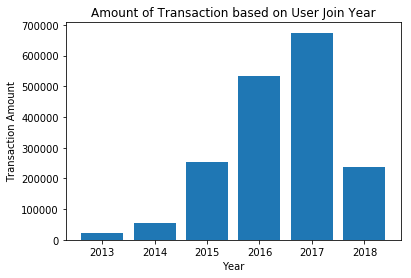

In [109]:
profile['user_id'] = id_mapper(profile)
user_demographic['became_member_on'] = profile['became_member_on']
user_demographic['join_year'] = user_demographic.became_member_on.apply(lambda x: int(str(x)[:4]))
transaction_per_year = user_demographic.groupby('join_year', as_index = False)['transaction_amount'].agg('sum')
plt.bar(transaction_per_year.join_year, transaction_per_year.transaction_amount)
plt.title('Amount of Transaction based on User Join Year')
plt.xlabel('Year')
plt.ylabel('Transaction Amount')
plt.show();

In total, the users who joined in the earlier year spend the least. This is very interesting since they have more time to accumulate the spending. The users who joined on 2017 spend the most. Now, it will also be interesting to see the average spending of these users.

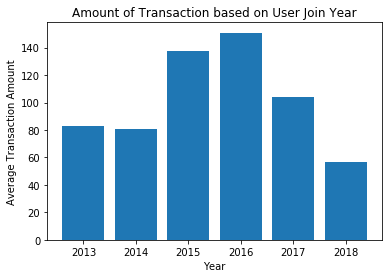

In [110]:
avg_transaction_per_year = user_demographic.groupby('join_year', as_index = False)['transaction_amount'].agg('mean')
plt.bar(avg_transaction_per_year.join_year, avg_transaction_per_year.transaction_amount)
plt.title('Amount of Transaction based on User Join Year')
plt.xlabel('Year')
plt.ylabel('Average Transaction Amount')
plt.show();

Although all users who joined on year 2013 spend the least money to purchase in Starbucks, each user spend considerably more than those who joined on the year 2018. Each user who joined on year 2016 spend the most money per purchase based on average transaction.

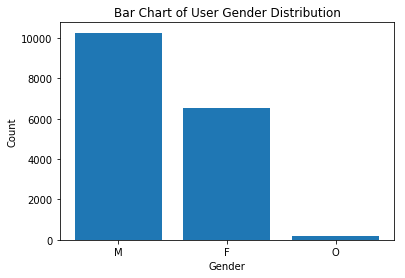

In [111]:
plt.bar(['M', 'F', 'O'],user_demographic.gender.value_counts().tolist())
plt.title('Bar Chart of User Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show();

Most of Starbucks' customers are male, followed by female customers and others. Now, it would be interesting to see which gender is affected by offer.

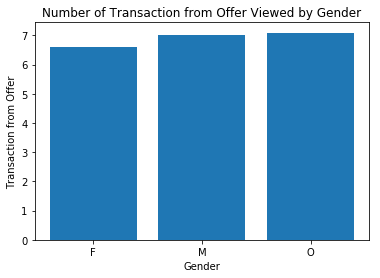

In [112]:
gender_offer = user_demographic.groupby('gender', as_index = False).agg({'transaction_from_offer': 'mean'})
plt.bar(gender_offer.gender.tolist(), gender_offer.transaction_from_offer.tolist())
plt.title('Number of Transaction from Offer Viewed by Gender')
plt.xlabel('Gender')
plt.ylabel('Transaction from Offer')
plt.show();

Surprisingly, the ones filling 'other' as their gender do transaction more after viewing an offer. Female users are the least affected by offer they view. Next, I will look at the percentage of offer completed by gender.

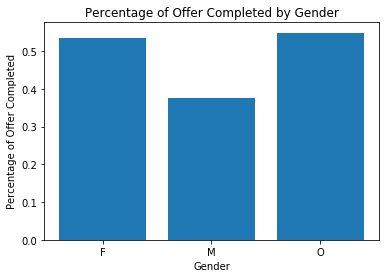

In [113]:
gender_offer_completed = user_demographic.groupby('gender', as_index = False).agg({'perc_offer_completed': 'mean'})
plt.bar(gender_offer_completed.gender.tolist(), gender_offer_completed.perc_offer_completed.tolist())
plt.title('Percentage of Offer Completed by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage of Offer Completed')
plt.show();

Again, the ones with 'other' as gender completed the most offer. Male customers, although they do more transaction, they don't really try to complete the offer.

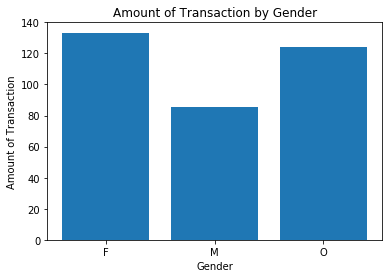

In [114]:
gender_trans_amount = user_demographic.groupby('gender', as_index = False).agg({'transaction_amount': 'mean'})
plt.bar(gender_trans_amount.gender.tolist(), gender_trans_amount.transaction_amount.tolist())
plt.title('Amount of Transaction by Gender')
plt.xlabel('Gender')
plt.ylabel('Amount of Transaction')
plt.show();

As expected, the Female users spend more. So, although they have the least number of transaction, they tend to complete the offer more than male users.

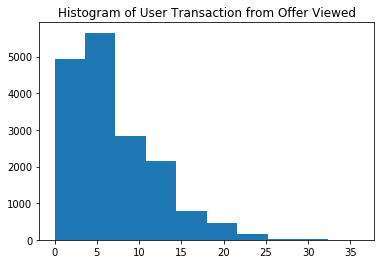

In [115]:
plt.hist(user_demographic.transaction_from_offer)
plt.title('Histogram of User Transaction from Offer Viewed')
plt.show();

In total, most customers have between 0-7 transactions after viewing the offer. This is good, since we can say that when the customers view the offer, they tend to purchase something from Starbucks.

# Clustering
After getting a fair grasp on the Starbucks' customers demographic profile, I will do a clustering using KMeans to segment the demographics into clusters.

In [116]:
user_cluster = pd.concat([user_demographic,pd.get_dummies(user_demographic.gender)], axis = 1).copy()
user_cluster.drop(['gender', 'user_id','join_year'], axis = 1, inplace = True)

### Methodology
Before doing the clustering, I will use standard scaler to scale the data. This is necessary because there are columns with really big values and those with just 0 and 1. Performing standard scaler will normalize the data. 

Then, I will do KMeans clustering and determine how many clusters I will use to predict the data using elbow method. After finding the number of cluster, I will predict the data using KMeans and get the clusters. These clusters will be appended to the dataframe.

After getting the clustering done, I will group the dataframe by clusters to identify the certain characteristics of each cluster. Then, I will describe the first 3 clusters to give a picture of what the customer segments look like.

### Implementation

In [117]:
#scale the data using standard scaler
scale = StandardScaler()
scale.fit(user_cluster)
data = scale.transform(user_cluster)
user_scaled = pd.DataFrame(data)
user_scaled.columns = user_cluster.columns
user_scaled.index = user_cluster.index
user_scaled.head()

,age,income,reward_achieved,transaction,transaction_from_offer,transaction_amount,informational1,informational2,bogo1,bogo2,...,discount3,discount4,transaction_not_from_offer,perc_offer_completed,trans_from_offer_ratio,trans_not_from_offer_ratio,became_member_on,F,M,O
0,-0.006404,0.135255,-0.183028,0.161509,0.429938,-0.667401,-0.317957,-0.419148,-0.431109,-0.437258,...,0.392164,1.735161,-0.880450,-0.117248,0.221047,-0.037628,0.272135,1.266557,-1.233797,-0.112375
1,0.054142,2.311414,-0.183028,-1.011260,-1.373751,-0.217826,-0.317957,-0.419148,-0.431109,-0.437258,...,-0.448487,-0.327858,1.122089,0.177367,-1.393856,0.042308,0.315211,1.266557,-1.233797,-0.112375
2,0.175232,-0.642521,-1.125615,-0.424876,-0.972931,-0.715844,-0.317957,0.194063,-0.431109,-0.437258,...,-0.448487,-0.327858,1.789602,-1.295709,-0.496687,0.068953,1.171327,1.266557,-1.233797,-0.112375
3,1.265048,1.723956,0.948076,-0.229414,0.029118,0.435452,-0.317957,0.194063,0.523915,-0.437258,...,-0.448487,-0.327858,-0.880450,0.913905,0.176189,-0.037628,0.297570,1.266557,-1.233797,-0.112375
4,-0.430221,-0.154575,-1.125615,-1.011260,-1.173341,-0.792481,-0.317957,-0.419148,-0.431109,-0.437258,...,-0.448487,-0.327858,0.454576,-1.295709,-1.214422,-0.016312,0.322833,1.266557,-1.233797,-0.112375


In [118]:
#fit KMeans for every k, append the SSE score to a list (scores)
scores = []
k_list = list(range(1,user_scaled.shape[1]+1))
for k in k_list:
    kmeans = KMeans(k)
    model = kmeans.fit(user_scaled)
    scores.append(np.abs(model.score(user_scaled)))

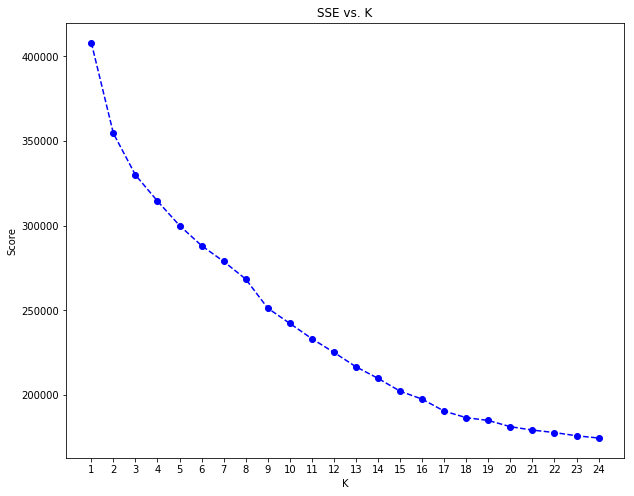

In [119]:
#plot the scores to find the elbow
plt.figure(figsize = (10,8))
plt.plot(k_list, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Score');
plt.xticks(k_list)
plt.title('SSE vs. K');

There is no clear elbow in the KMeans result, except for the slightly huge reduction of SSE from cluster 7 to 16. Therefore, I decided to go with 16 clusters.

In [120]:
#predicting clusters for each users
k_16 = KMeans(16)
cluster_list = k_16.fit_predict(user_scaled)

In [121]:
#changing values in cluster_list so it starts from 1 and ends at 16
cluster_list = cluster_list + 1

In [122]:
user_demographic['cluster'] = cluster_list
user_demographic.head(10)

,user_id,age,gender,income,reward_achieved,transaction,transaction_from_offer,transaction_amount,informational1,informational2,...,discount2,discount3,discount4,transaction_not_from_offer,perc_offer_completed,trans_from_offer_ratio,trans_not_from_offer_ratio,became_member_on,join_year,cluster
0,1,54.0,F,67547.619048,5.0,9,9,20.40,0,0,...,1,2,3,0,0.400000,1.80,0.0,20170212,2017,10
1,2,55.0,F,112000.000000,5.0,3,0,77.01,0,0,...,0,0,0,3,0.500000,0.00,1.5,20170715,2017,10
2,3,57.0,F,51660.000000,0.0,6,2,14.30,0,1,...,0,0,0,4,0.000000,1.00,2.0,20180712,2018,10
3,4,75.0,F,100000.000000,11.0,7,7,159.27,0,1,...,0,0,0,0,0.750000,1.75,0.0,20170509,2017,15
4,5,47.0,F,61627.272727,0.0,3,1,4.65,0,0,...,0,0,0,2,0.000000,0.20,0.4,20170804,2017,10
5,6,68.0,M,70000.000000,7.0,3,1,57.73,0,0,...,0,0,0,2,0.500000,0.25,0.5,20180426,2018,3
6,7,39.0,F,48300.000000,0.0,0,0,0.00,0,0,...,0,0,0,0,0.000000,0.00,0.0,20170925,2017,10
7,8,47.0,F,62881.818182,0.0,2,2,0.24,0,0,...,1,0,1,0,0.000000,0.40,0.0,20171002,2017,10
8,9,65.0,M,53000.000000,19.0,3,3,36.43,0,0,...,0,0,1,0,0.833333,0.50,0.0,20180209,2018,3
9,10,54.0,F,65971.428571,5.0,6,4,15.62,0,3,...,0,0,0,2,0.250000,1.00,0.5,20161122,2016,10


In [123]:
user_demographic.groupby('cluster')['user_id'].agg('count')

cluster
1      212
2      671
3     2080
4     4293
5      565
6      590
7        6
8      561
9      639
10    2187
11     648
12     534
13     676
14     621
15    2189
16     528
Name: user_id, dtype: int64

The number of users who belong in each cluster is different. Cluster 2 has most users and cluster 8 has the least. This might affect the quality of recommendation engine based on cluster since the clusters with a lot of users will have a lot of different preferences mixed in a cluster.

In [124]:
from scipy import stats

In [125]:
#creating a dataframe containing the column values of cluster demographic
df_cluster = user_demographic.groupby('cluster', as_index = False).agg({
    'age':'mean',
    'gender': lambda x:stats.mode(x)[0],
    'income': 'mean',
    'trans_from_offer_ratio': 'mean',
    'trans_not_from_offer_ratio': 'mean',
    'perc_offer_completed': 'mean',
    'reward_achieved': 'sum',
    'transaction_amount': 'mean',
    'transaction': 'sum',
    'bogo1': 'sum',
    'bogo2': 'sum',
    'bogo3': 'sum',
    'bogo4': 'sum',
    'discount1': 'sum',
    'discount2': 'sum',
    'discount3': 'sum',
    'discount4': 'sum',
    'informational1': 'sum',
    'informational2': 'sum',
    
})

d:\anaconda\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [126]:
df_cluster

,cluster,reward_achieved,transaction_amount,transaction,discount1,gender,perc_offer_completed,discount2,discount4,informational2,trans_from_offer_ratio,discount3,income,bogo2,age,bogo1,informational1,trans_not_from_offer_ratio,bogo4,bogo3
0,1,1577.0,124.323302,1781,106,O,0.549057,217,110,141,1.673428,224,63287.735849,109,54.400943,187,96,0.380425,133,181
1,2,6132.0,155.046647,9575,54,M,0.660407,5397,162,338,2.804223,640,57196.495404,466,50.576751,526,161,0.458495,436,200
2,3,18453.0,140.182995,13117,479,M,0.666130,1418,781,836,1.171651,1834,78212.053255,1226,60.097596,1219,569,0.360112,1311,784
3,4,5759.0,21.392562,19689,357,M,0.102240,2045,728,1763,0.797558,2182,56166.787134,2037,49.854880,2153,728,0.333345,1886,704
4,5,6377.0,160.033292,7303,116,M,0.670590,373,171,282,2.564307,535,59456.590842,334,51.778761,403,154,0.358083,423,3713
5,6,3362.0,132.823763,8203,65,M,0.504661,385,185,308,2.681158,552,55554.220341,4633,49.447458,463,115,0.398842,371,167
6,7,0.0,41.768333,20,0,F,0.000000,0,0,0,0.000000,0,57950.000000,0,64.000000,0,0,999.000000,0,0
7,8,4370.0,162.712638,7152,99,M,0.632620,410,3639,301,2.516043,523,61217.295107,378,52.807487,396,153,0.328253,359,159
8,9,3586.0,127.057355,9242,76,M,0.488419,431,164,325,2.897157,629,54101.908636,472,49.921753,5382,127,0.439802,393,149
9,10,5520.0,41.097599,8523,175,F,0.209259,751,372,871,0.664708,835,67581.970499,810,56.475537,815,434,0.302644,743,329


### First 3 Cluster Description
1. The first cluster is populated with Male customers with the age around 49 and the income around USD 58052. They tend to favor bogo4 over other types of offer. After receiving an offer, they do about 2-3 transactions. They also do moderate transaction not from offer received, indicating that they do like to have their coffee at Starbucks.
2. The second cluster is also populated with Male customers with the age around 49 and the income around USD 56291. They tend to favor discount3 over other types of offer. After receiving an offer, they only do about 1 transaction. However, they do purchase in Starbucks although they didn't receive any offer. I think, these customers are not really loyal. They buy coffee whenever they feel like it, and they prefer discount over anything else.
3. The third cluster is populated with Male customers with the age around 60 and income around USD 78141. They tend to favor bogo1 over other types of offer. After receiving an offer, they do about 2-3 transactions and they also buy coffee although they didn't receive offers. This cluster is similar to the first cluster, only they have higher income. 

# Recommendation based on cluster
Finally, after segmenting the customers, I will create a recommendation system based on these clusters. The things to do are as follows:
1. I have to consider which users don't like offers. Therefore, I will create a dataframe containing the user_id and transaction not from offer ratio. If the ratio is greater than the mean value, I will not recommend anything to these users.
2. Create cluster-promotion matrix.
3. Check which cluster a user belongs to.
4. Recommend top 3 offers which the cluster this user belongs to like, and get the list of these offer ids.  
5. If the user id is new, I will give a list of most popular offers.

In [127]:
def get_offer_id(offer_list):
    '''
    INPUT: a list of offer names (bogo1, discount1, etc)
    OUTPUT: a list of offer ids according to the portfolio dataframe
    '''
    offer_names = []
    reverse_offer_name = {v: k for k, v in offer_name_dict.items()}
    for offer in offer_list:
        offer_names.append(reverse_offer_name[offer])
    return offer_names

In [128]:
#create dataframe to check which cluster a user belongs to
check_cluster = user_demographic[['cluster', 'user_id']]

In [129]:
#create cluster - promotion matrix
recom_cluster = df_cluster[['cluster', 'discount1', 'discount2','discount3','discount4', 'bogo1','bogo2','bogo3','bogo4']]
recom_cluster = recom_cluster.set_index('cluster')

In [130]:
#create a dataframe to find out which users should not be given recommendation
offer_or_not = user_demographic[['user_id', 'trans_not_from_offer_ratio']]
offer_or_not = offer_or_not[offer_or_not['trans_not_from_offer_ratio'] > offer_or_not.trans_not_from_offer_ratio.mean()]

In [131]:
def cluster_recommendation(user_id, top_n=3):
    '''
    INPUT: 
    user_id - an id of a user
    top_n - how many recommendation will be made
    
    OUTPUT:
    The offer id of recommended offers (list)
    '''
    
    if user_id in offer_or_not['user_id'].tolist():
        return 'do not offer anything'
    else:
        #check cluster for user_id
        if user_id in check_cluster['user_id']:
            cls = check_cluster[check_cluster['user_id'] == user_id]['cluster'].tolist()[0]
            recommendation = recom_cluster.loc[cls].nlargest(top_n).index.tolist()
        else:
            recommendation = recom_cluster.stack().nlargest(top_n).index.get_level_values(level=1).tolist()
    return get_offer_id(recommendation)

In [132]:
#test for user who should be given recommendation
cluster_recommendation(293)

['fafdcd668e3743c1bb461111dcafc2a4',
 'ae264e3637204a6fb9bb56bc8210ddfd',
 '4d5c57ea9a6940dd891ad53e9dbe8da0']

In [133]:
#test for user who should not be given recommendation
cluster_recommendation(20)

'do not offer anything'

In [134]:
#test for new user
cluster_recommendation(9999999999)

['fafdcd668e3743c1bb461111dcafc2a4',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 'ae264e3637204a6fb9bb56bc8210ddfd']

# User-based Recommendation
A cluster recommendation system is good. However, I decide to create user-based recommendation system to make it more personalized. To do this, I will do the following:
1. Create a user-promotion matrix.
2. Create a function to find similar users.
3. Check if a user id likes being given offers or not. If he/she doesn't like it, don't offer anything.
4. Find top 10 similar users and get top 3 offers they like.
5. Create recommendation based on the offers. 

In [152]:
#create user-promotion matrix
recom_user = user_demographic[['user_id', 'discount1', 'discount2','discount3','discount4', 'bogo1','bogo2','bogo3','bogo4']]
recom_user = recom_user.set_index('user_id')

In [153]:
def find_similar_users(user_id, recom_user = recom_user):
    '''
    INPUT:
    user_id - (int) a user_id
    recom_user - (pandas dataframe) matrix of users by prommotion
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first   
    '''
    
    # compute similarity of each user to the provided user
    user_row = recom_user.loc[user_id]
    similarities = np.dot(user_row.T, recom_user.T)
    # create list of just the ids
    most_similar_users = list(((-similarities).argsort()) + 1)
       
    # remove the own user's id
    most_similar_users.remove(user_id)  
    return most_similar_users # return a list of the users in order from most to least similar
    

In [154]:
def user_user_recs(user_id, recom_user = recom_user, offer_or_not = offer_or_not, n_user = 10, top_n = 3):
    '''
    INPUT:
    user_id - an id of a user
    recom_user - user-promotion matrix
    offer_or_not - a pandas dataframe consisting of user_id and trans_not_from_offer_ratio
    n_user - number of similar users we want to use to create recommendation
    top_n - number of recommendation to be given to the user_id
    
    OUTPUT:
    the offer id of recommendation (list)
    '''
    if user_id in offer_or_not['user_id'].tolist():
        return 'do not offer anything'
    else:
        if user_id in recom_user.index:
            #find top 10 similar users 
            sim_users = find_similar_users(user_id)[:n_user]
            sim_users_df = pd.DataFrame(columns = recom_user.columns)
            for user in sim_users:
                sim_users_df = sim_users_df.append(recom_user.loc[user])
            recommendation = sim_users_df.sum().nlargest(top_n).index.tolist()
        else:
            recommendation = recom_user.sum().nlargest(top_n).index.tolist()
    return get_offer_id(recommendation)

In [155]:
#test for user who should be given recommendation
user_user_recs(293)

['4d5c57ea9a6940dd891ad53e9dbe8da0',
 'fafdcd668e3743c1bb461111dcafc2a4',
 'f19421c1d4aa40978ebb69ca19b0e20d']

In [156]:
#test for user who should not be given recommendation
user_user_recs(3)

'do not offer anything'

In [157]:
#test for new user
user_user_recs(99999999999999999)

['fafdcd668e3743c1bb461111dcafc2a4',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 'ae264e3637204a6fb9bb56bc8210ddfd']

# Evaluation and Validation
Both of the recommendation engines have successfully achieved what I want:
1. It recognizes which users should not be given offers
2. It recommends offers based on similar users / clusters' preference
3. It recommends most popular offers for new users.

Evaluating the recommendation engines is not an easy task. Starbucks has to spend certain amount of time to do A/B testing for these system. The metrics have already been mentioned in the introduction part of this notebook. However, there is a slight change on the number of group. Starbucks should have 3 groups, 1 control group and 2 experimental groups to test these recommendation engines.

### Justification
Personally, I think that the user-based recommendation engine is better than the cluster-based one. It is more personalized and versatile as we can determine how many similar users we'd like to use. Also, as I have mentioned above, the number of users in each cluster is considerably different. The maximum number is above 4000, and the minimum number is only 8. This will affect the cluster-based recommendation engine since the more users are in a cluster, the higher the variance of preference. 

# Conclusion
## Reflection
The data sets which is given is really tough, in the sense that there are just basic features in the dataset. Most of the time, businesses in hospitality industry tend to rely on ratios as metrics, so I have to create those ratios data with what these data sets. However, that wasn't really the toughest part. 

The toughest part of this project was to clean the data, especially imputing age, gender, and income. I can impute these variables using statistics such as mean for age, mode for gender, and mean / median for income. However, the result will be less accurate. When I decided to create a recommendation engine for this project, I realized that getting the most accurate data is vital, especially for the clustering part. Therefore, I decided to impute the missing / wrong values using machine learning. It was not easy for me, especially because I have to determine the order of imputation. I decided to go with the one with higher R2 score first.

After imputing the data, the process towards creating recommendation engine is not that difficult (assuming I got my logic right). However, the problem with recommendation engine is that it should be tested in real life to find out whether it's working great or not. I will need to study further to deepen my knowledge on machine learning and recommendation engine to make sure that I can build great performing models.

## Improvement
Several improvements can be made to build better recommendation engine. Some of those are:
1. Build a better random forest model to predict age, gender, and income. The R2 score is not high enough, and the MSE score is also not low enough. I can tune the hyperparameter more if I have more time, or perhaps try to use other algorithms such as Ada Boost or perhaps even neural networks.
2. Build a better recommendation engine by classifying promotion offers into star, workhorse, puzzle, and dog. I will use the menu engineering concept and implement it to classify promotion. The star promotion will be those which have low cost and high amount of transaction generated. The workhorse will be those which have high cost and high amount of transaction generated. The puzzle will be those which have low cost but low amount of transaction generated. The dog will be those which have high cost and low amount of transaction generated. By doing this, we can always promote either star or puzzle promotion and tune the workhorse promotion as well as getting rid of the dog promotion. Of course, I will need additional data to do that.